In [1]:
import warnings
import optuna
import missingno as msno
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import pprint
from scipy import stats
from sklearn.feature_selection import chi2
import os
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import re
import category_encoders
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn as sk
from sklearnex import patch_sklearn, config_context
patch_sklearn()
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

tqdm.pandas()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df = pd.read_csv('./Dataset/train.csv')


<Axes: >

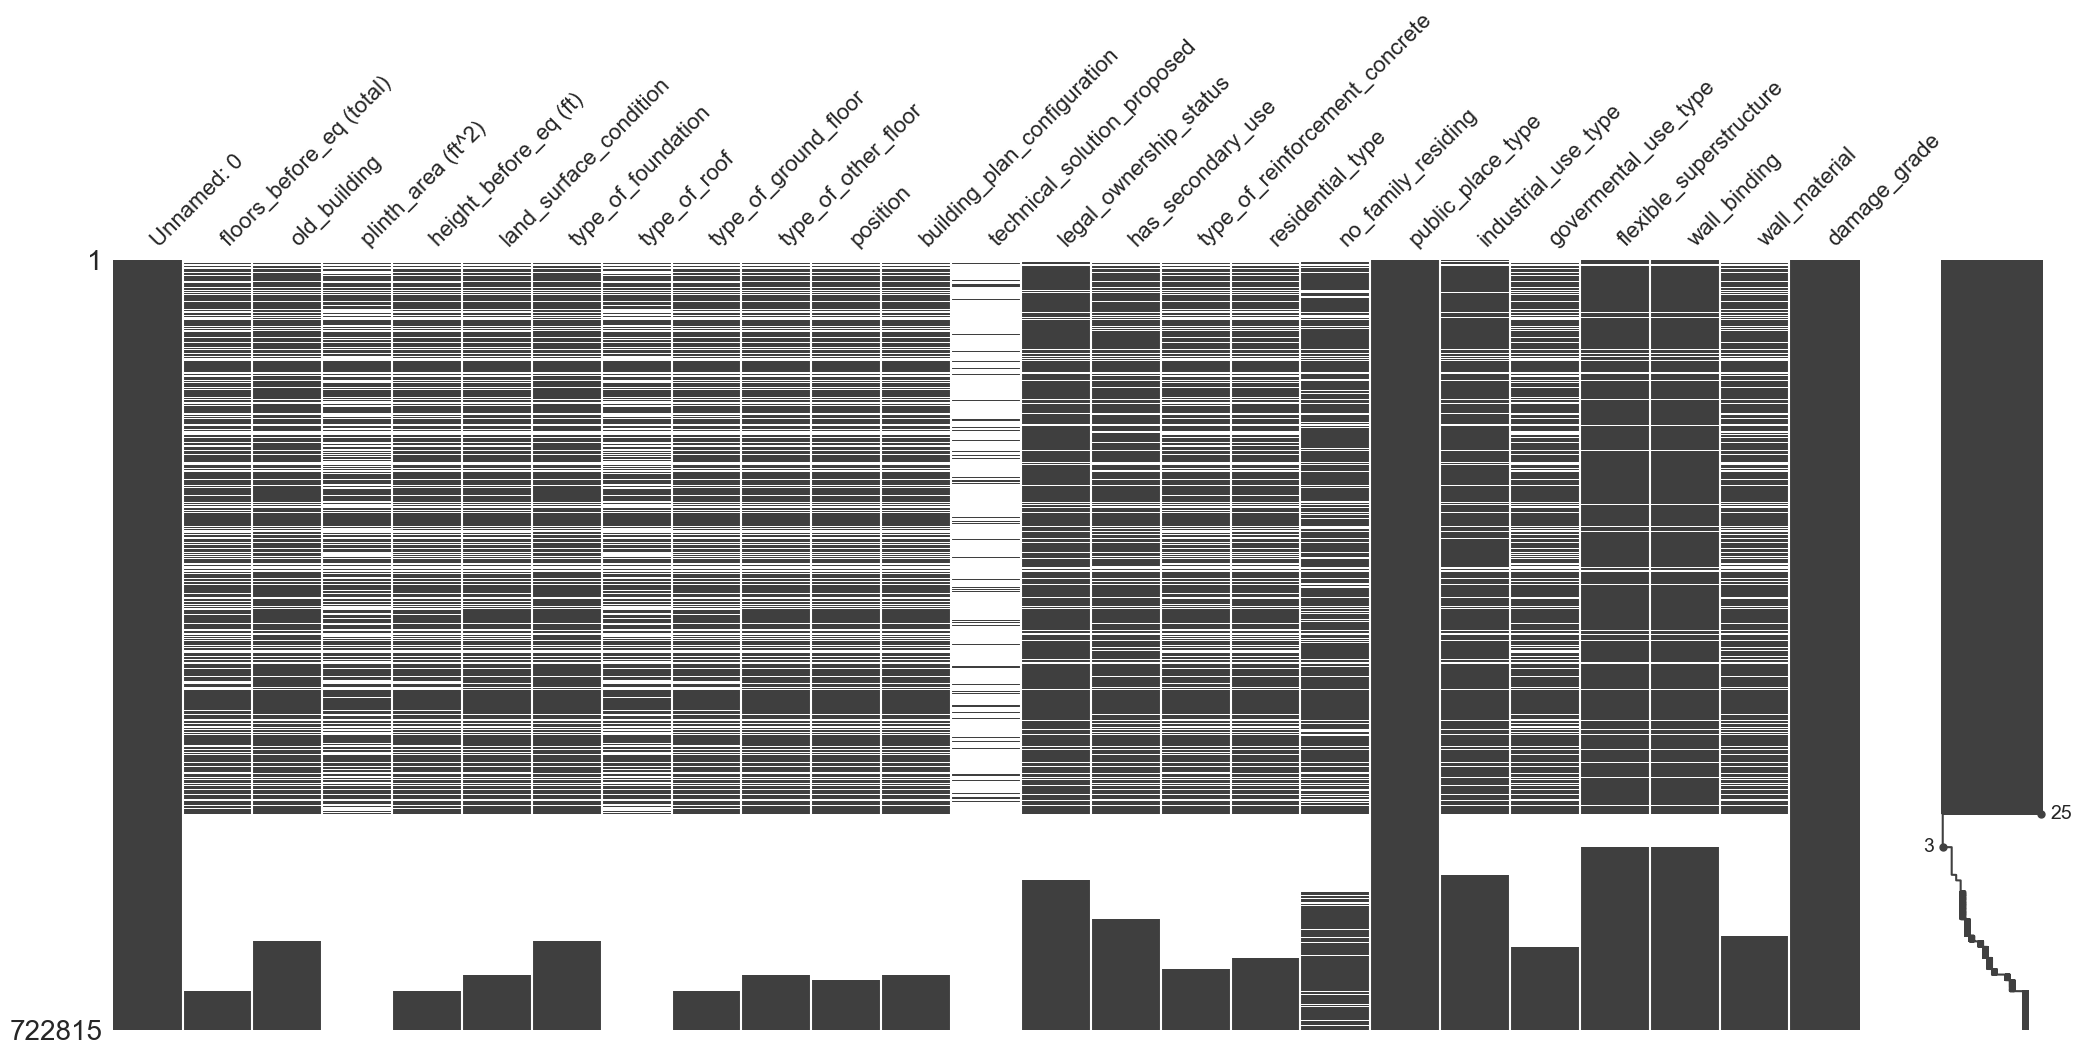

In [3]:
msno.matrix(df)


In [4]:
df.head()


Unnamed: 0 floors_before_eq (total)  old_building plinth_area (ft^2)   
0           0                floor two           1.0           256 ft^2  \
1           1                  Floor 3           3.0           985 ft^2   
2           2                Two Floor           7.0                NaN   
3           3                      two          18.0           185 ft^2   
4           4             just 2 floor          22.0           290 ft^2   

   height_before_eq (ft) land_surface_condition   
0                   22.0                   Flat  \
1                   18.0                   Flat   
2                   14.0                   Flat   
3                   15.0                   Flat   
4                   17.0                   Flat   

                   type_of_foundation                          type_of_roof   
0                    Bamboo or Timber              Bamboo/Timber Light roof  \
1  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Heavy Roof   
2              Mud mortar-Stone/Brick                                   NaN   
3  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Light Roof   
4  Clay Sand Mixed mortar-Stone/Brick           Bamboo or Timber Light roof   

  type_of_ground_floor       type_of_other_floor  ...   
0                 Clay         TImber/Bamboo-Mud  ...  \
1                 Clay         TImber/Bamboo-Mud  ...   
2                 Clay    Wood-Mud or Bamboo Mud  ...   
3                 Clay         TImber/Bamboo-Mud  ...   
4                 Clay  Timber Mud or Bamboo-Mud  ...   

  type_of_reinforcement_concrete residential_type no_family_residing   
0                            0.0  Non-residential                1.0  \
1                            0.0  Non-residential                1.0   
2                            0.0  Non-residential                1.0   
3                            0.0  Non-residential                1.0   
4                            0.0  Non-residential                1.0   

  public_place_type  industrial_use_type  govermental_use_type   
0        Non-public       Non-industrial       Non-govermental  \
1        Non-public       Non-industrial       Non-govermental   
2        Non-public       Non-industrial       Non-govermental   
3        Non-public       Non-industrial       Non-govermental   
4        Non-public       Non-industrial       Non-govermental   

  flexible_superstructure  wall_binding wall_material damage_grade  
0             unavailable           0.0           0.0          1.0  
1             unavailable           5.0           2.0          5.0  
2             unavailable           5.0           2.0          5.0  
3             unavailable           5.0           2.0          4.0  
4             unavailable           5.0           2.0          1.0  

[5 rows x 25 columns]

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722815 entries, 0 to 722814
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      722815 non-null  int64  
 1   floors_before_eq (total)        390009 non-null  object 
 2   old_building                    483611 non-null  float64
 3   plinth_area (ft^2)              301607 non-null  object 
 4   height_before_eq (ft)           390009 non-null  float64
 5   land_surface_condition          421209 non-null  object 
 6   type_of_foundation              483611 non-null  object 
 7   type_of_roof                    301607 non-null  object 
 8   type_of_ground_floor            390009 non-null  object 
 9   type_of_other_floor             421209 non-null  object 
 10  position                        410809 non-null  object 
 11  building_plan_configuration     421209 non-null  object 
 12  technical_soluti

In [6]:
df_cl = df.copy().drop('Unnamed: 0', axis=1).drop_duplicates().reset_index(drop=True)


In [7]:
df_cl.fillna(np.nan, inplace=True)


Missing Value Analysis



<Axes: >

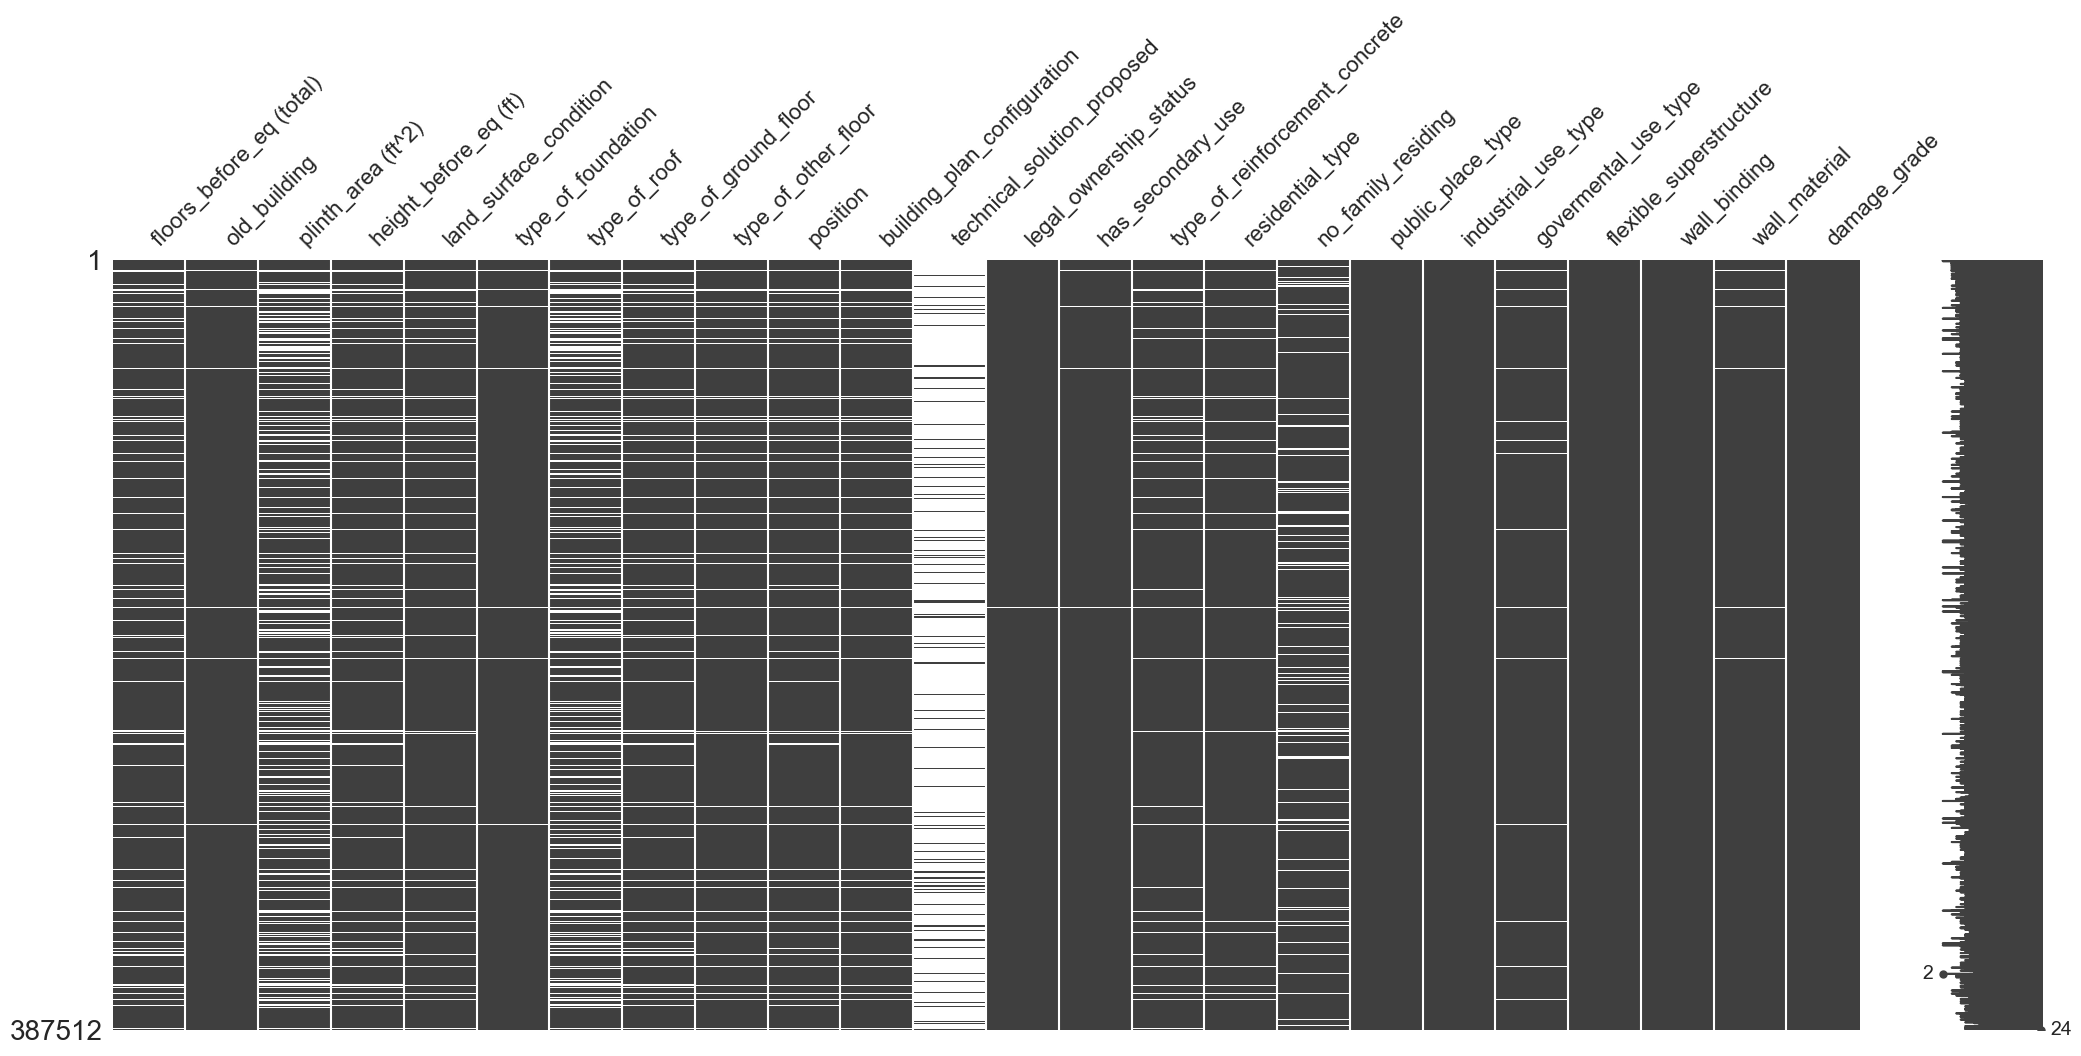

In [8]:
msno.matrix(df_cl)


<Axes: >

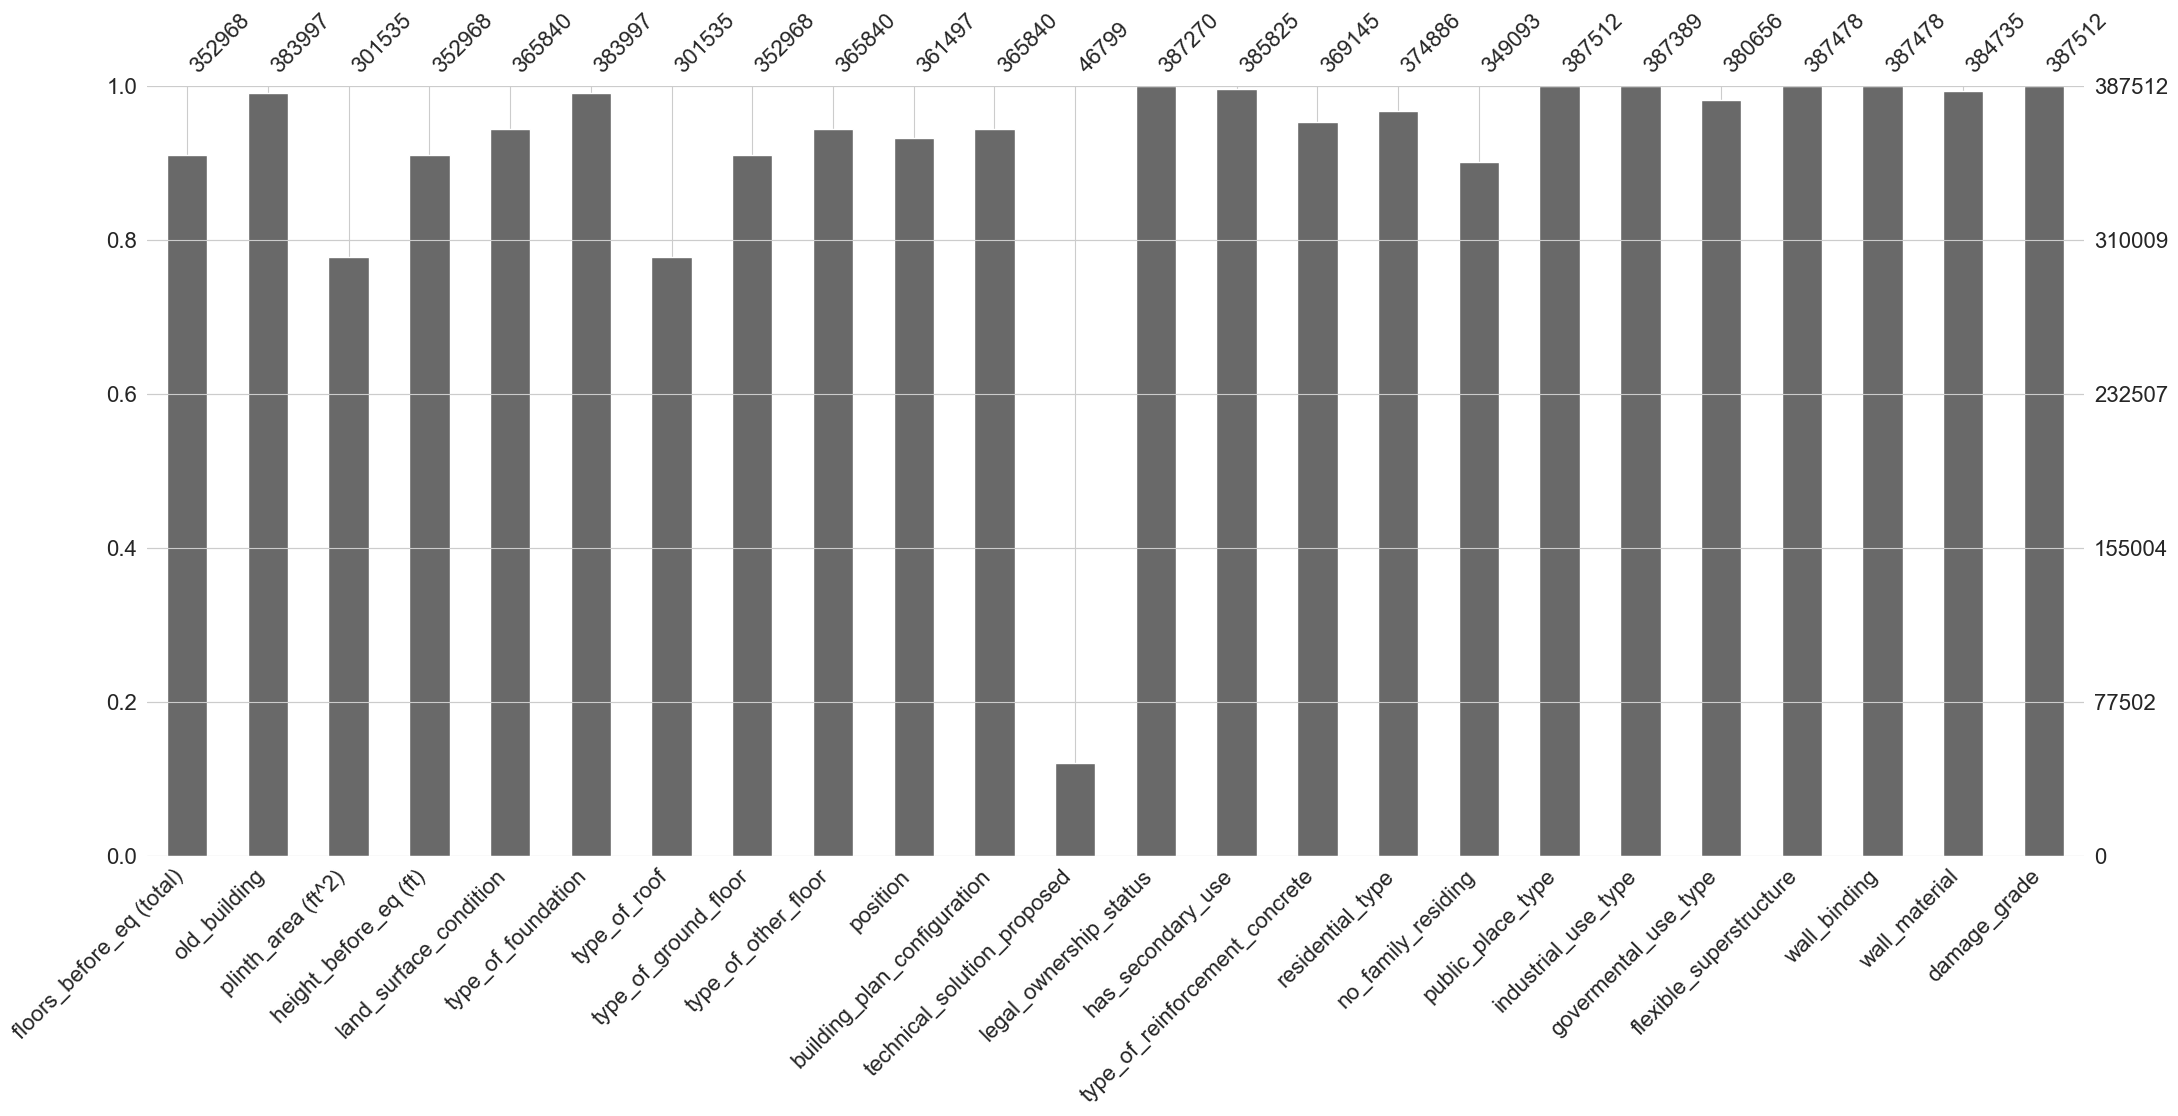

In [9]:
msno.bar(df_cl)


<Axes: >

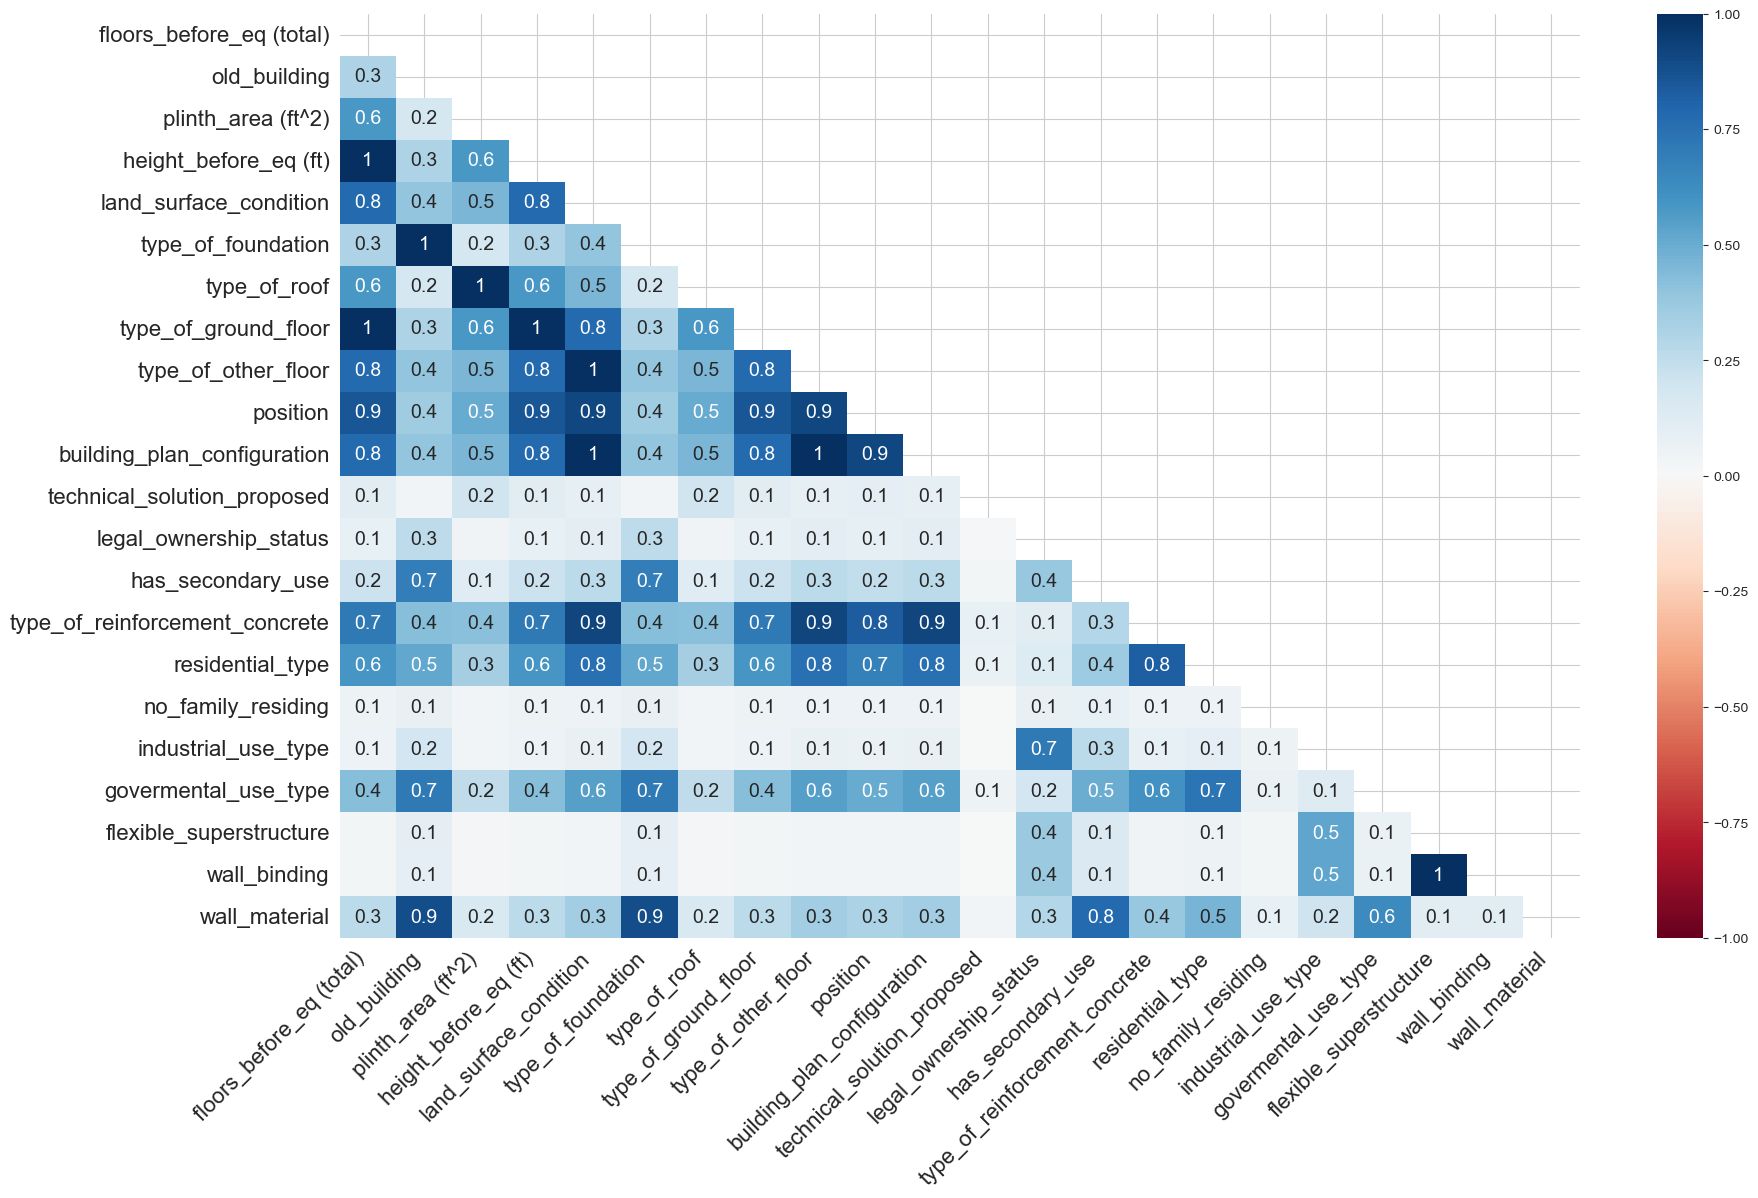

In [10]:
msno.heatmap(df_cl)


<Axes: >

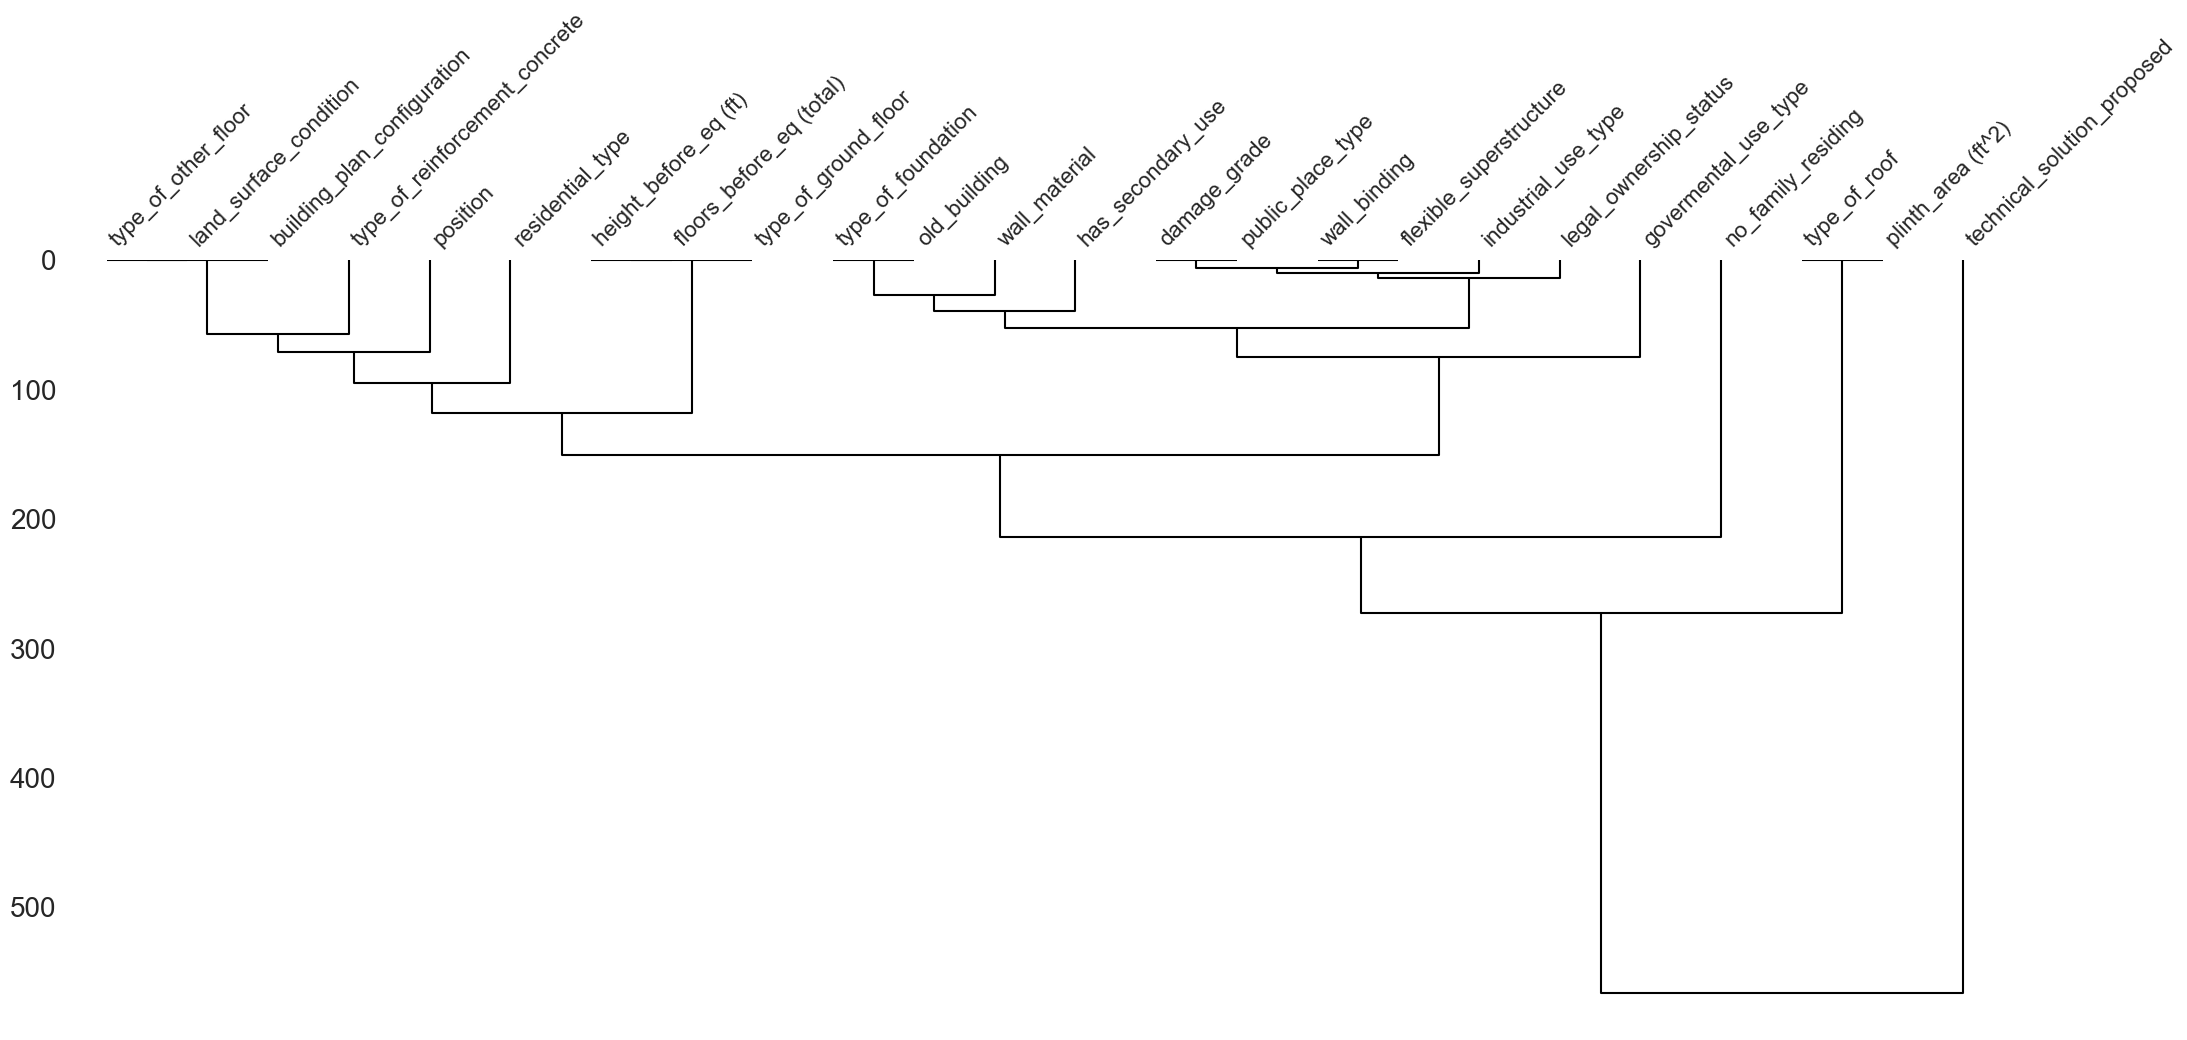

In [11]:
msno.dendrogram(df_cl)


In [12]:
wallBinding = {0: 'Unknown/not stated',
               1: 'Clay',
               2: 'Mortar + Cement',
               3: 'Mortar + Cement,Clay',
               5: 'Mud + Mortar,Clay',
               7: 'Mud + Mortar,Clay,Cement + Mortar'}


In [13]:
wallMaterial = {0: 'Unknown/not stated',
                1: 'Red Bricks',
                2: 'Stone Bricks',
                3: 'Both'}


In [14]:
tofc = {0: 'No reinforcement concrete',
        1: 'Non-engineered reinforcement concrete',
        2: 'Engineered reinforcement concrete',
        3: 'Both'}


In [15]:
df_cl['type_of_reinforcement_concrete'] = df_cl['type_of_reinforcement_concrete'].map(
    tofc)


In [16]:
df_cl['wall_binding'] = df_cl['wall_binding'].map(wallBinding)


In [17]:
df_cl['wall_material'] = df_cl['wall_material'].map(wallMaterial)


In [18]:
df_cl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387512 entries, 0 to 387511
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        352968 non-null  object 
 1   old_building                    383997 non-null  float64
 2   plinth_area (ft^2)              301535 non-null  object 
 3   height_before_eq (ft)           352968 non-null  float64
 4   land_surface_condition          365840 non-null  object 
 5   type_of_foundation              383997 non-null  object 
 6   type_of_roof                    301535 non-null  object 
 7   type_of_ground_floor            352968 non-null  object 
 8   type_of_other_floor             365840 non-null  object 
 9   position                        361497 non-null  object 
 10  building_plan_configuration     365840 non-null  object 
 11  technical_solution_proposed     46799 non-null   object 
 12  legal_ownership_

# Data Cleaning



In [19]:
def clean_fbe(x):
    if type(x) != str:
        return
    word_num = ['one', 'two', 'three', 'four', 'five',
                'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve']
    th = ['first', 'second', 'third', 'fourth',
          'fifth', 'sixth', 'seventh', 'eight', 'nineth']
    digit = re.search(r'\d', x)
    if digit:
        return int(digit.group(0))

    for i in range(len(word_num)):
        if word_num[i] in x.lower():
            return i+1

    for i in range(len(th)):
        if th[i] in x.lower():
            return i+1
    return 0


In [20]:
df_cl['floors_before_eq (total)'] = df_cl['floors_before_eq (total)'].apply(
    clean_fbe)


In [21]:
def clear_plinth_area(x):
    if pd.isna(x):
        return
    else:
        sentences = re.sub('[ ft^2]', '', x)
        try:
            sentences = int(sentences)
        except:
            sentences = 1001
        return sentences


In [22]:
df_cl['plinth_area (ft^2)'] = df_cl['plinth_area (ft^2)'].apply(
    clear_plinth_area)


In [23]:
df_cl['type_of_foundation'] = df_cl['type_of_foundation'].str.lower().replace(
    ['rc', 'other', 'cement-stone or cement-brick', 'bamboo or timber'], ['reinforced concrete', 'others', 'cement-stone/brick', 'bamboo/timber'])


In [24]:
df_cl['type_of_roof'] = df_cl['type_of_roof'].str.lower().replace(
    ['rcc/rb/rbc'], ['reinforced cement concrete/rb/rbc']).\
    replace(['bamboo/timber heavy roof', 'bamboo or timber heavy roof'], 'bamboo/timber-heavy roof').\
    replace(['bamboo/timber light roof', 'bamboo or timber light roof'],
            'bamboo/timber-light roof')


In [25]:
df_cl['type_of_ground_floor'] = df_cl['type_of_ground_floor'].str.lower(
).replace(['rc', 'brick or stone', 'soil, water, loam mixed'], ['reinforced concrete', 'brick/stone', 'soil amendment'])


In [26]:
df_cl['type_of_other_floor'] = df_cl['type_of_other_floor'].str.lower().replace(['timber mud or bamboo-mud',
                                                                                 'timber-planck',
                                                                                 'wood-mud or bamboo mud',
                                                                                 'reinforced cement concrete/rb/rbc',
                                                                                 'reinforced brick concrete/rcc/rbc',
                                                                                 'wood or bamboo mud'],
                                                                                ['timber/bamboo-mud',
                                                                                 'timber-plank',
                                                                                 'wood-mud/bamboo-mud',
                                                                                 'rcc/rb/rbc',
                                                                                 'rcc/rb/rbc',
                                                                                 'wood-mud/bamboo-mud'])


In [ ]:
df_cl['legal_ownership_status'] = df_cl['legal_ownership_status'].replace(['Private Use', 'Prvt', 'Privste'], 'Private')\
    .replace(['Public Use', 'Public Space'], 'Public')\
    .replace(['Institutional Use', 'Institutionals'], 'Institutional')\
    .replace('Unspecified', 'Unknown')


In [27]:
df_cl['no_family_residing'] = df_cl['no_family_residing'].apply(
    lambda x: 0.0 if x == 'None' else float(x))


In [28]:
df_cl['has_secondary_use'] = df_cl['has_secondary_use'].map(
    {0: 'False', 1: 'True'})


In [29]:
df_cl['legal_ownership_status'] = df_cl['legal_ownership_status'].replace(['Private Use', 'Prvt', 'Privste'], 'Private')\
    .replace(['Public Use', 'Public Space'], 'Public')\
    .replace(['Institutional Use', 'Institutionals'], 'Institutional')\
    .replace(['Unspecified', 'Unknown'], 'Other')


# EDA



In [30]:
sns.set_palette("pastel")


In [31]:
import pprint as pp
for i in df_cl.select_dtypes(include='object'):
    print(f"Fitur {i} memiliki fitur berikut")
    pp.pprint(df_cl[i].unique())
    print()


Fitur land_surface_condition memiliki fitur berikut
array(['Flat', nan, 'Moderate slope', 'Steep slope'], dtype=object)

Fitur type_of_foundation memiliki fitur berikut
array(['bamboo/timber', 'clay sand mixed mortar-stone/brick',
       'mud mortar-stone/brick', nan, 'clay mortar-stone/brick',
       'reinforced concrete', 'cement-stone/brick', 'others'],
      dtype=object)

Fitur type_of_roof memiliki fitur berikut
array(['bamboo/timber-light roof', 'wood light roof or bamboo heavy roof',
       nan, 'wood light roof or bamboo light roof',
       'reinforced brick slab/rcc/rbc', 'bamboo/timber-heavy roof',
       'reinforced cement concrete/rb/rbc',
       'reinforced brick concrete/rcc/rbc'], dtype=object)

Fitur type_of_ground_floor memiliki fitur berikut
array(['clay', nan, 'mud', 'brick/stone', 'reinforced concrete',
       'soil amendment', 'other', 'lumber', 'timber', 'wood'],
      dtype=object)

Fitur type_of_other_floor memiliki fitur berikut
array(['timber/bamboo-mud', 'wo

## Desriptive Analysis



In [32]:
df_cl.describe().T


count        mean         std  min   25%    50%   
floors_before_eq (total)  352968.0    2.087492    0.656271  1.0   2.0    2.0  \
old_building              383997.0   24.484605   65.903658  0.0   9.0   16.0   
plinth_area (ft^2)        301535.0  302.479938  247.981328  0.0  63.0  315.0   
height_before_eq (ft)     352968.0   16.050121    5.531280  6.0  12.0   16.0   
no_family_residing        349093.0    1.087475    0.349156  1.0   1.0    1.0   
damage_grade              387512.0    3.615060    1.350309  1.0   3.0    4.0   

                            75%     max  
floors_before_eq (total)    2.0     9.0  
old_building               27.0   999.0  
plinth_area (ft^2)        450.0  1001.0  
height_before_eq (ft)      18.0    99.0  
no_family_residing          1.0    11.0  
damage_grade                5.0     5.0

In [33]:
df_cl.describe(include=['O']).T


count unique   
land_surface_condition          365840      3  \
type_of_foundation              383997      7   
type_of_roof                    301535      7   
type_of_ground_floor            352968      9   
type_of_other_floor             365840      7   
position                        361497      4   
building_plan_configuration     365840     10   
technical_solution_proposed      46799      4   
legal_ownership_status          387270      4   
has_secondary_use               385825      2   
type_of_reinforcement_concrete  369145      4   
residential_type                374886      6   
public_place_type               387512     13   
industrial_use_type             387389      9   
govermental_use_type            380656      3   
flexible_superstructure         387478      2   
wall_binding                    387478      6   
wall_material                   384735      4   

                                                               top    freq  
land_surface_condition                                        Flat  302916  
type_of_foundation              clay sand mixed mortar-stone/brick  156819  
type_of_roof                              bamboo/timber-light roof  139667  
type_of_ground_floor                                          clay  237236  
type_of_other_floor                              timber/bamboo-mud  204329  
position                                              Not attached  286324  
building_plan_configuration                            Rectangular  351081  
technical_solution_proposed                         Reconstruction   28845  
legal_ownership_status                                     Private  370245  
has_secondary_use                                            False  336503  
type_of_reinforcement_concrete           No reinforcement concrete  348333  
residential_type                                   Non-residential  356536  
public_place_type                                       Non-public  386596  
industrial_use_type                                 Non-industrial  357207  
govermental_use_type                               Non-govermental  380543  
flexible_superstructure                                unavailable  354672  
wall_binding                                     Mud + Mortar,Clay  308249  
wall_material                                         Stone Bricks  308453

In [34]:
# pd.set_option('display.max_rows', None)
df_cl.groupby(['damage_grade']).describe(include=['O']).T


damage_grade                                  1.0           2.0           3.0   
land_surface_condition count                38289         41989         65793  \
                       unique                   3             3             3   
                       top                   Flat          Flat          Flat   
                       freq                 33527         35230         53562   
type_of_foundation     count                40953         44875         69570   
...                                           ...           ...           ...   
wall_binding           freq                 15775         27038         56392   
wall_material          count                41080         45012         69759   
                       unique                   4             4             4   
                       top     Unknown/not stated  Stone Bricks  Stone Bricks   
                       freq                 15973         26794         55684   

damage_grade                            4.0           5.0  
land_surface_condition count          88165        131604  
                       unique             3             3  
                       top             Flat          Flat  
                       freq           71226        109371  
type_of_foundation     count          92223        136376  
...                                     ...           ...  
wall_binding           freq           84026        128718  
wall_material          count          92358        136526  
                       unique             4             4  
                       top     Stone Bricks  Stone Bricks  
                       freq           83416        130380  

[72 rows x 5 columns]

## Univariate Analysis



In [35]:
def pieChart(df, column):
    counts = df[column].value_counts()
    return plt.pie(counts, labels=counts.index, autopct='%.0f%%')


### Numerikal



In [36]:
numerikData = df_cl.select_dtypes(exclude='object')


In [37]:
numerikData.head()


floors_before_eq (total)  old_building  plinth_area (ft^2)   
0                       2.0           1.0                56.0  \
1                       3.0           3.0               985.0   
2                       2.0           7.0                 NaN   
3                       2.0          18.0               185.0   
4                       2.0          22.0                90.0   

   height_before_eq (ft)  no_family_residing  damage_grade  
0                   22.0                 1.0           1.0  
1                   18.0                 1.0           5.0  
2                   14.0                 1.0           5.0  
3                   15.0                 1.0           4.0  
4                   17.0                 1.0           1.0

In [41]:
numerikData.describe()

floors_before_eq (total)   old_building  plinth_area (ft^2)   
count             352968.000000  383997.000000       301535.000000  \
mean                   2.087492      24.484605          302.479938   
std                    0.656271      65.903658          247.981328   
min                    1.000000       0.000000            0.000000   
25%                    2.000000       9.000000           63.000000   
50%                    2.000000      16.000000          315.000000   
75%                    2.000000      27.000000          450.000000   
max                    9.000000     999.000000         1001.000000   

       height_before_eq (ft)  no_family_residing   damage_grade  
count          352968.000000       349093.000000  387512.000000  
mean               16.050121            1.087475       3.615060  
std                 5.531280            0.349156       1.350309  
min                 6.000000            1.000000       1.000000  
25%                12.000000            1.000000       3.000000  
50%                16.000000            1.000000       4.000000  
75%                18.000000            1.000000       5.000000  
max                99.000000           11.000000       5.000000

In [48]:
def plotHVB(df):
    for col in df:
        _, axs = plt.subplots(ncols=3, figsize=(24, 8))
        plt.title(col)
        sns.histplot(df[col], kde=True, ax=axs[0])
        sns.violinplot(df[col], ax=axs[1])
        sns.boxplot(df[col], ax=axs[2])
        plt.show()


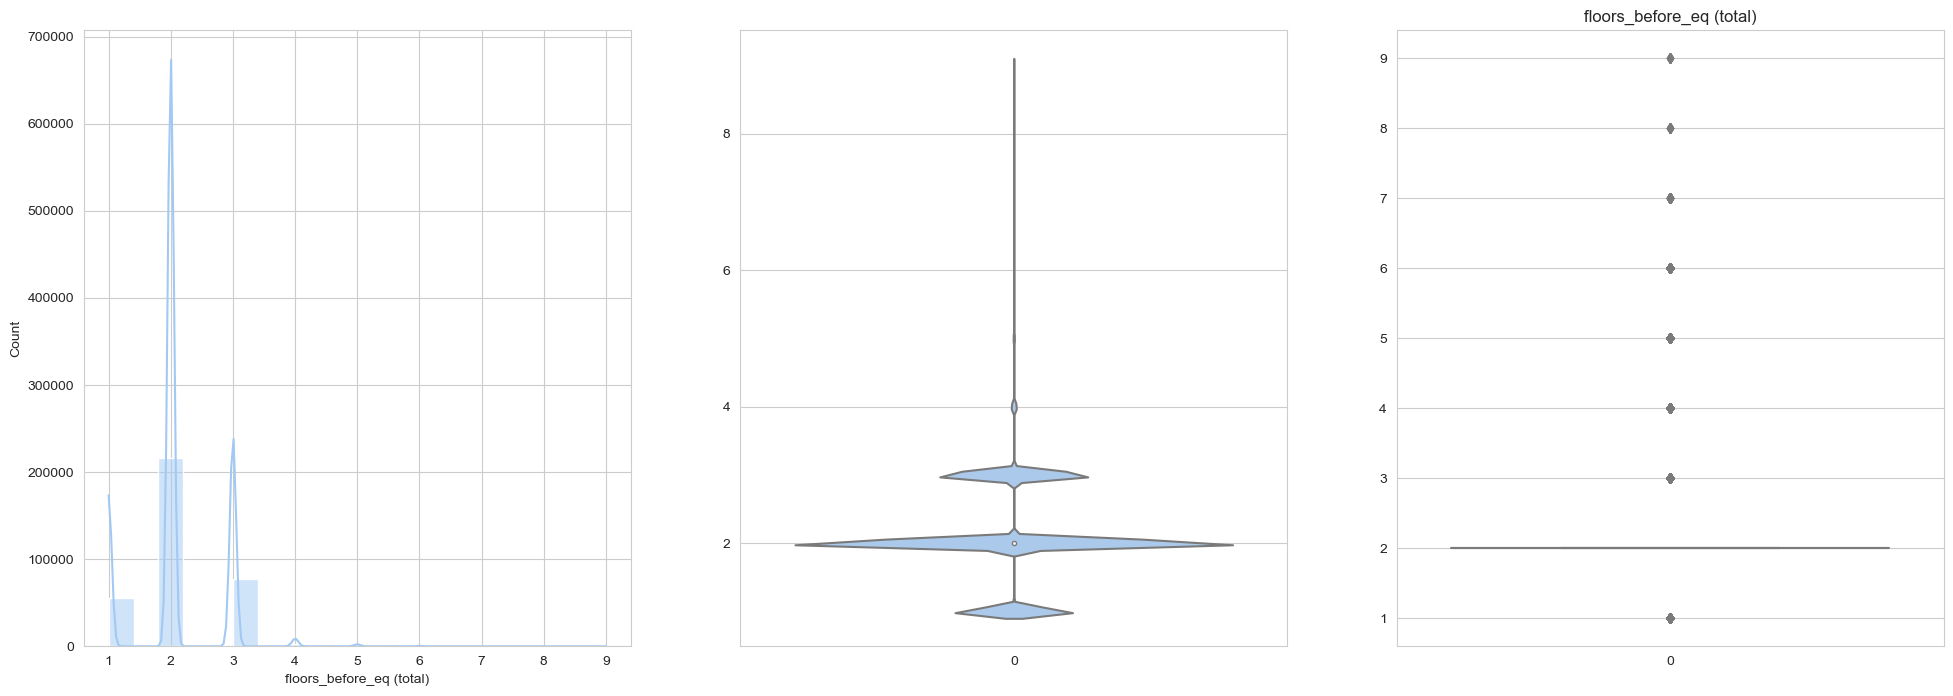

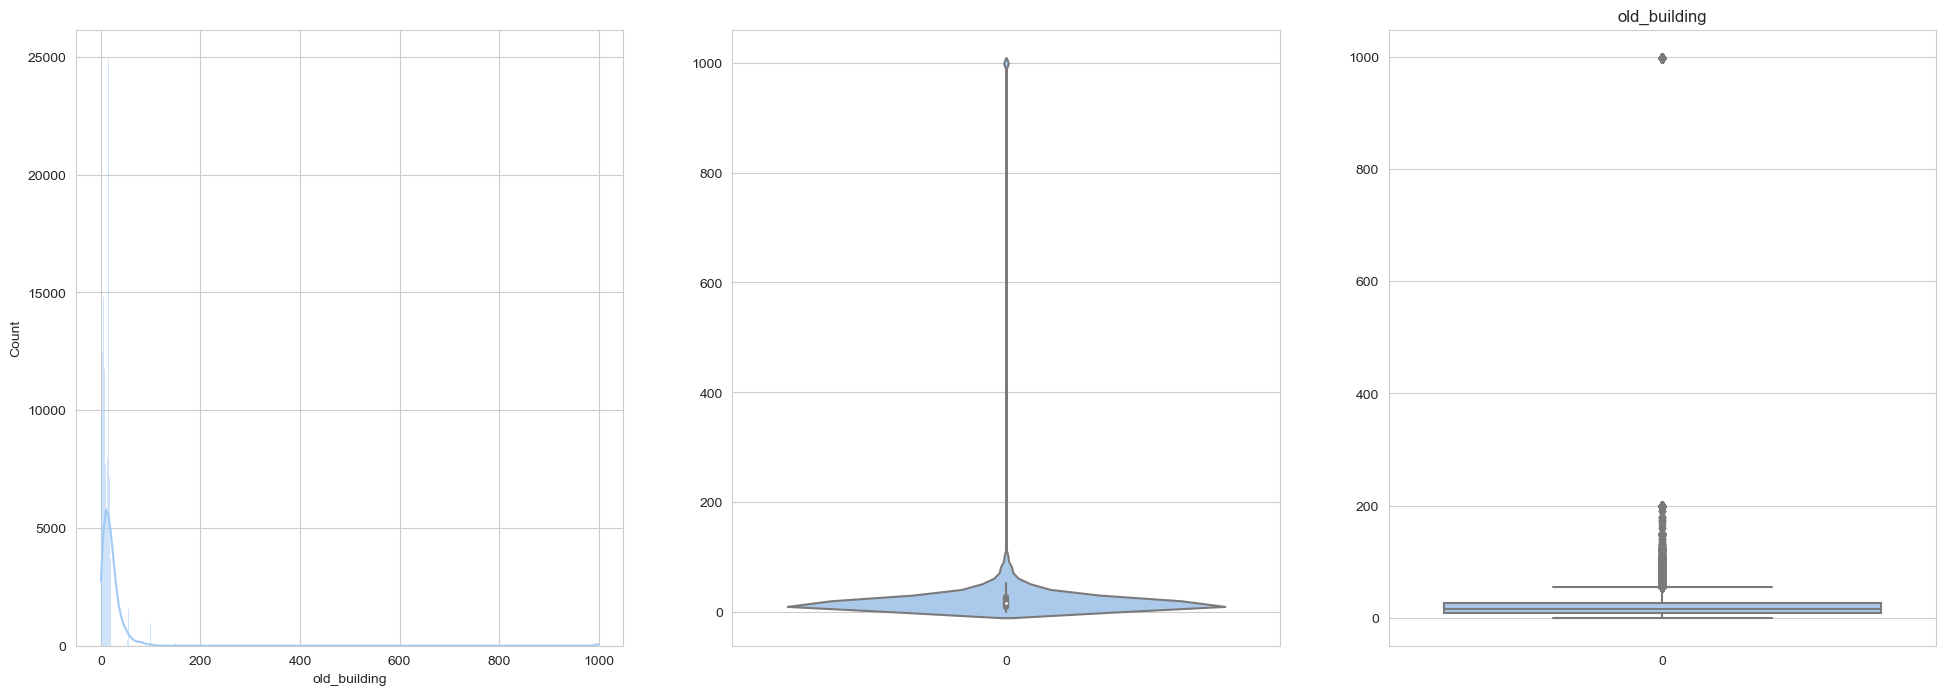

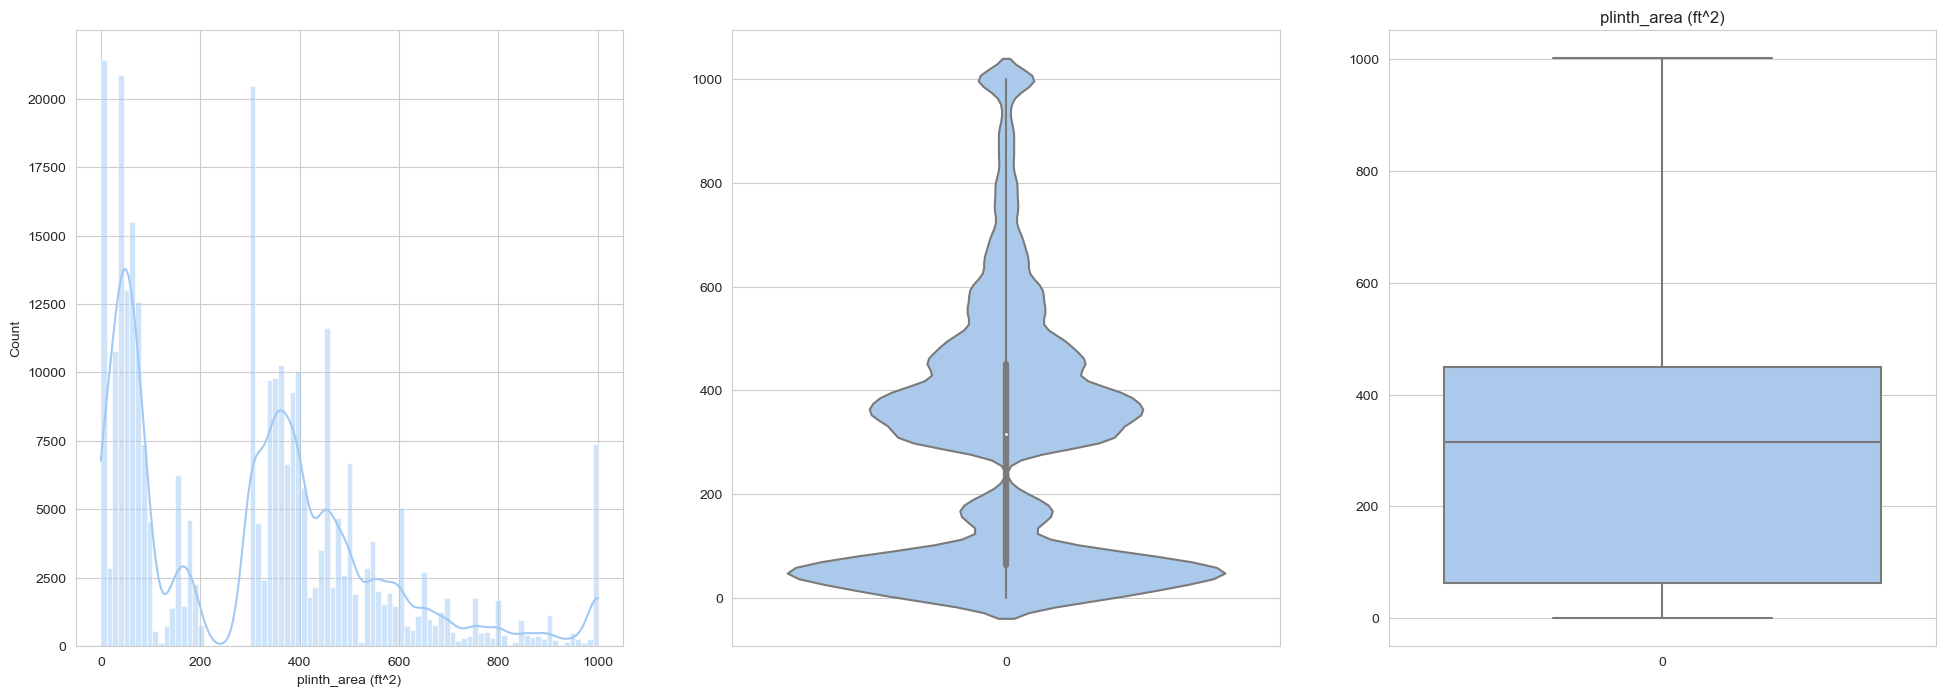

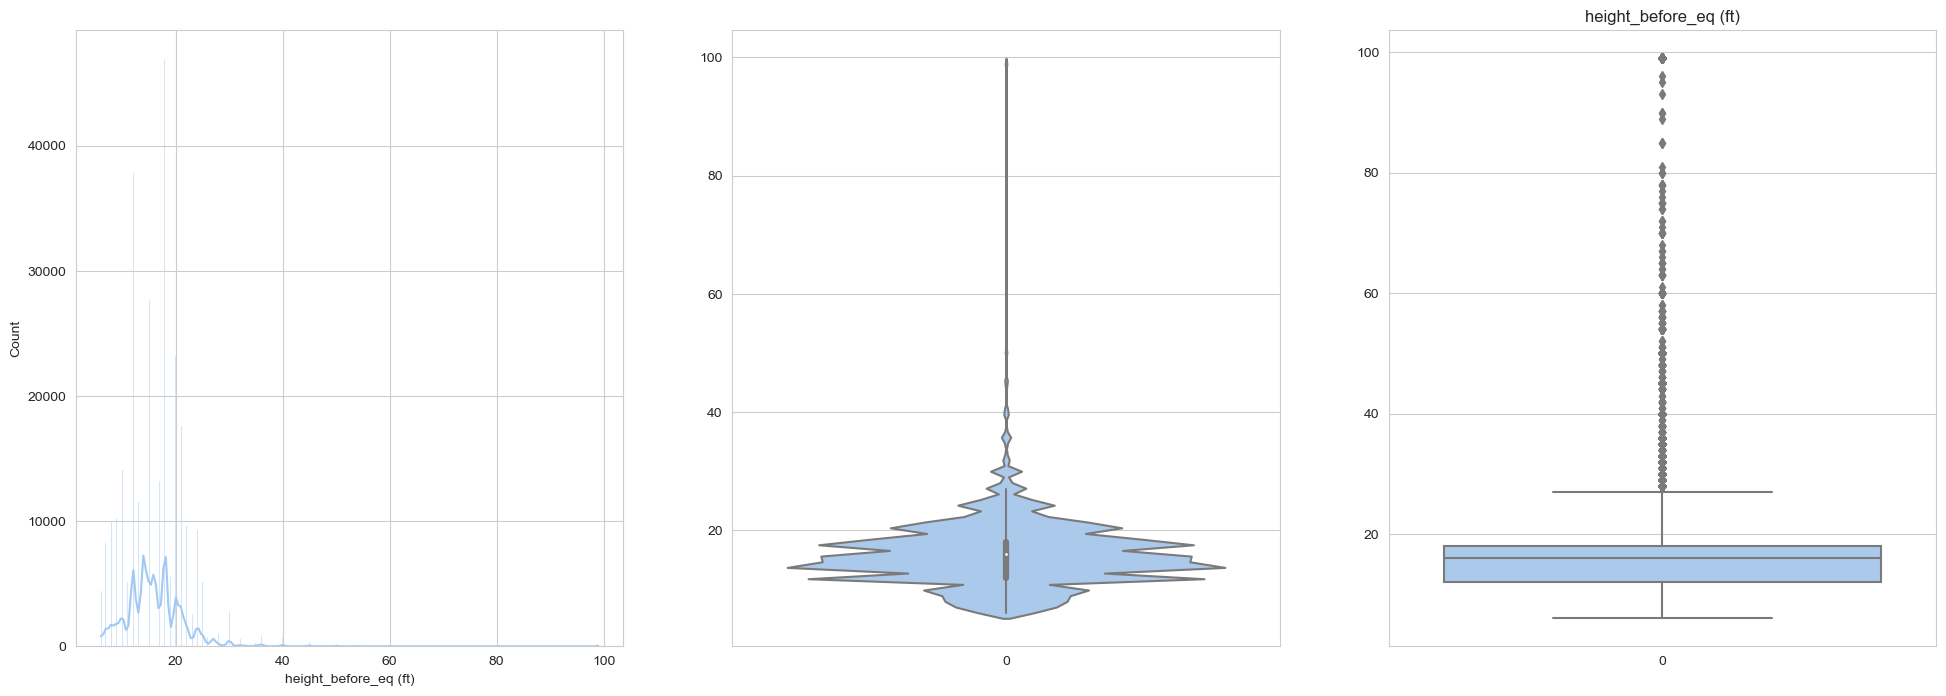

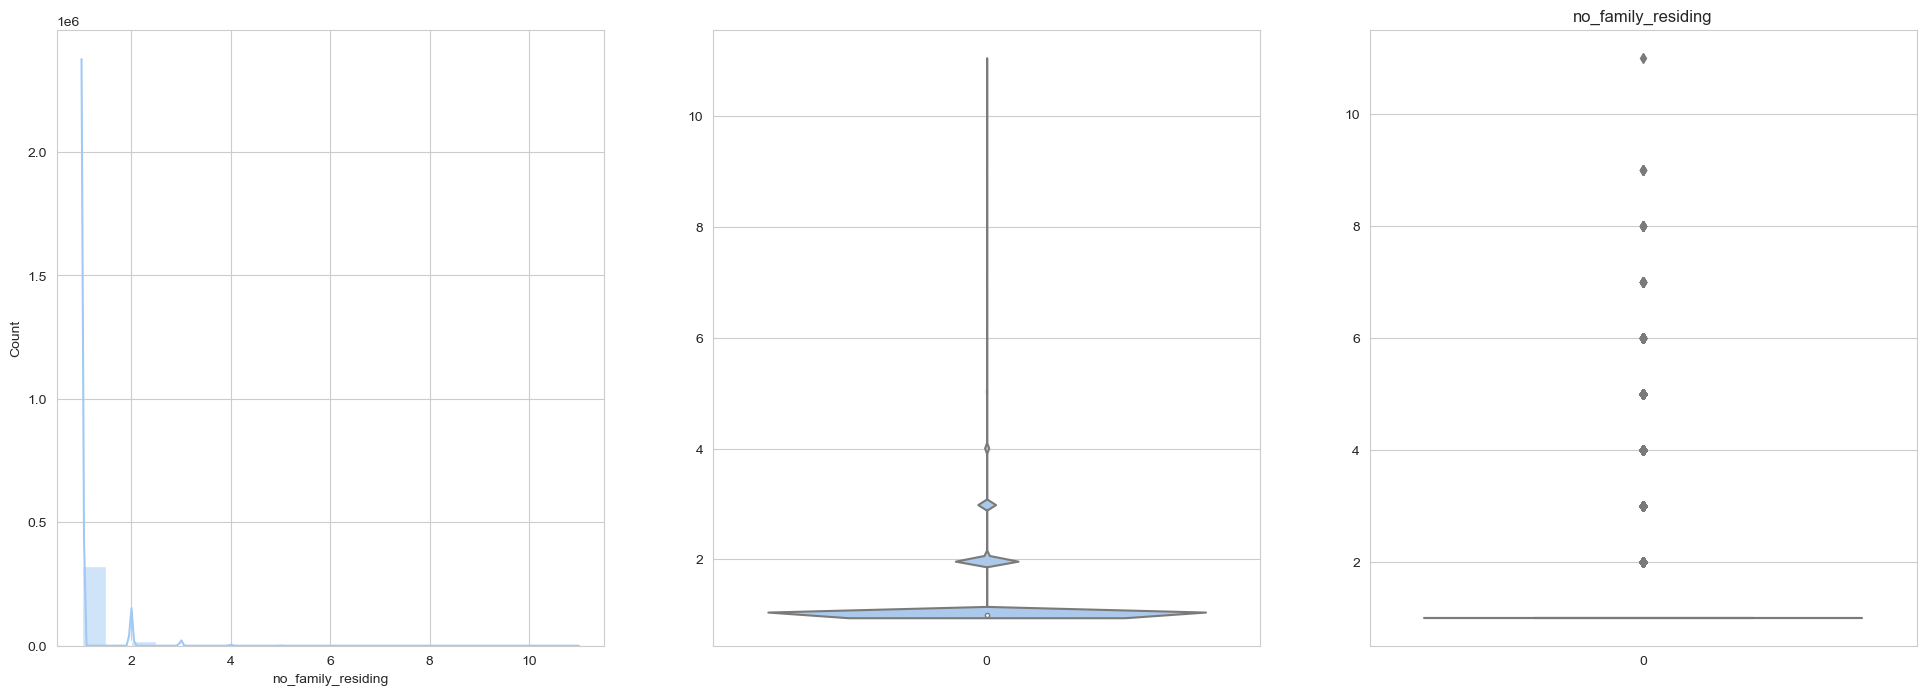

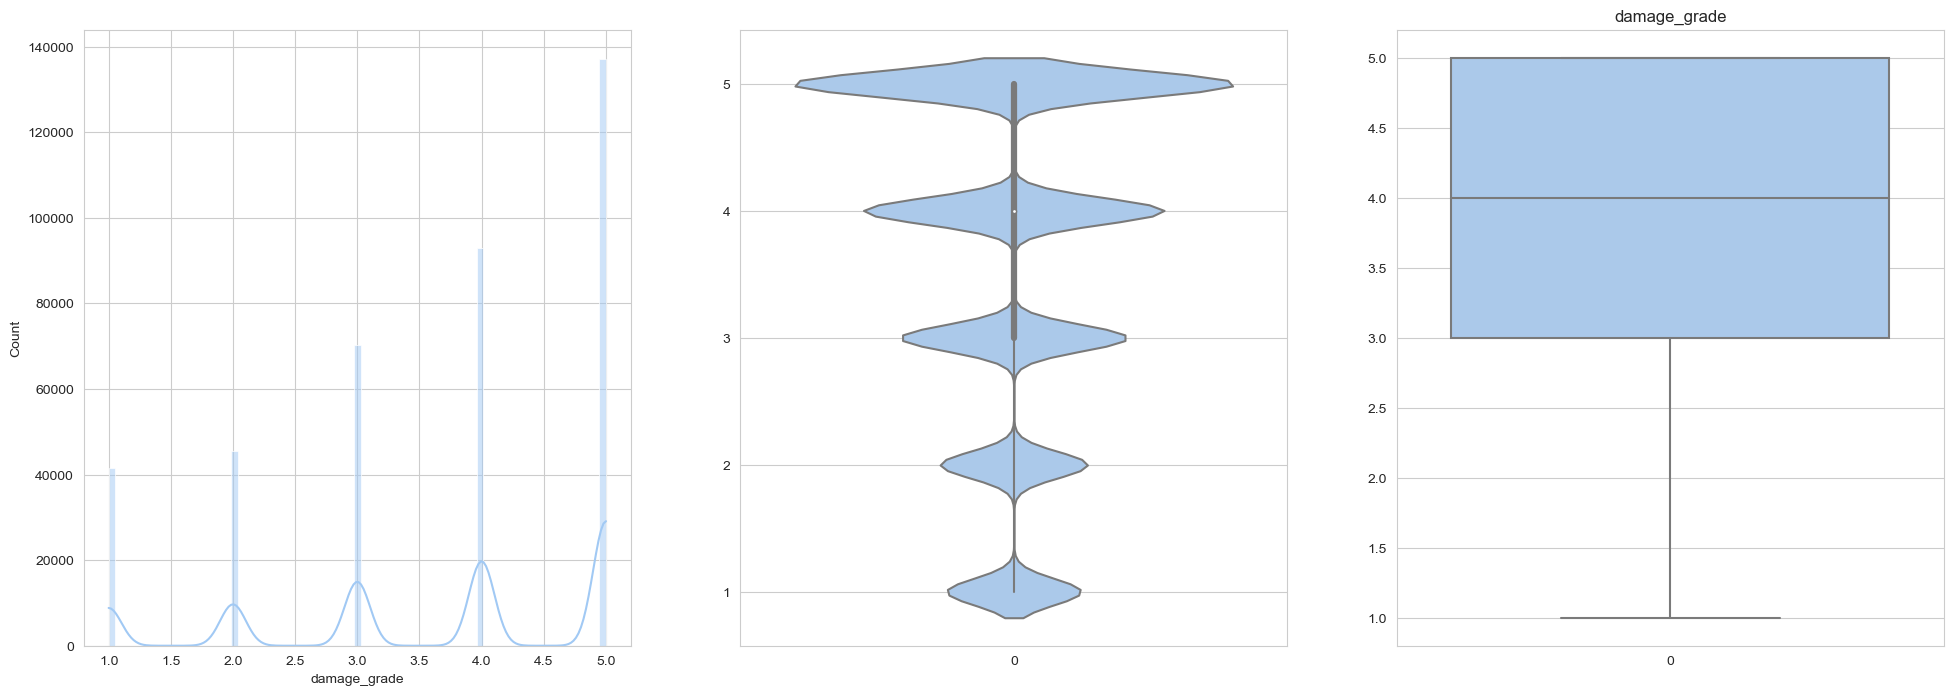

In [49]:
plotHVB(numerikData)


### Kategorikal



#### Count Plot



In [41]:
def plotBP(df):
    for col in df.select_dtypes(include='object'):
        if df[col].nunique() <= 22:
            _, axs = plt.subplots(ncols=2, figsize=(18, 6))
            plt.title(col)
            sns.countplot(y=col, data=df, ax=axs[0])
            axs[1] = pieChart(df, col)
            plt.show()


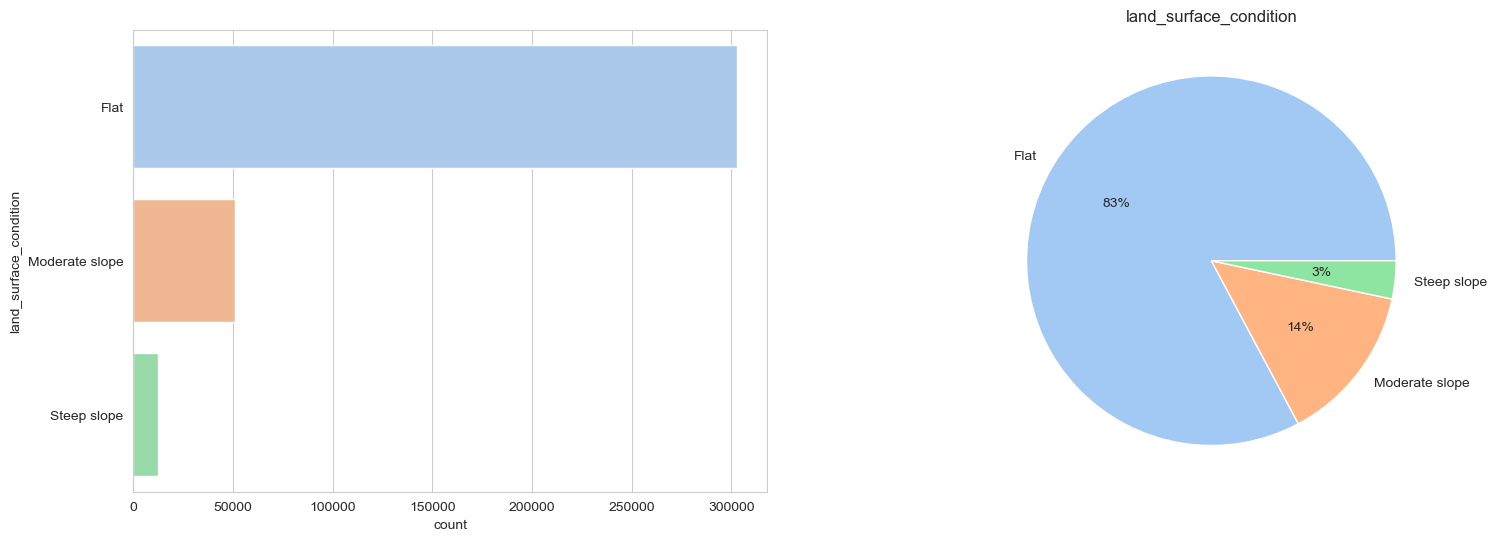

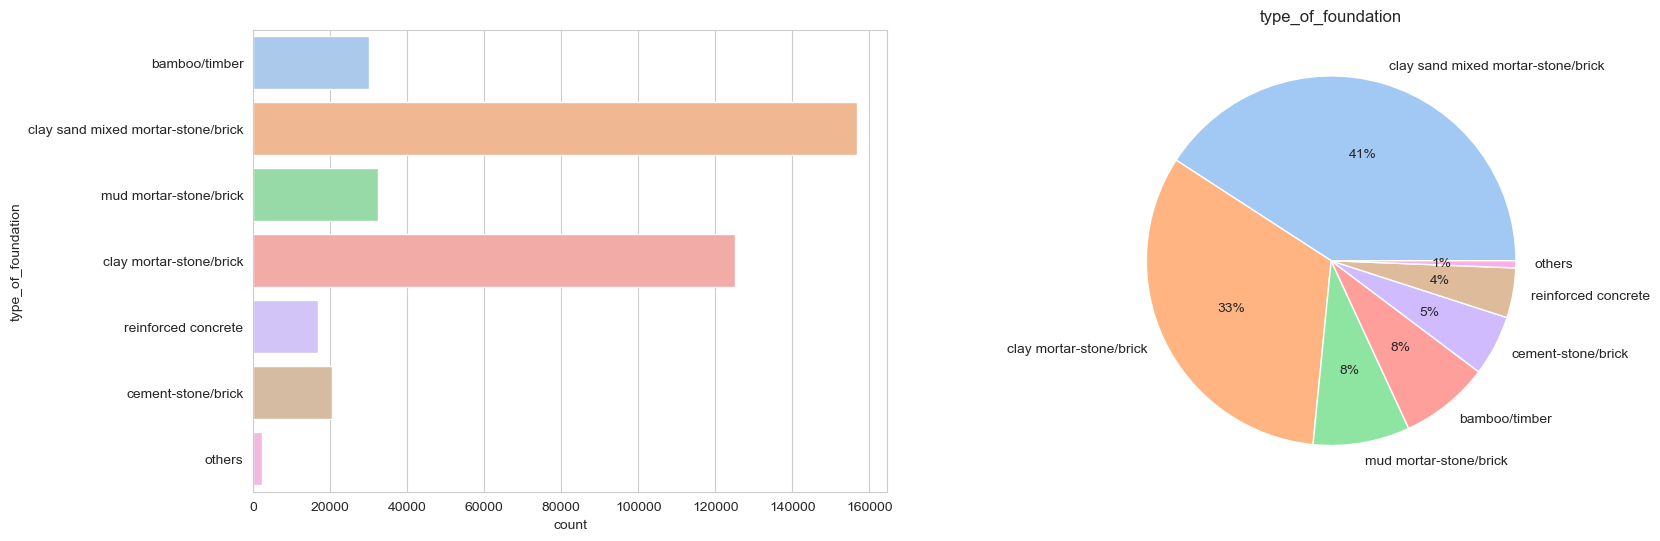

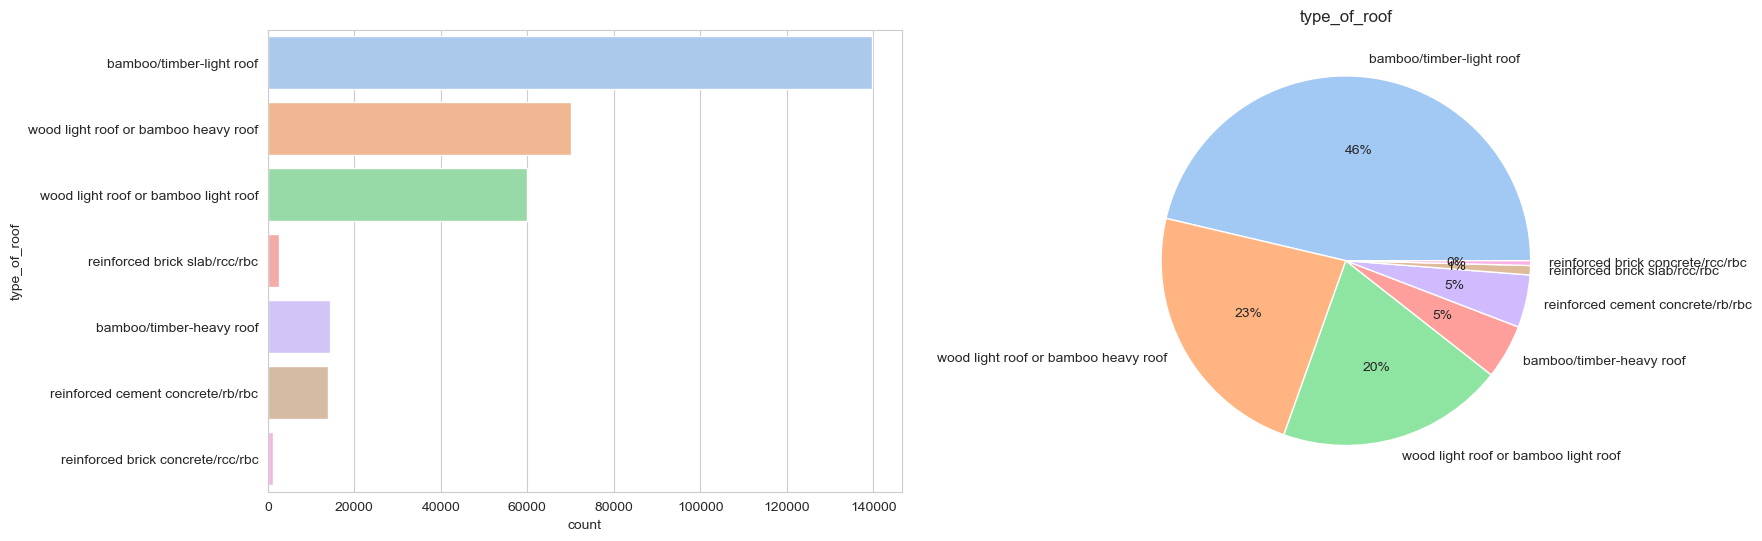

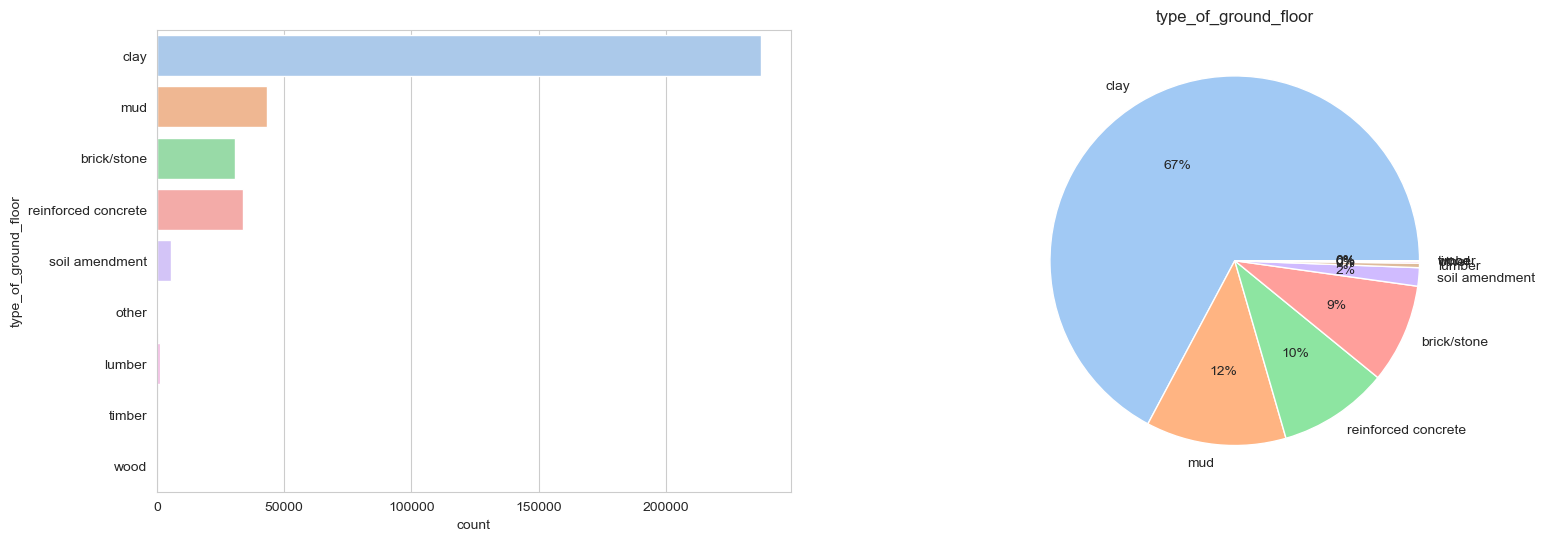

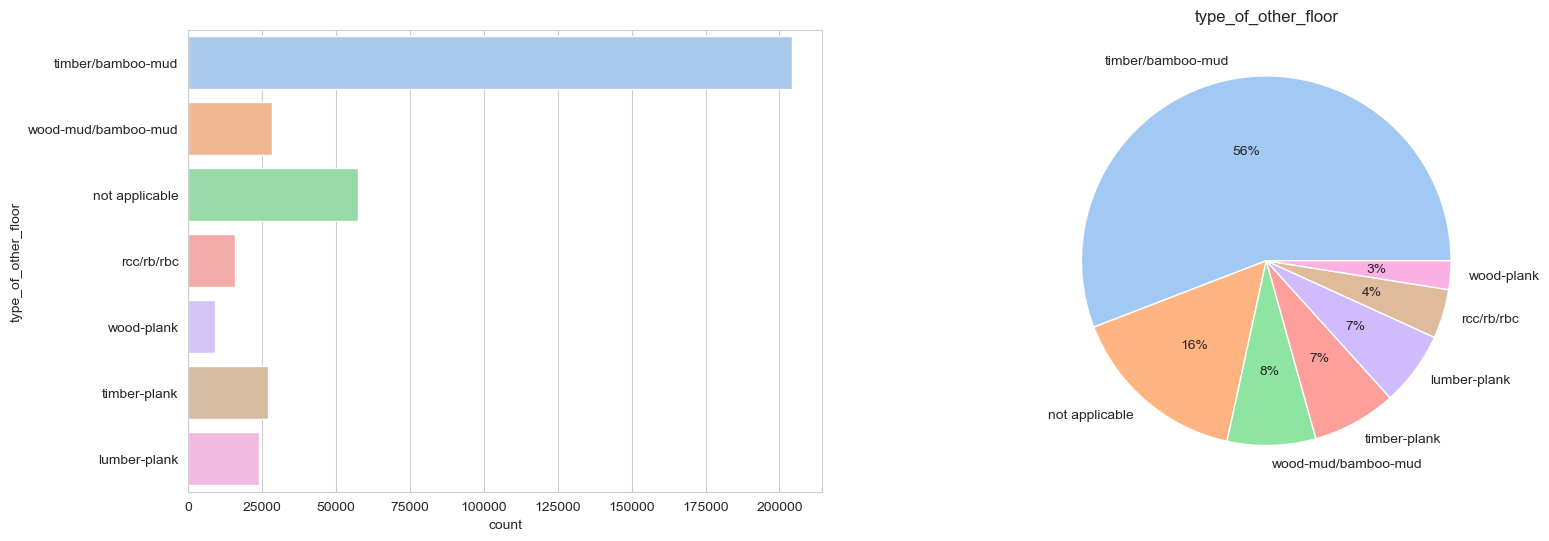

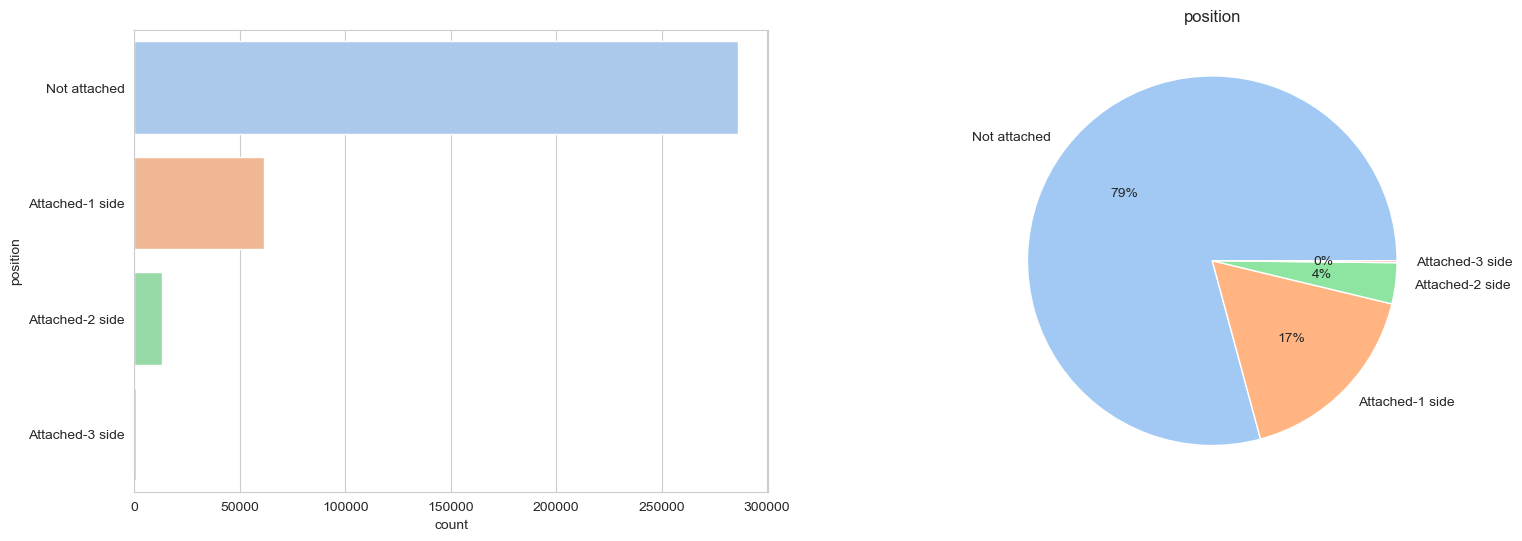

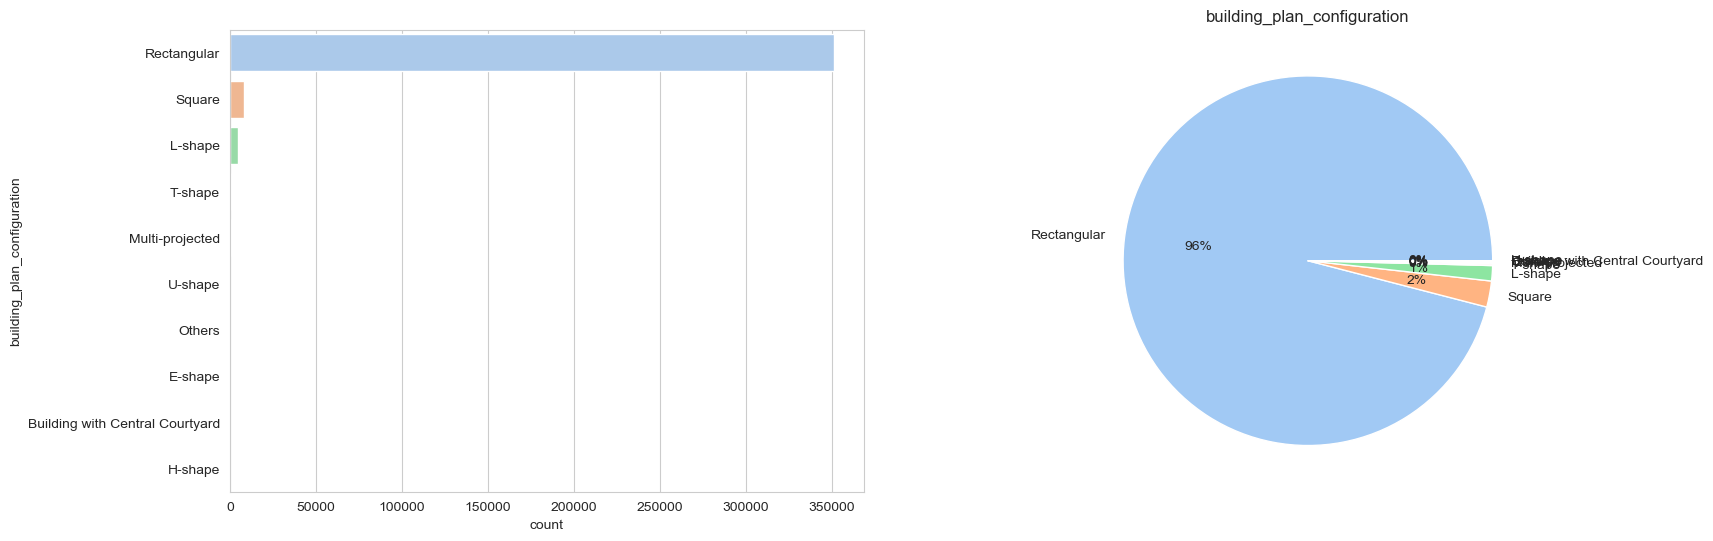

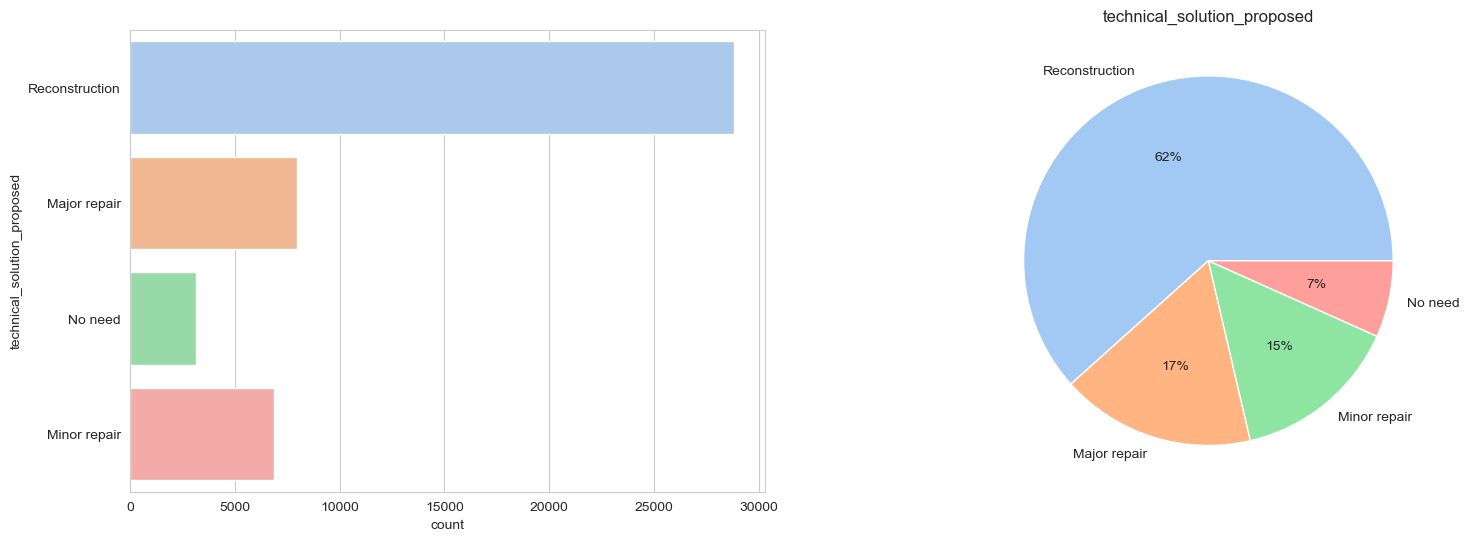

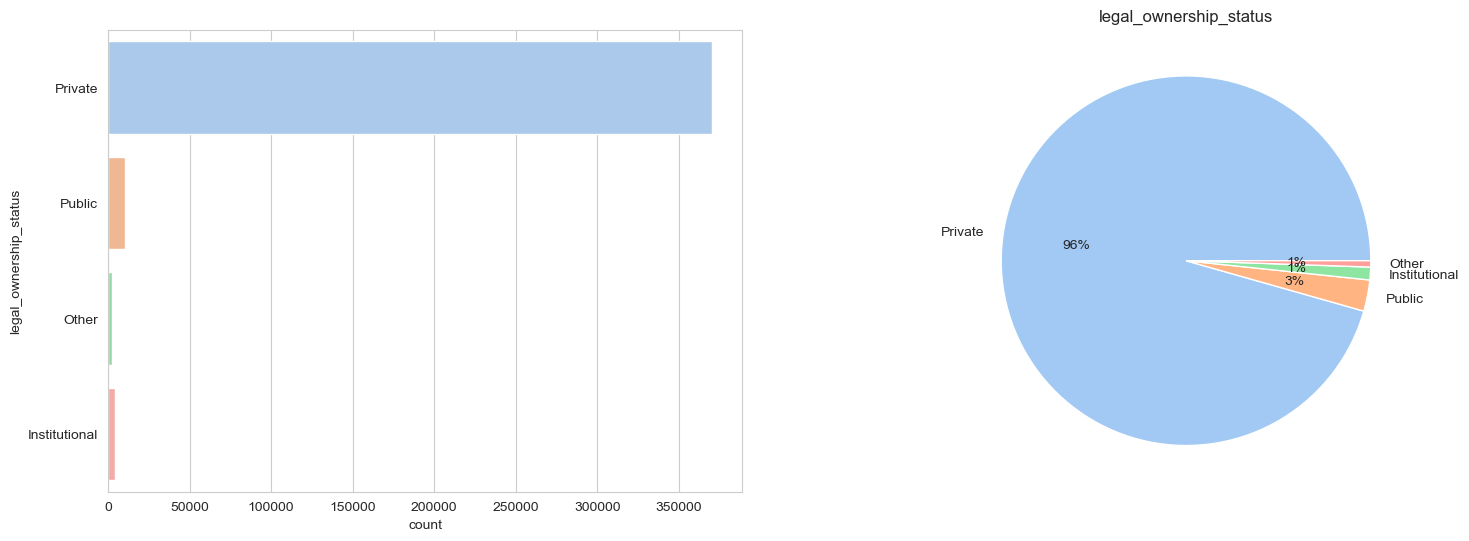

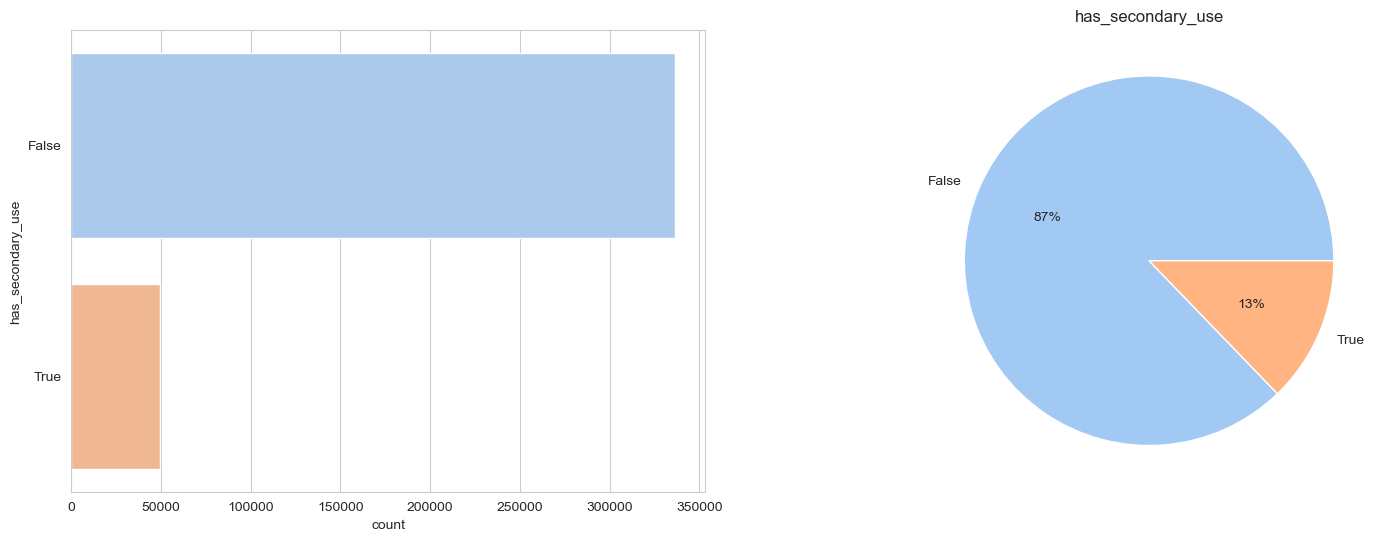

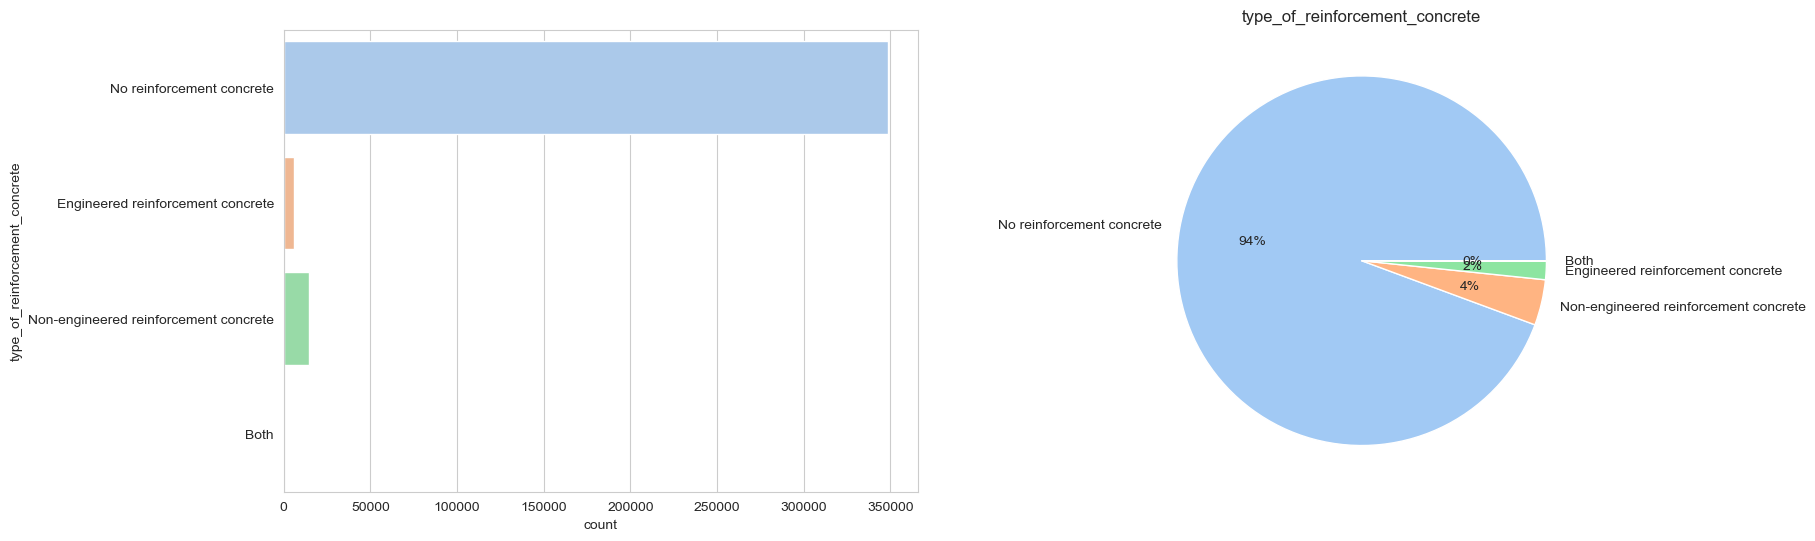

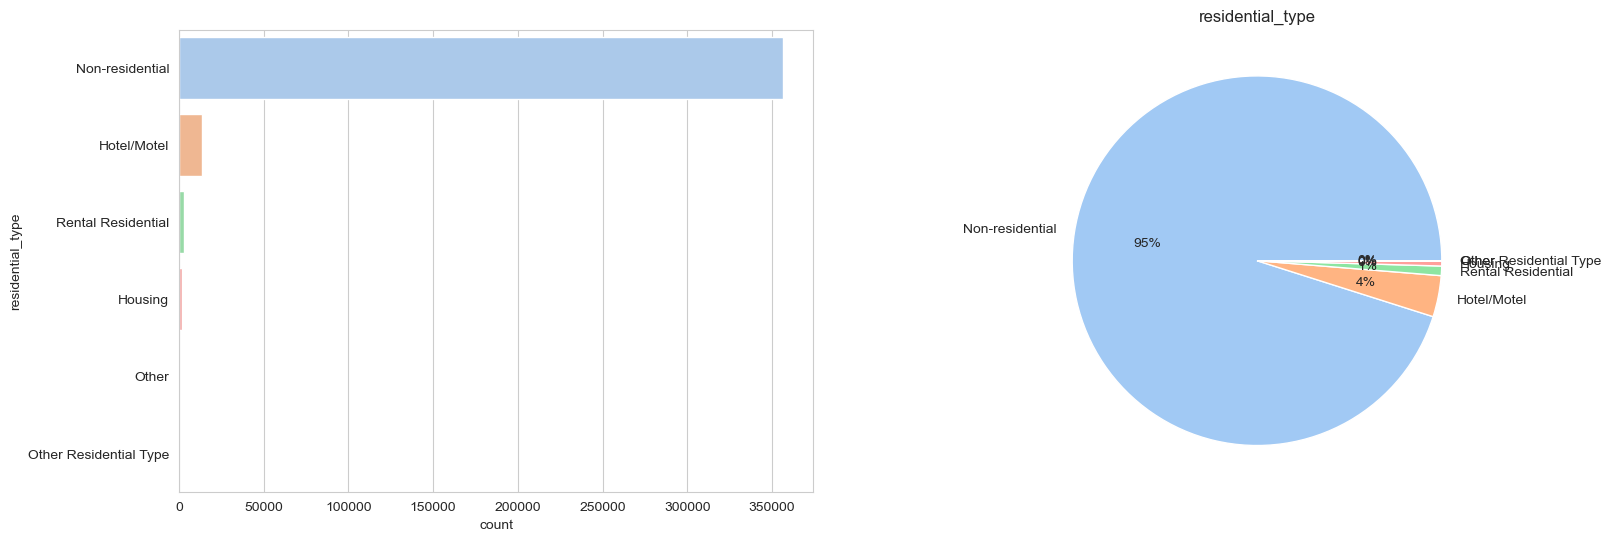

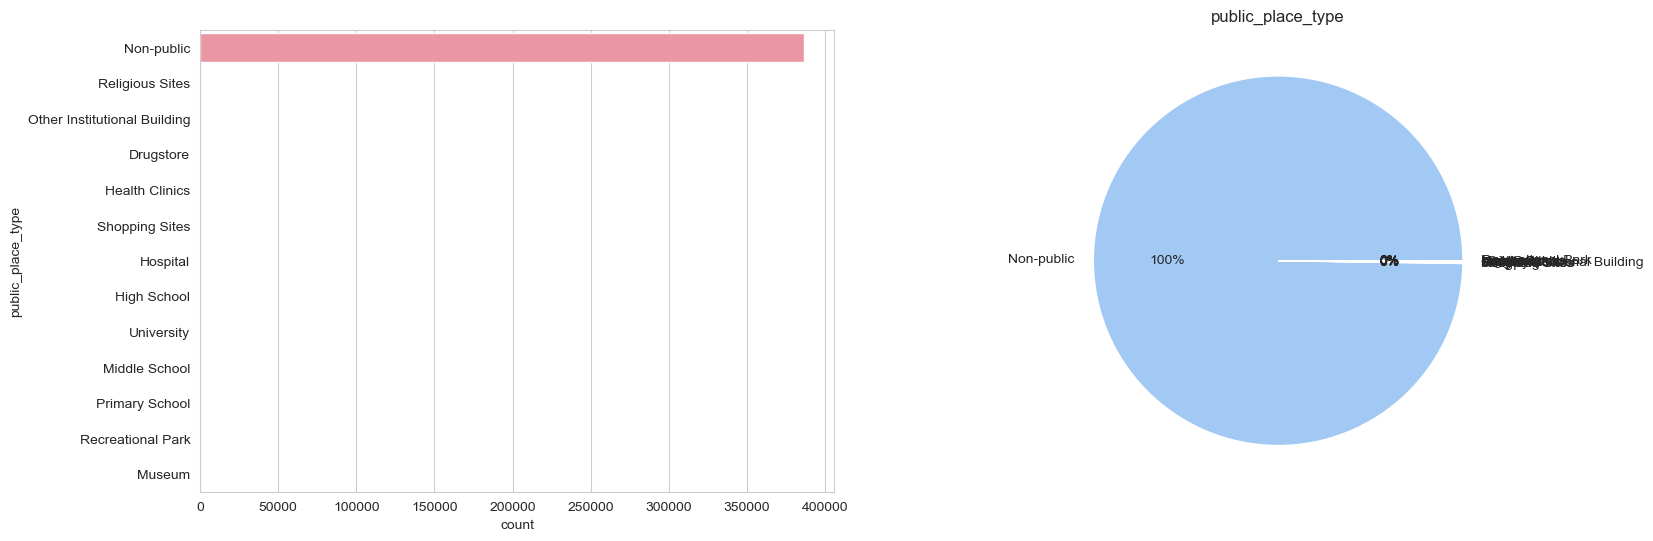

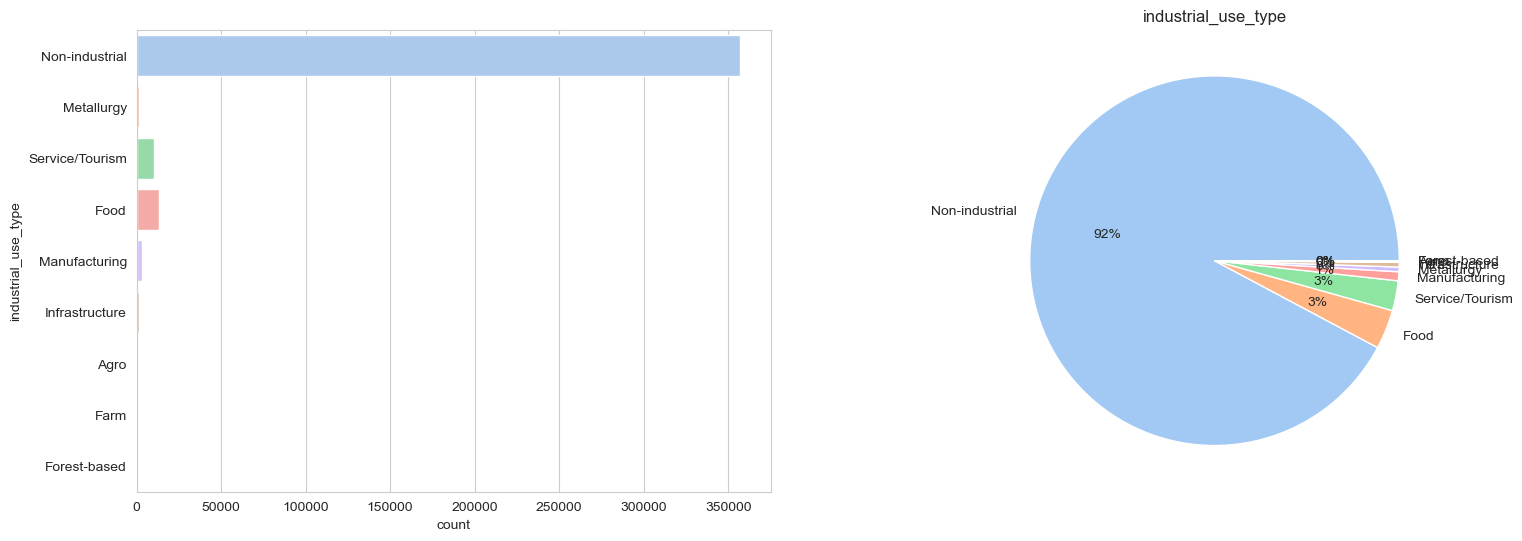

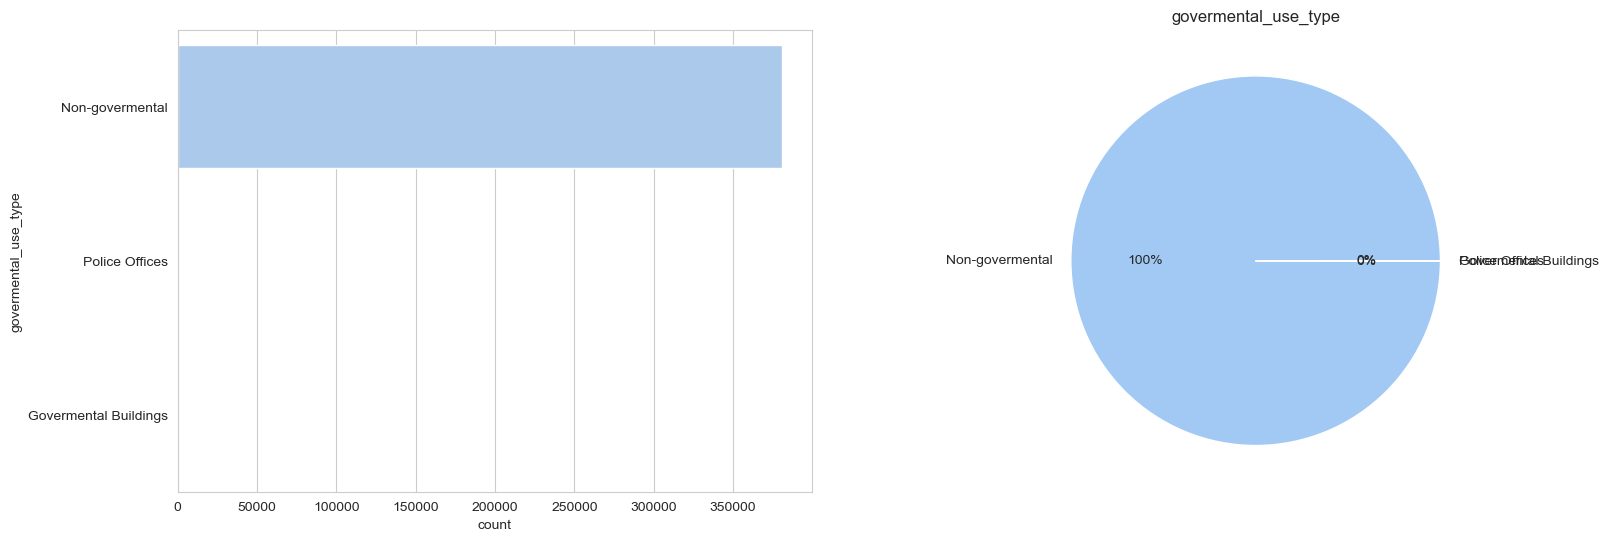

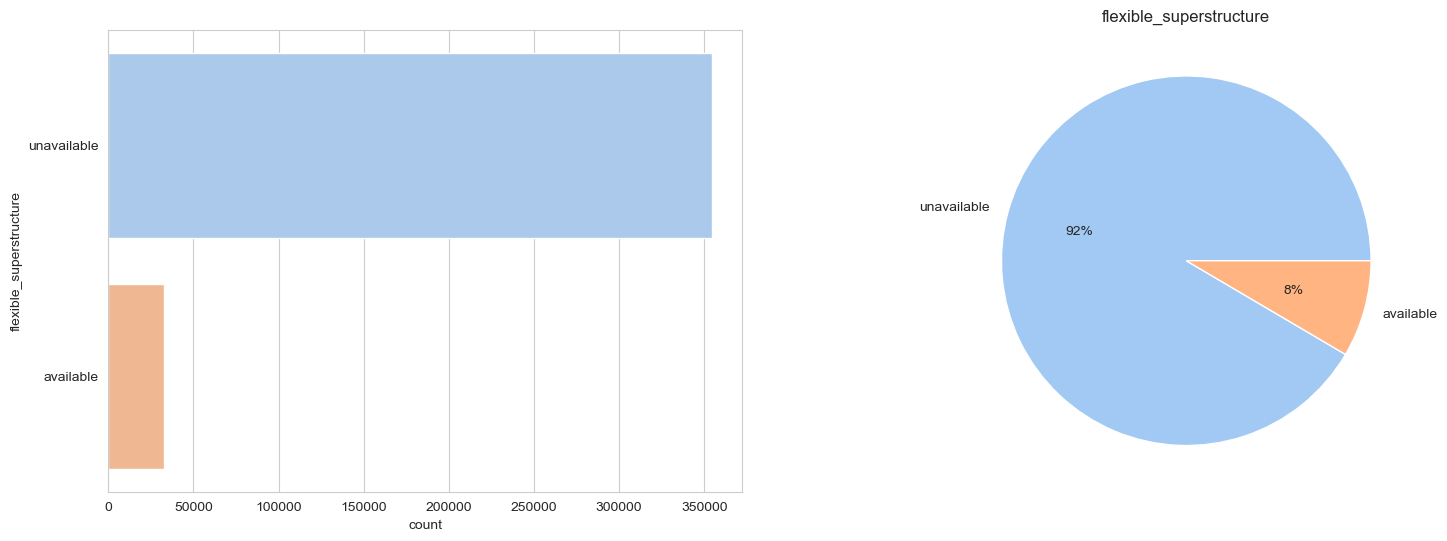

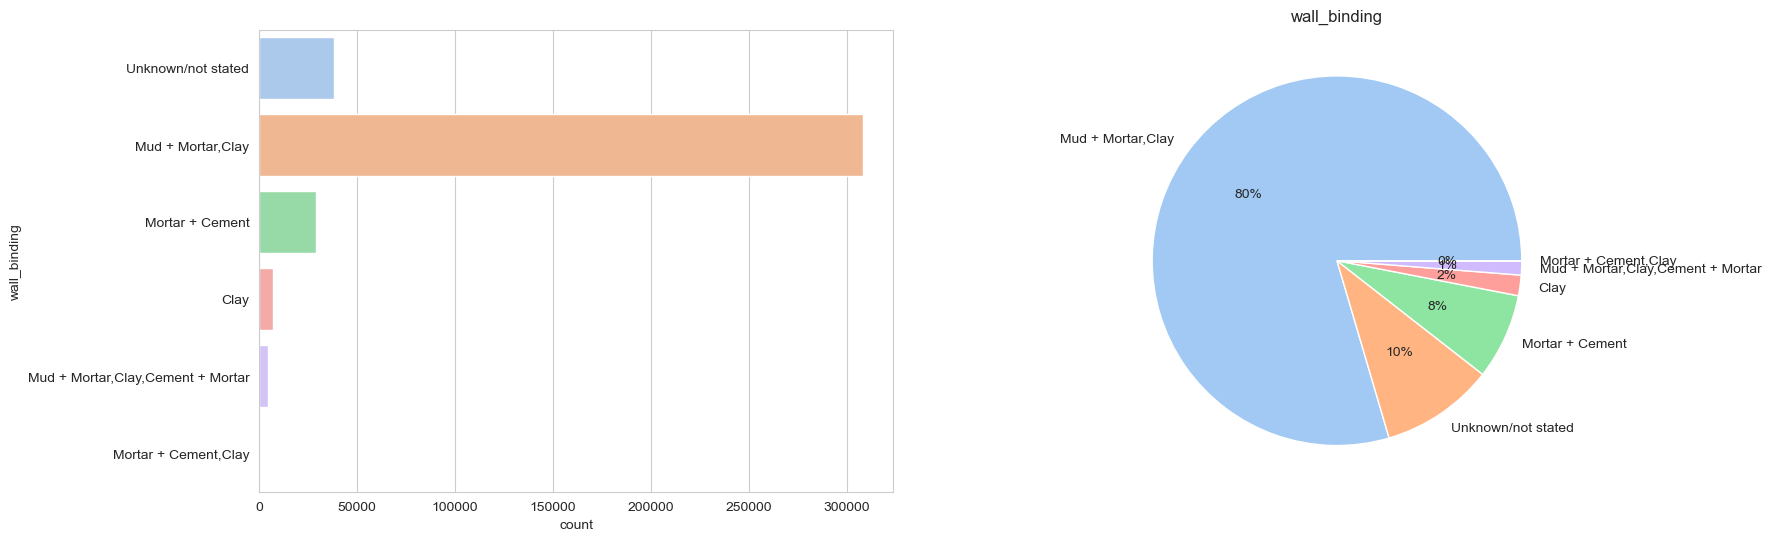

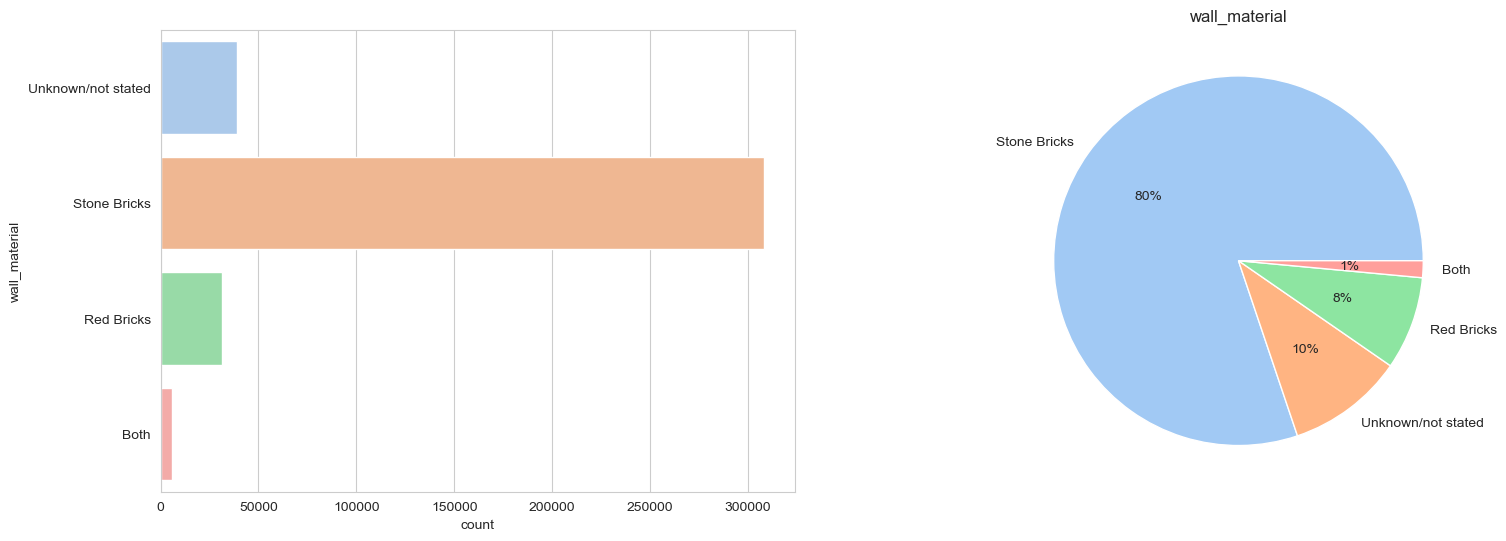

In [42]:
plotBP(df_cl)


## Bivariate Analysis



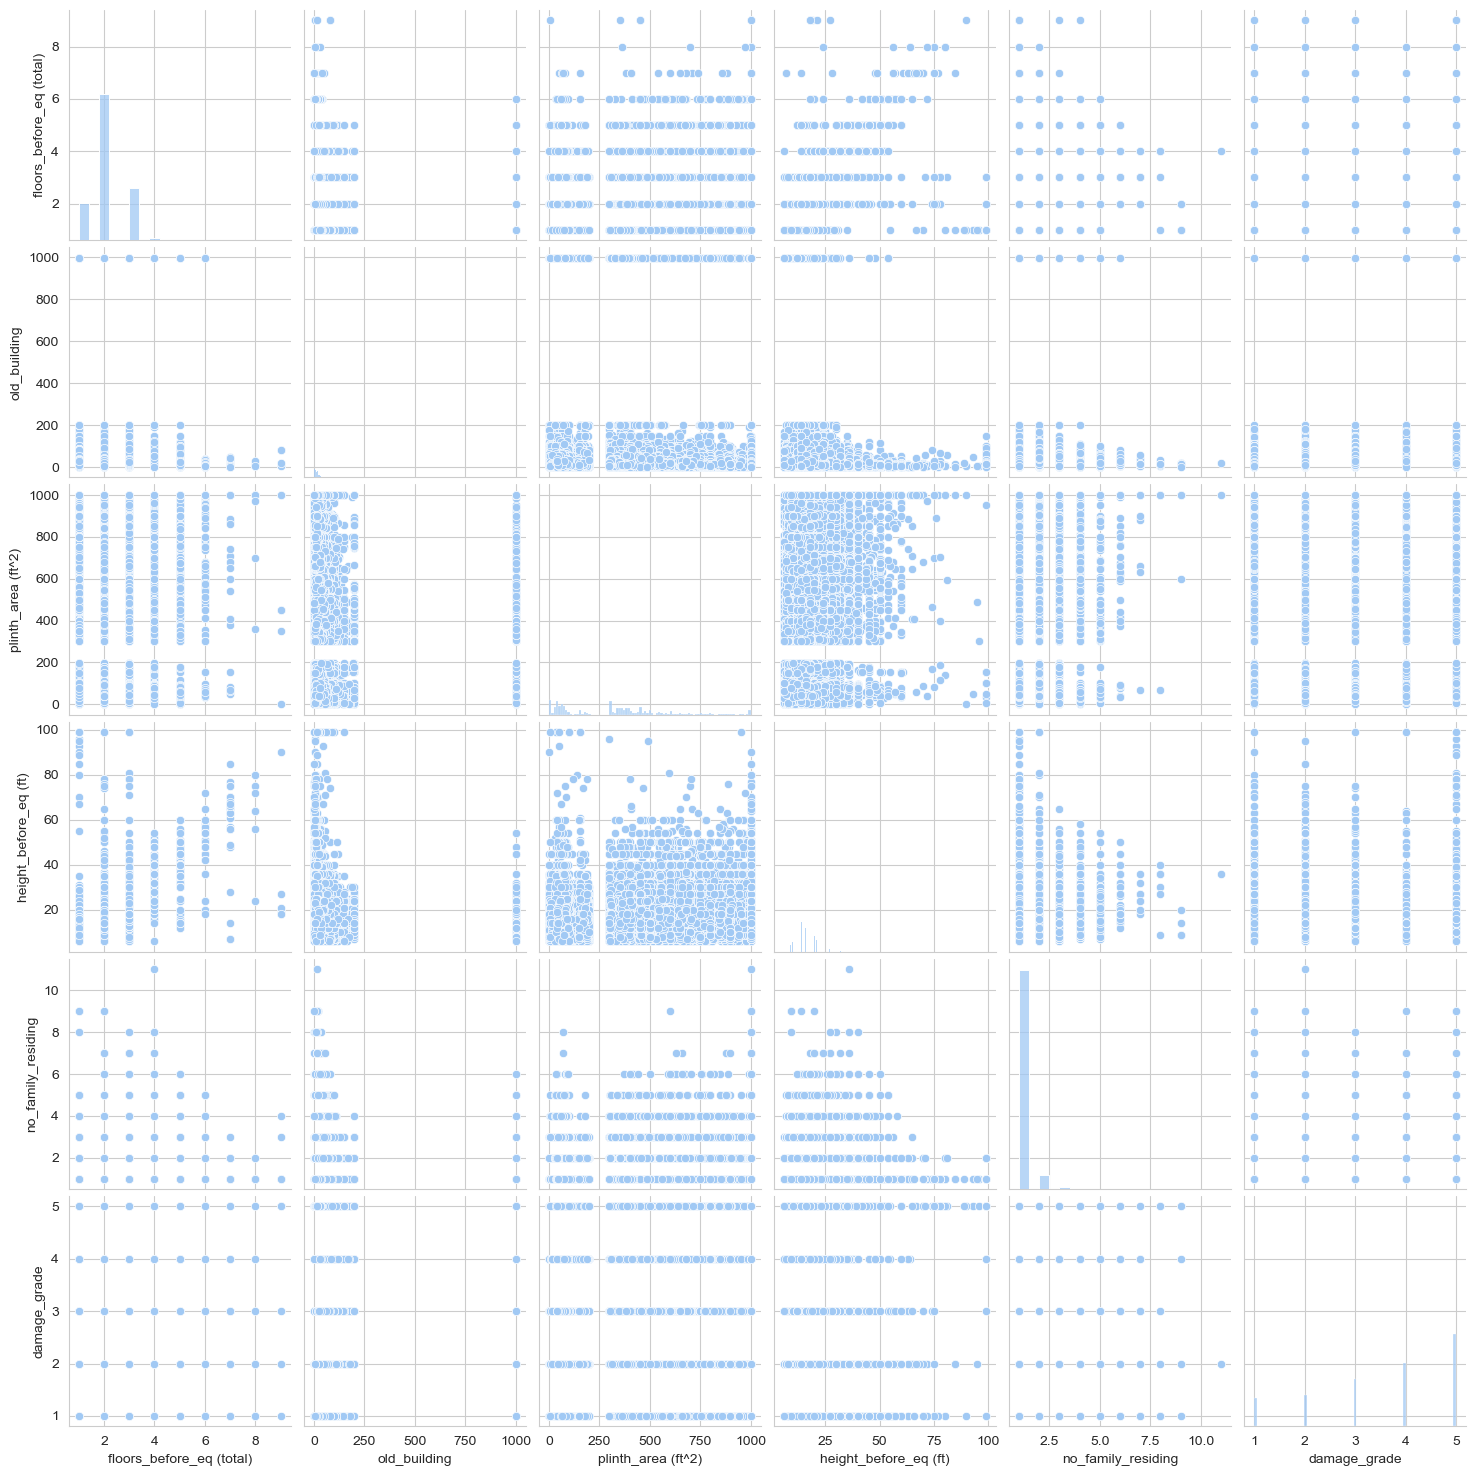

In [43]:
sns.pairplot(df_cl)


#### Pearson Corr



<Axes: >

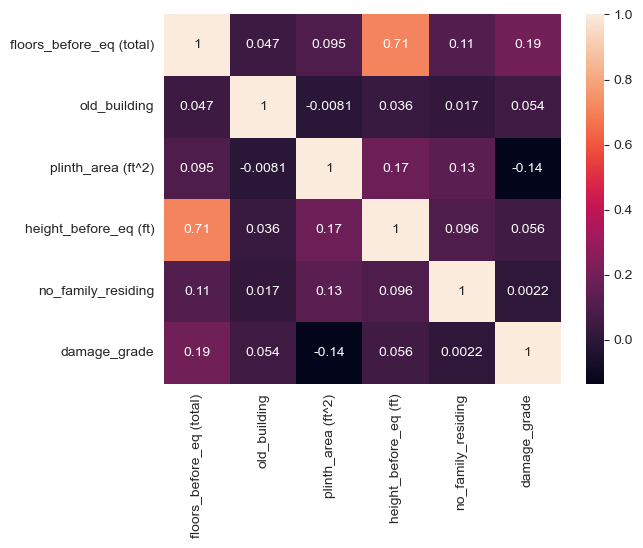

In [44]:
sns.heatmap(df_cl.select_dtypes(exclude='object').corr(), annot=True)


Multicollinearity residing between height_before_eq (ft) and floors_before_eq(total) we can drop height feature



Probably could bin all this values



#### Chi2



In [45]:
def chi2Matrix(df, columns=None):
    matrix = df.copy().select_dtypes(include=['object'])
    if columns:
        matrix = matrix[columns]

    column_names = matrix.columns
    chisqmatrix = pd.DataFrame(data=[(0 for i in range(len(matrix.columns))) for i in range(len(matrix.columns))],
                               columns=column_names,
                               index=column_names)
    outercnt = 0
    innercnt = 0
    for icol in column_names:  # Outer loop
        for jcol in column_names:  # inner loop
            mycrosstab = pd.crosstab(matrix[icol], matrix[jcol])
            stat, p, dof, expected = stats.chi2_contingency(mycrosstab)
            chisqmatrix.iloc[outercnt, innercnt] = round(p, 3)
            cntexpected = expected[expected < 5].size
            perexpected = ((expected.size-cntexpected)/expected.size)*100
            if perexpected < 20:
                chisqmatrix.iloc[outercnt, innercnt] = 2  # Assigning 2

            if icol == jcol:
                chisqmatrix.iloc[outercnt, innercnt] = 0.00
            innercnt = innercnt+1
        outercnt = outercnt+1
        innercnt = 0
    return chisqmatrix


In [46]:
chi2matrix = chi2Matrix(df_cl)


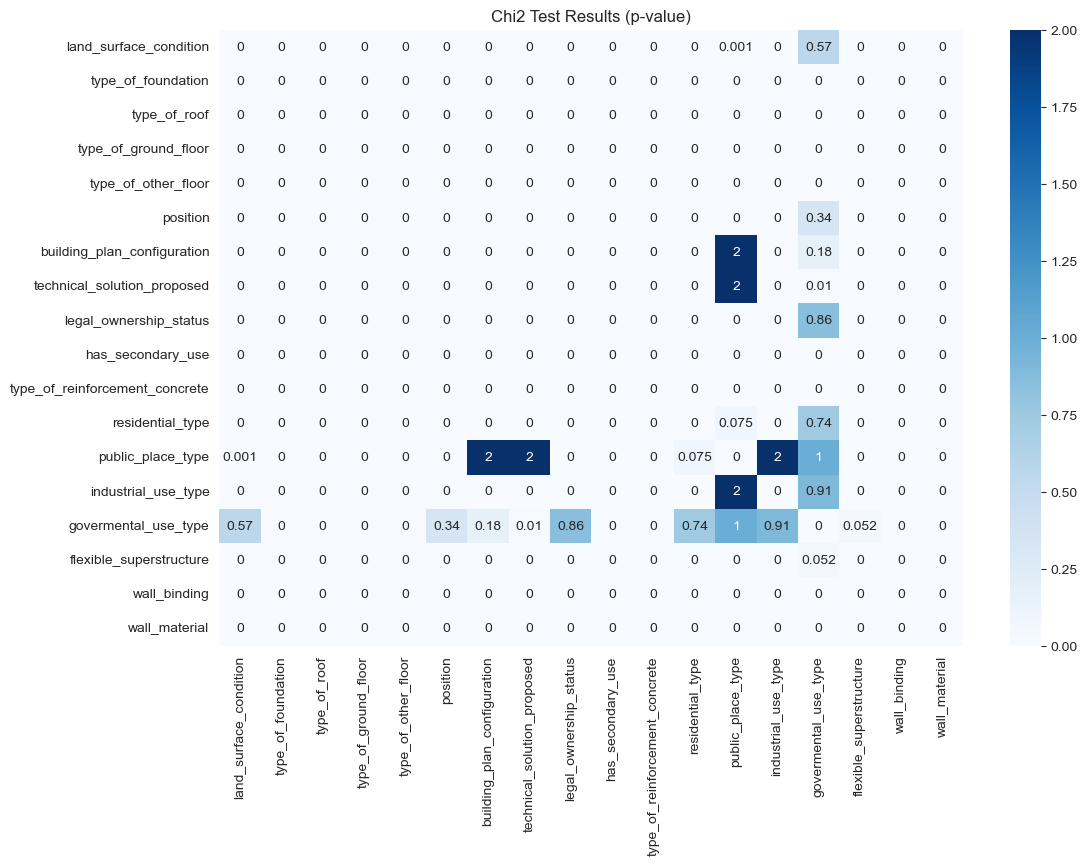

In [47]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(chi2matrix, annot=True, cmap='Blues')
plt.title('Chi2 Test Results (p-value)')
plt.show()


#### Spearman Corr



In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def toOrdinal(df):
    df = df.copy().select_dtypes(include=['object'])
    columns = df.columns
    preprocessor = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OrdinalEncoder()
    )
    return pd.DataFrame(preprocessor.fit_transform(df), columns=columns)


In [49]:
df_cat_enc = toOrdinal(df_cl)
df_cat_enc['damage_grade'] = df_cl['damage_grade']


<Axes: >

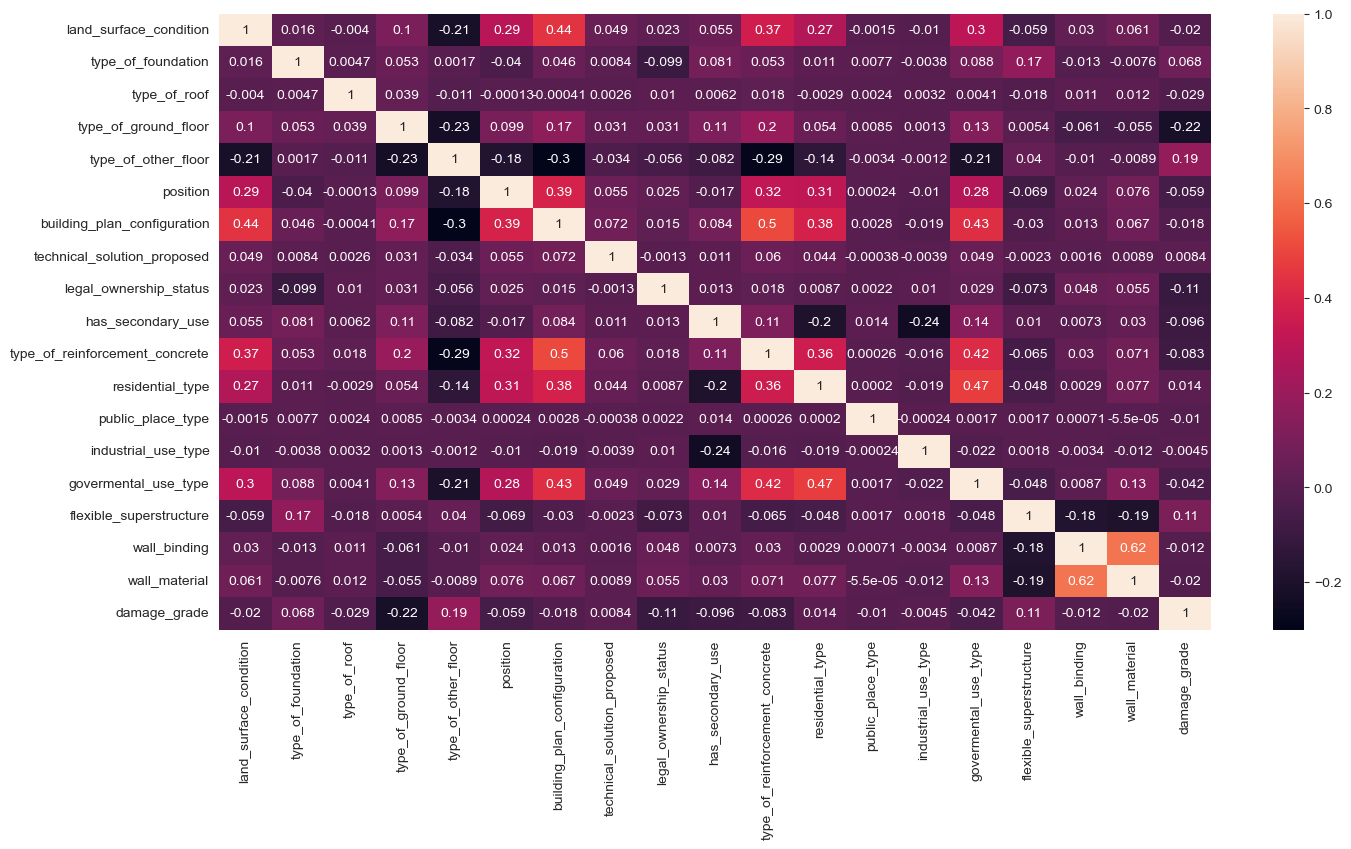

In [50]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_cat_enc.corr(method='spearman'), annot=True)


#### VIF



In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def vifValues(df):
    X = df.copy()
    vif_data = pd.DataFrame(index=X.columns)
    vif_data["VIF"] = [variance_inflation_factor(
        X.values, i) for i in range(len(X.columns))]
    return vif_data


In [52]:
VIF = vifValues(df_cat_enc)


<Axes: >

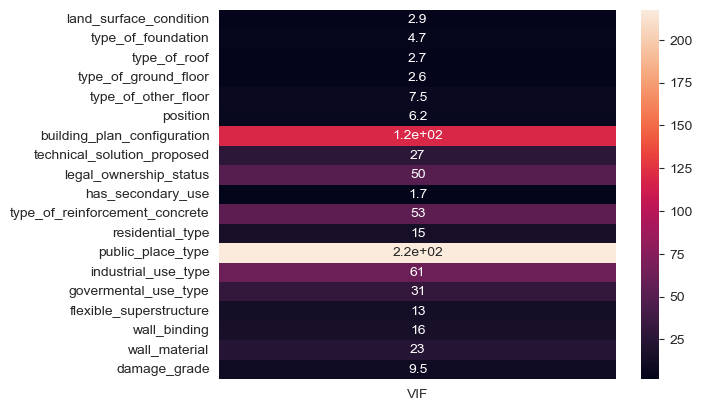

In [53]:
sns.heatmap(VIF, annot=True)


#### Categorical Facet



In [128]:
def countStack(df, target, col_wrap=3):
    for col in df.select_dtypes(exclude='object'):
        plt.figure(figsize=(12, 6))
        plt.title(col)
        sns.countplot(y=col, data=df, hue=target)
        plt.show()


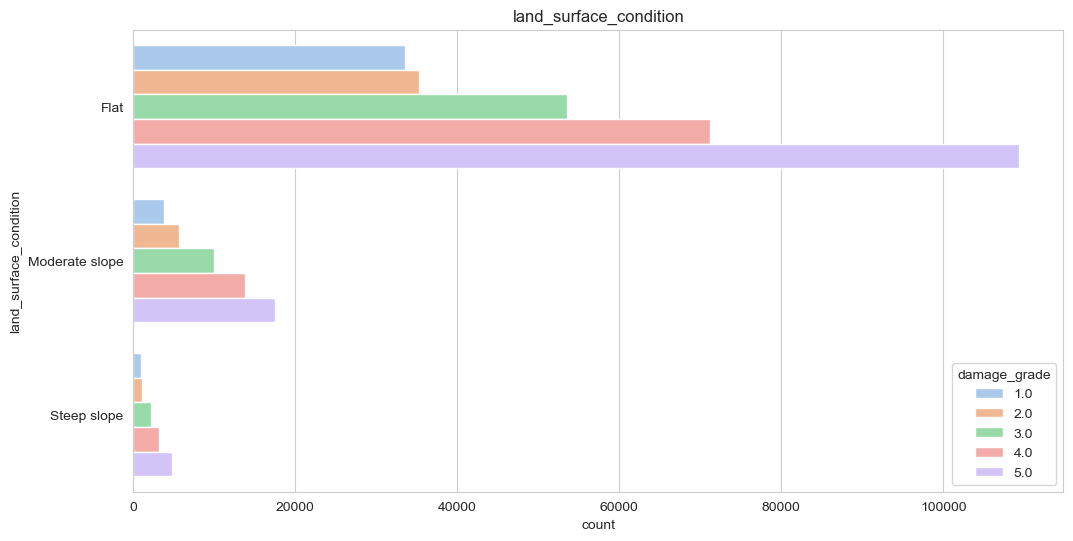

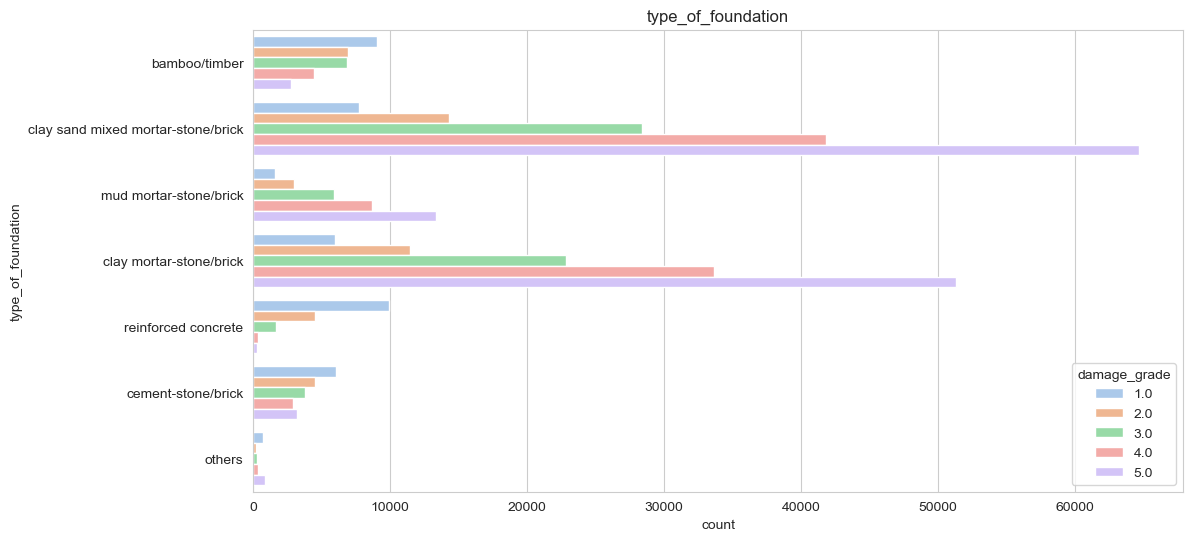

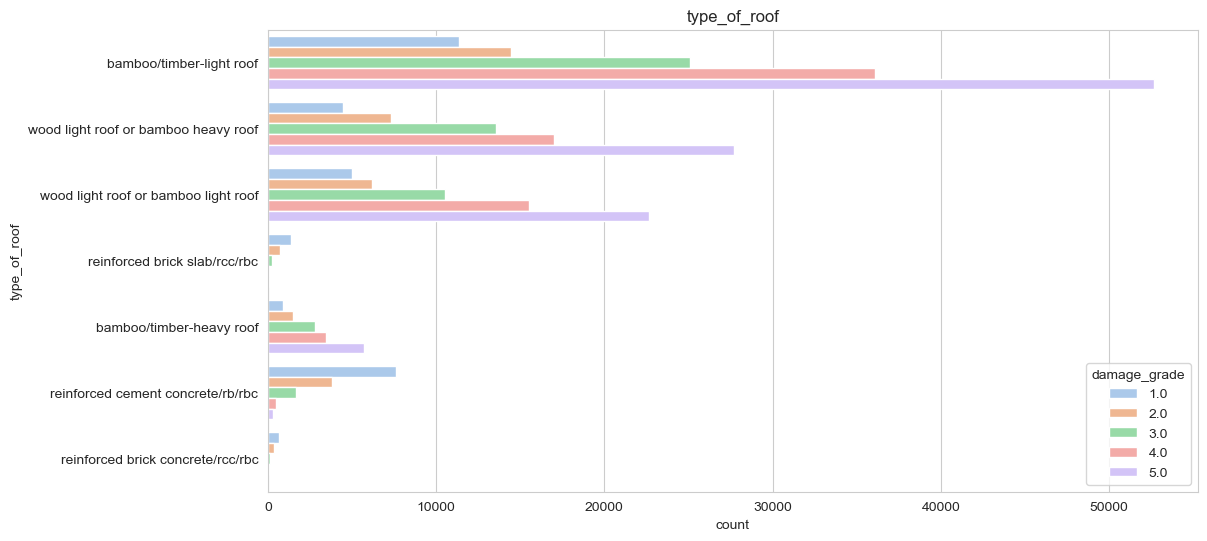

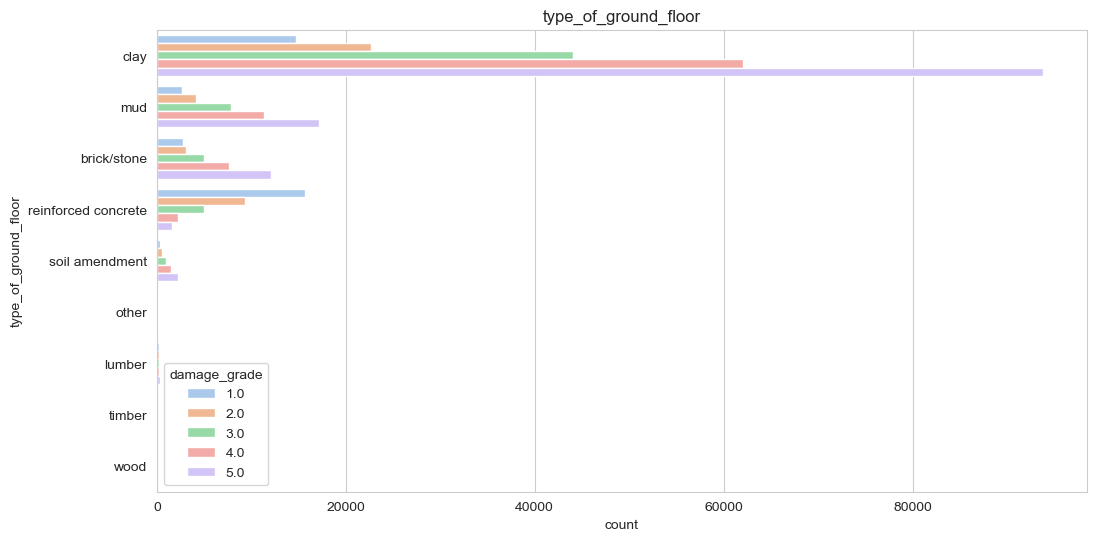

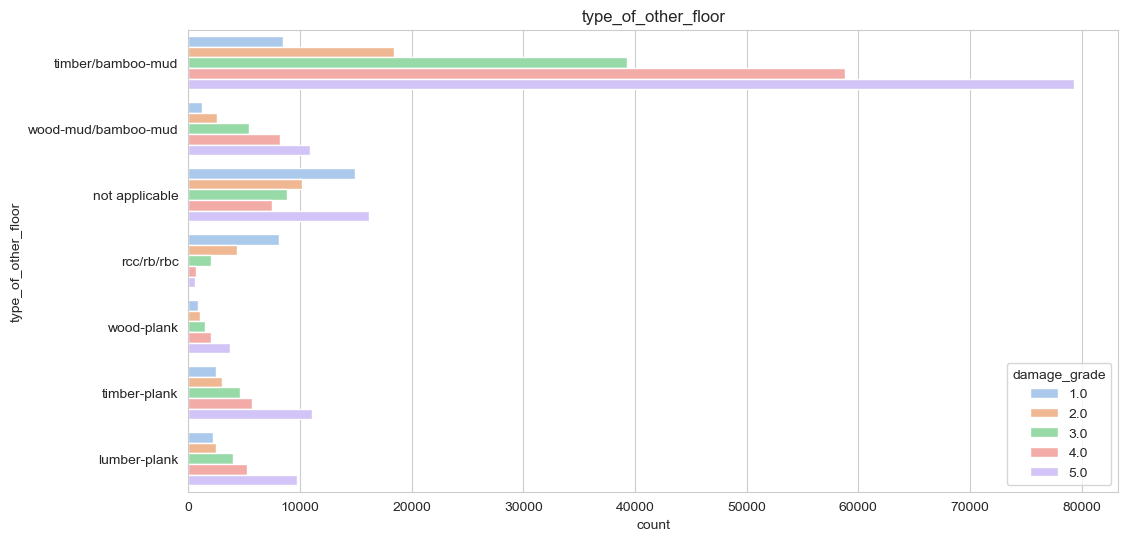

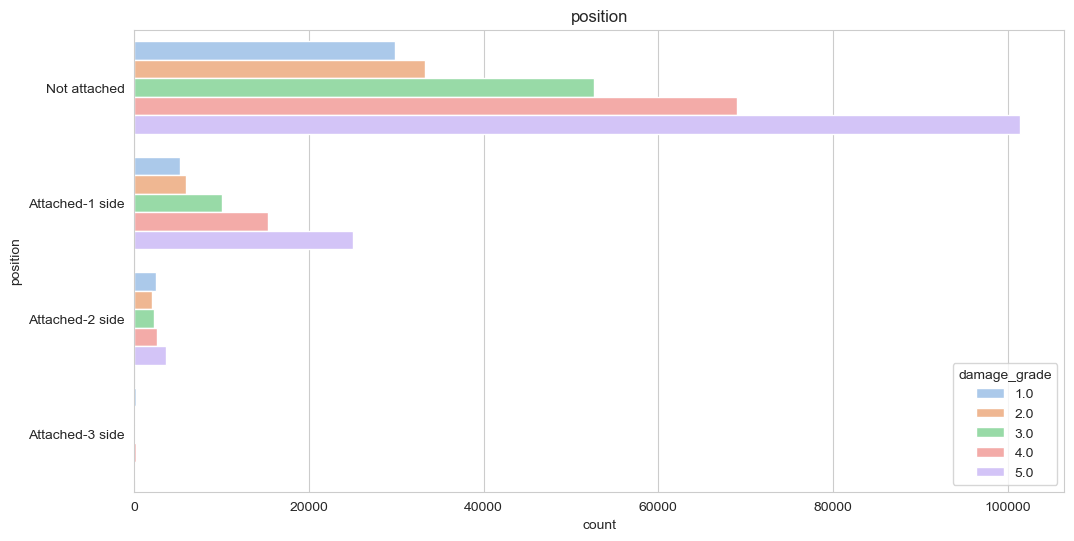

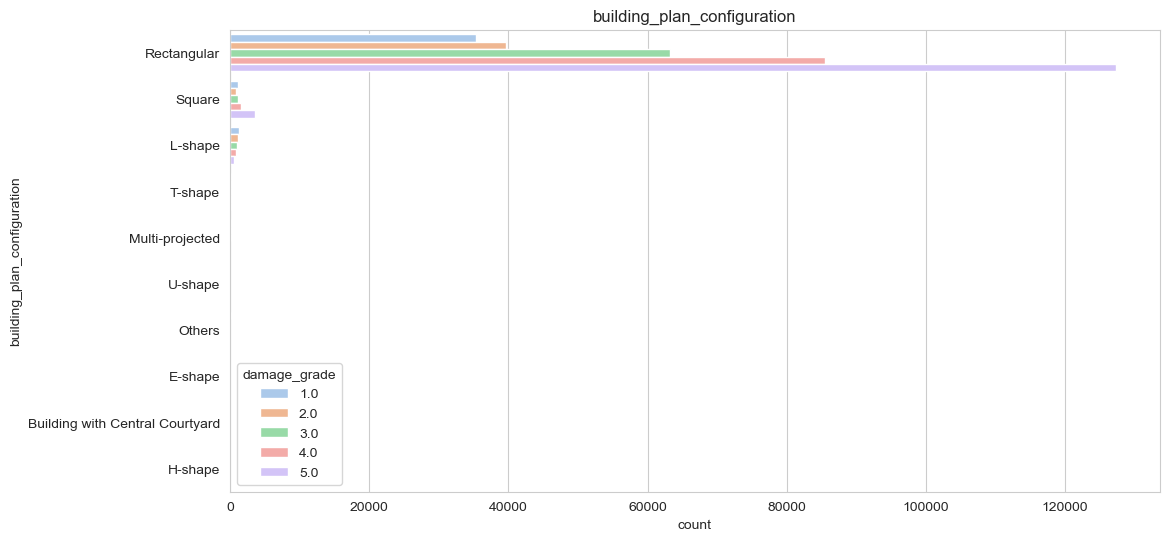

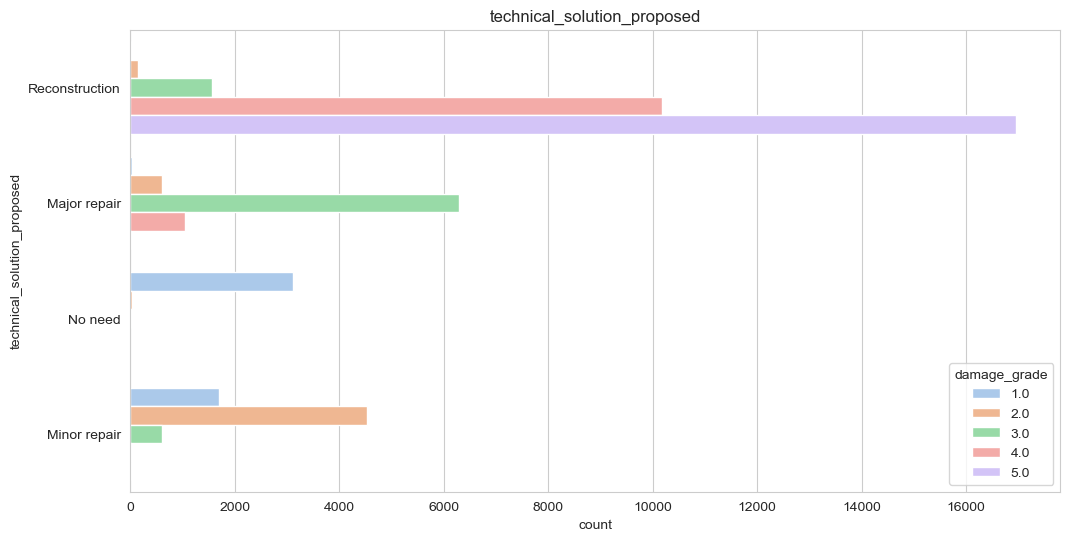

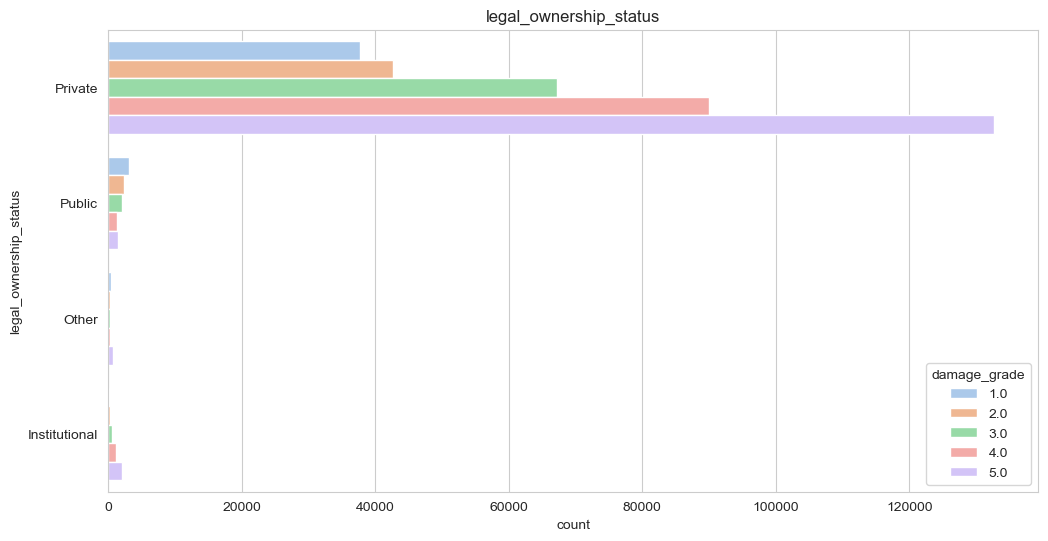

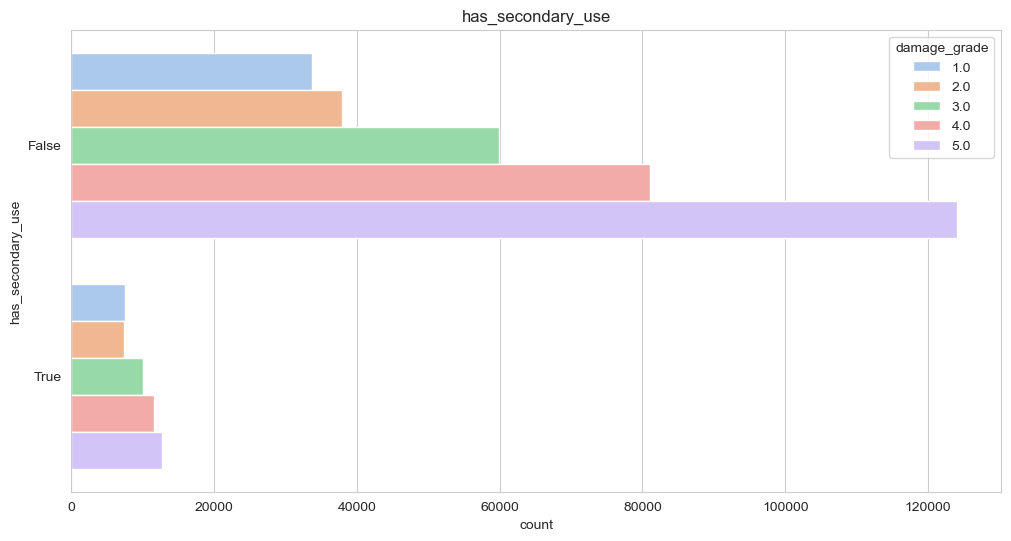

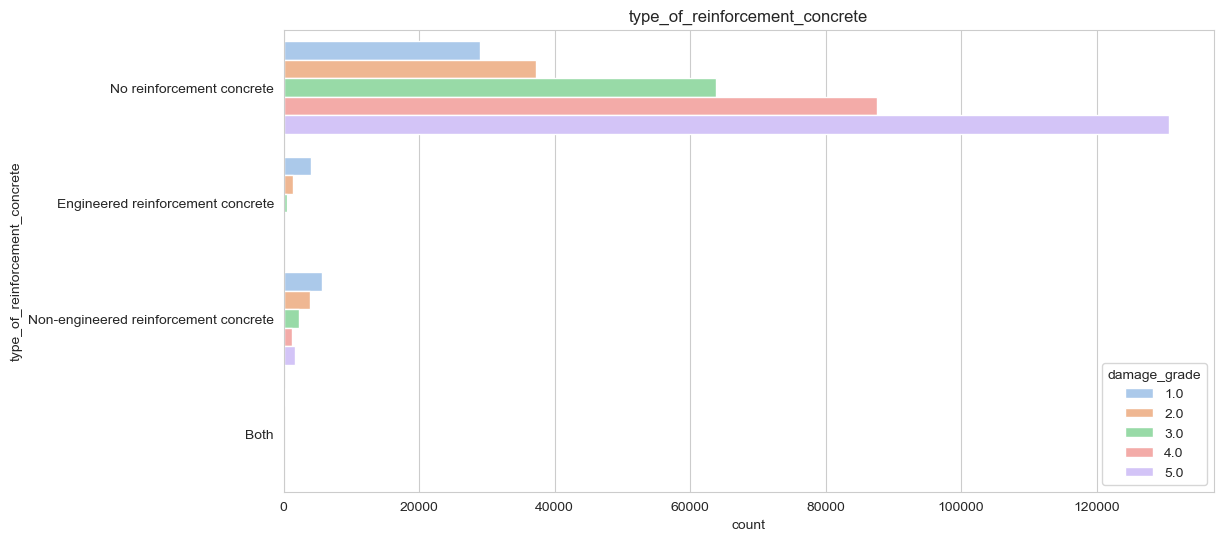

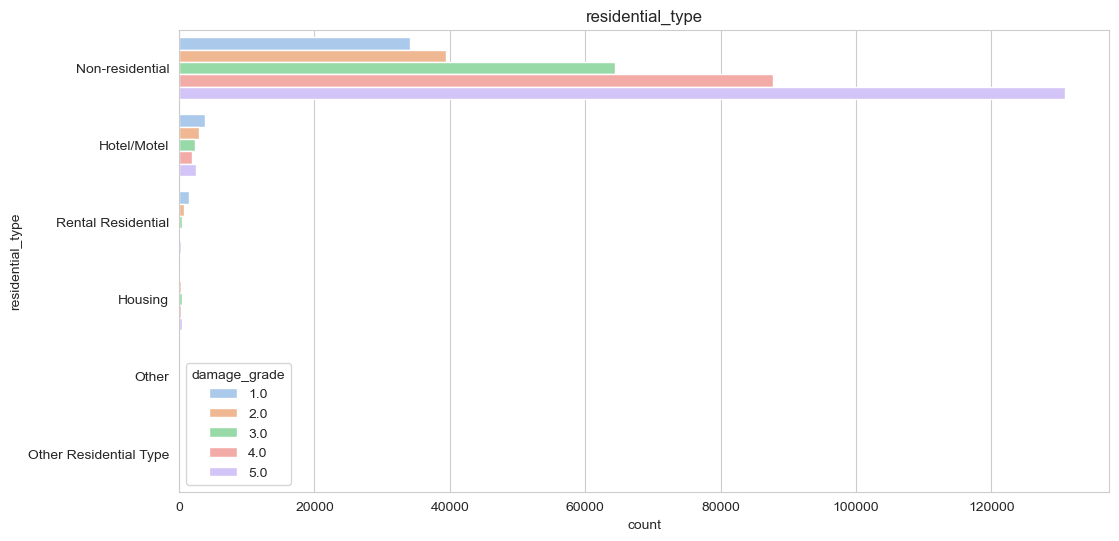

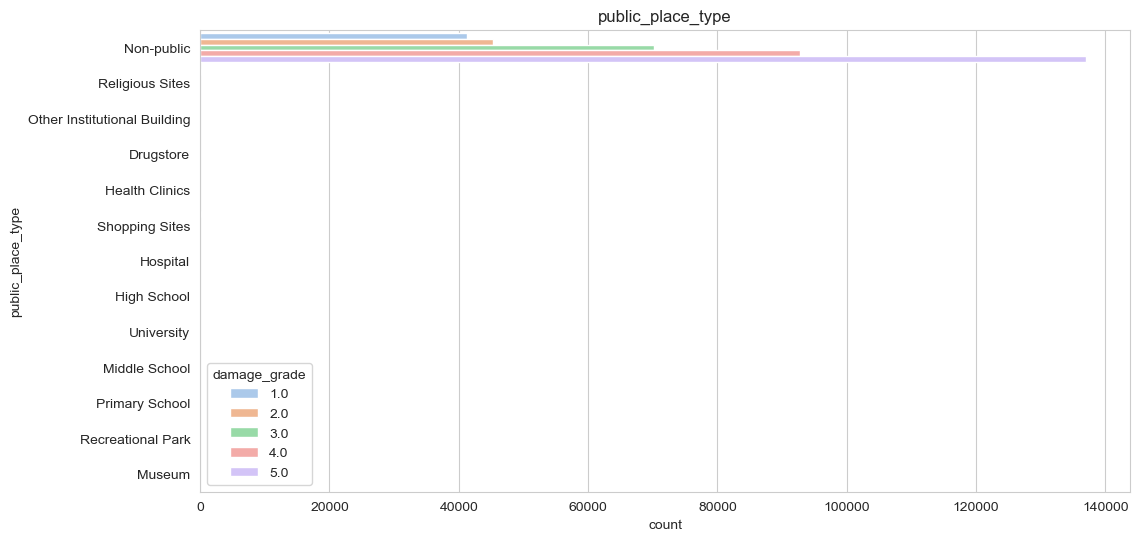

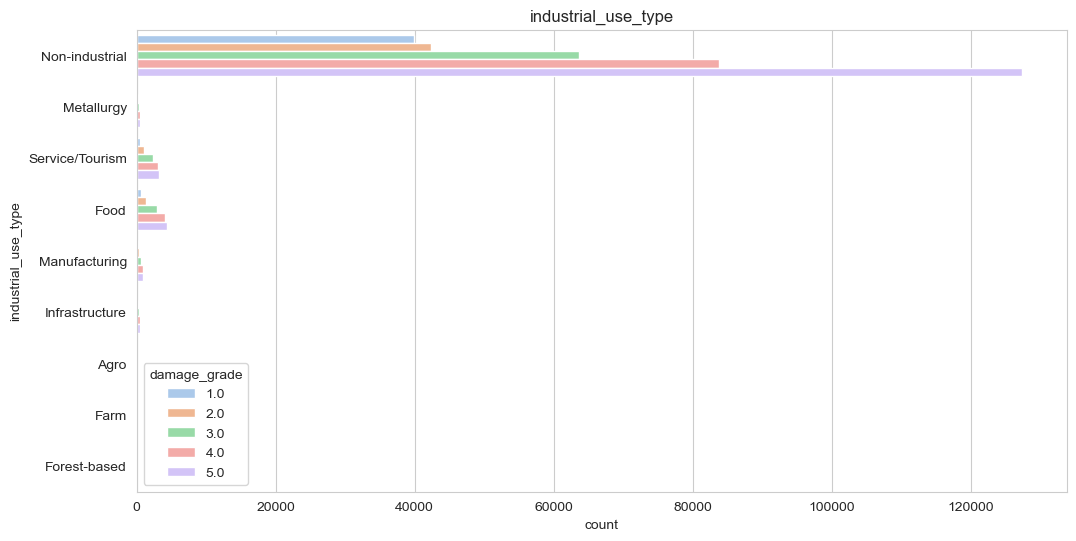

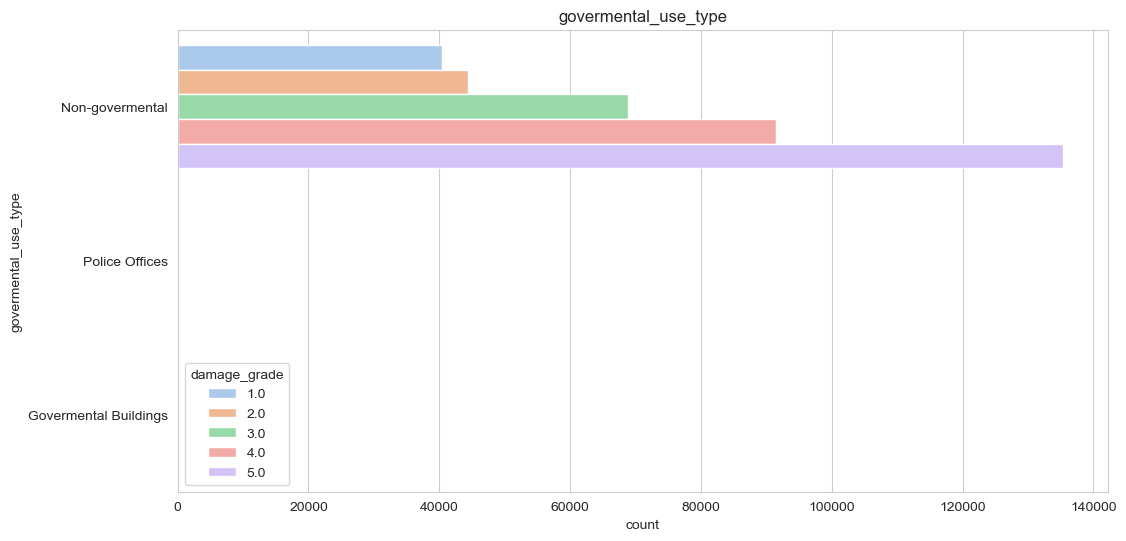

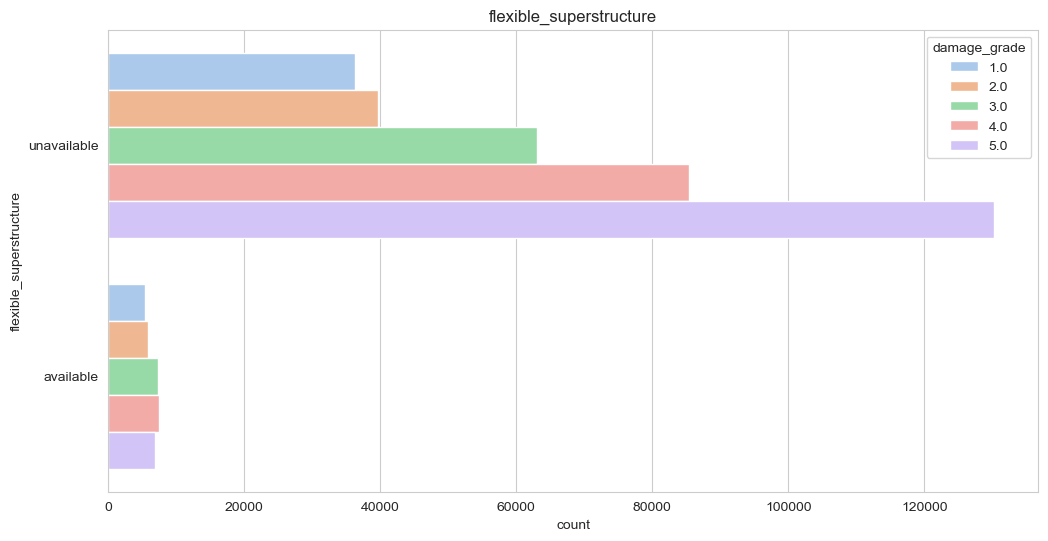

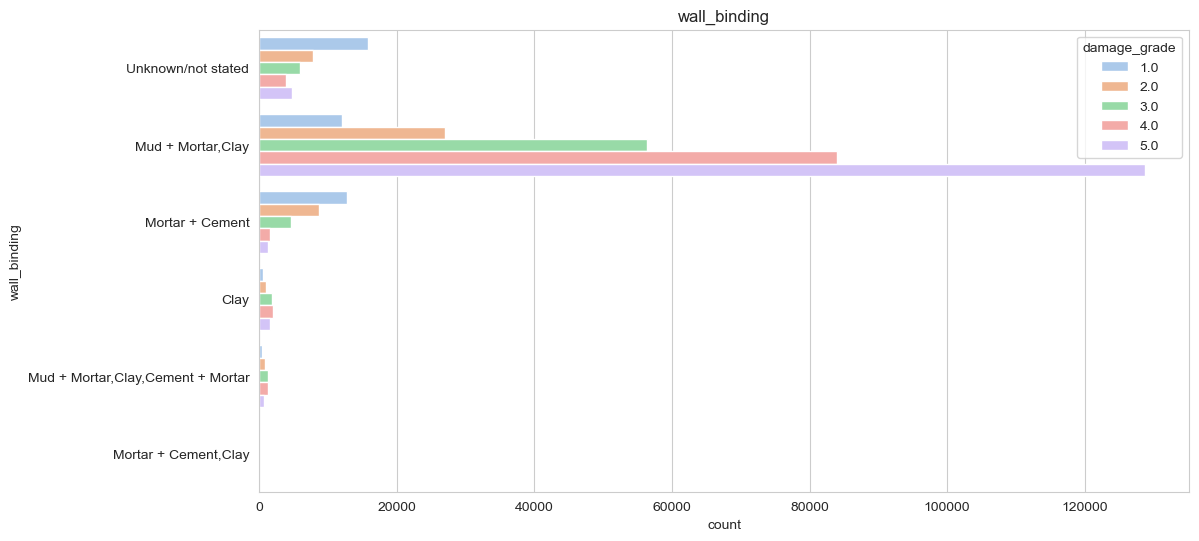

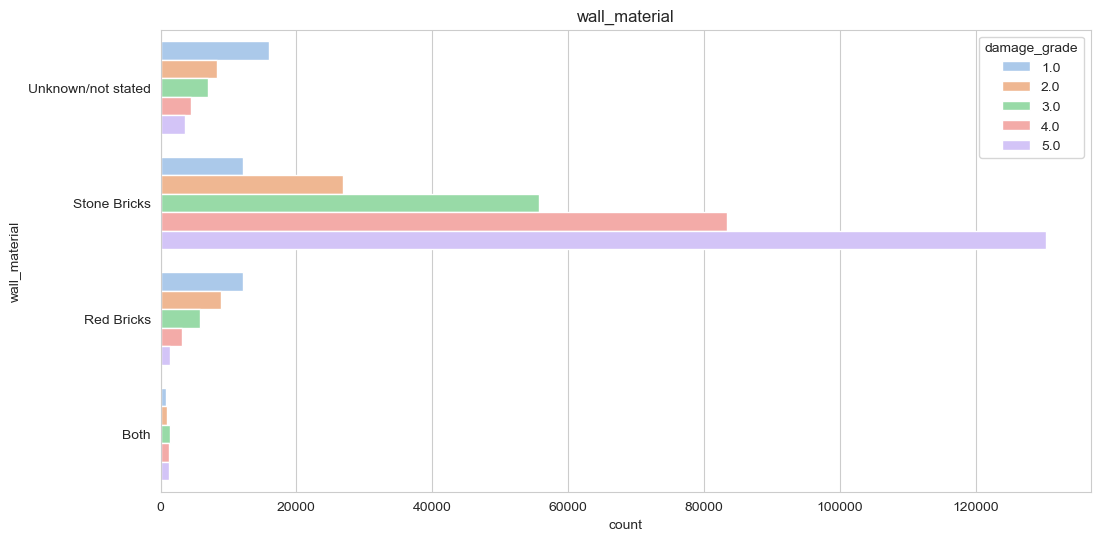

In [55]:
countStack(df_cl, 'damage_grade')


In [56]:
from scipy.stats import skew


def bivariateDisk(df, target):
    for col in df.select_dtypes(exclude='object'):
        plt.figure(figsize=(12, 6))
        plt.title(col)
        sns.histplot(data=df, x=col, kde=True, hue=target)
        _, axs = plt.subplots(nrows=2, figsize=(12, 12))
        sns.violinplot(data=df, y=col, x=target, ax=axs[0])
        sns.boxplot(data=df, y=col, x=target, ax=axs[1])
        plt.show()


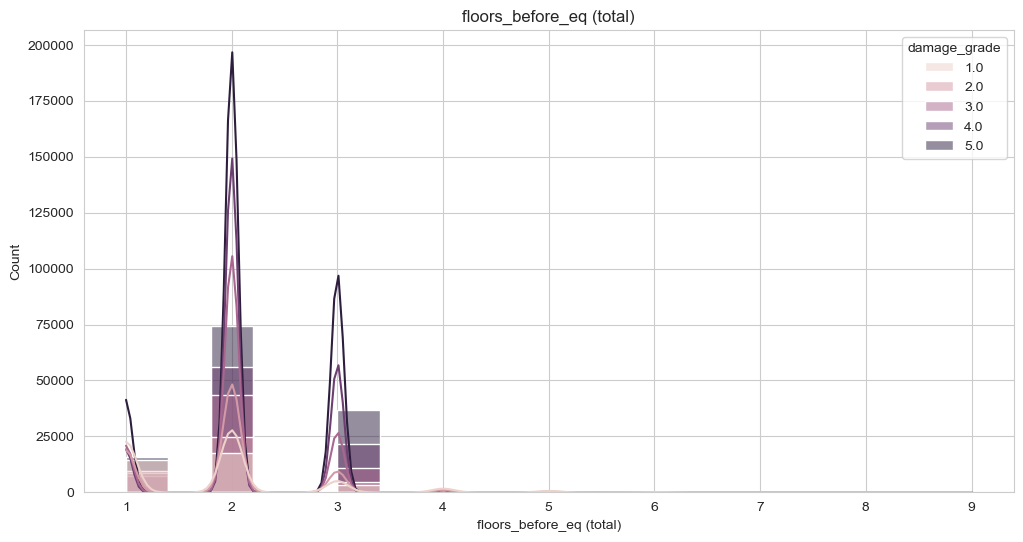

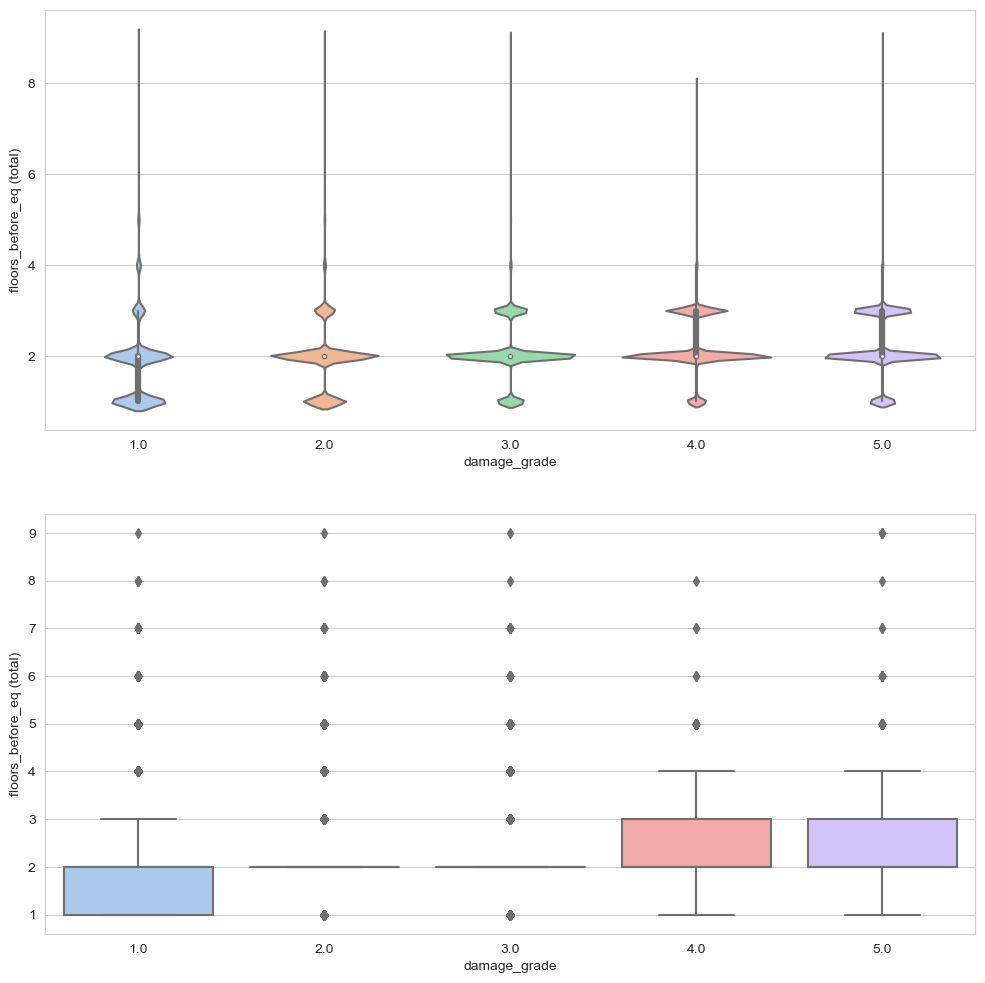

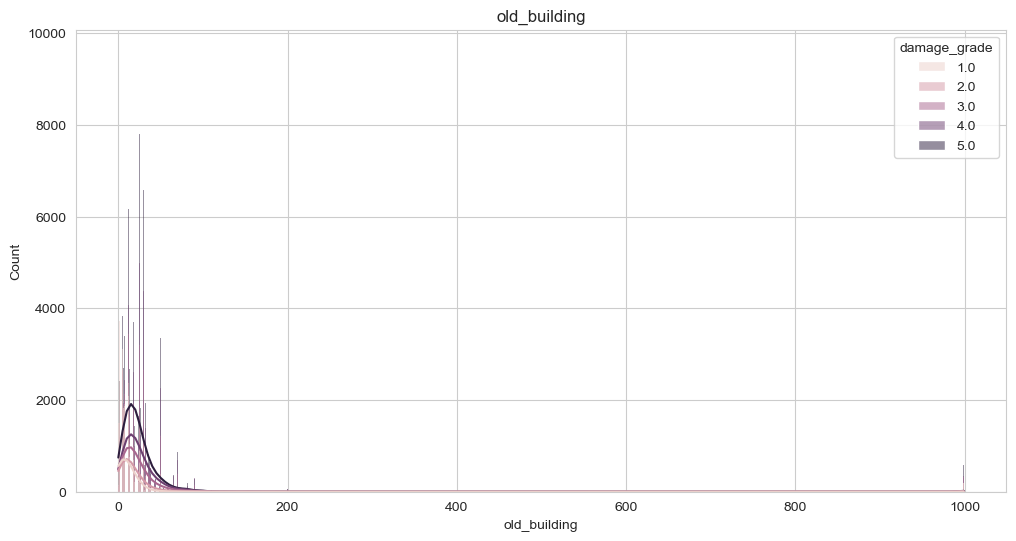

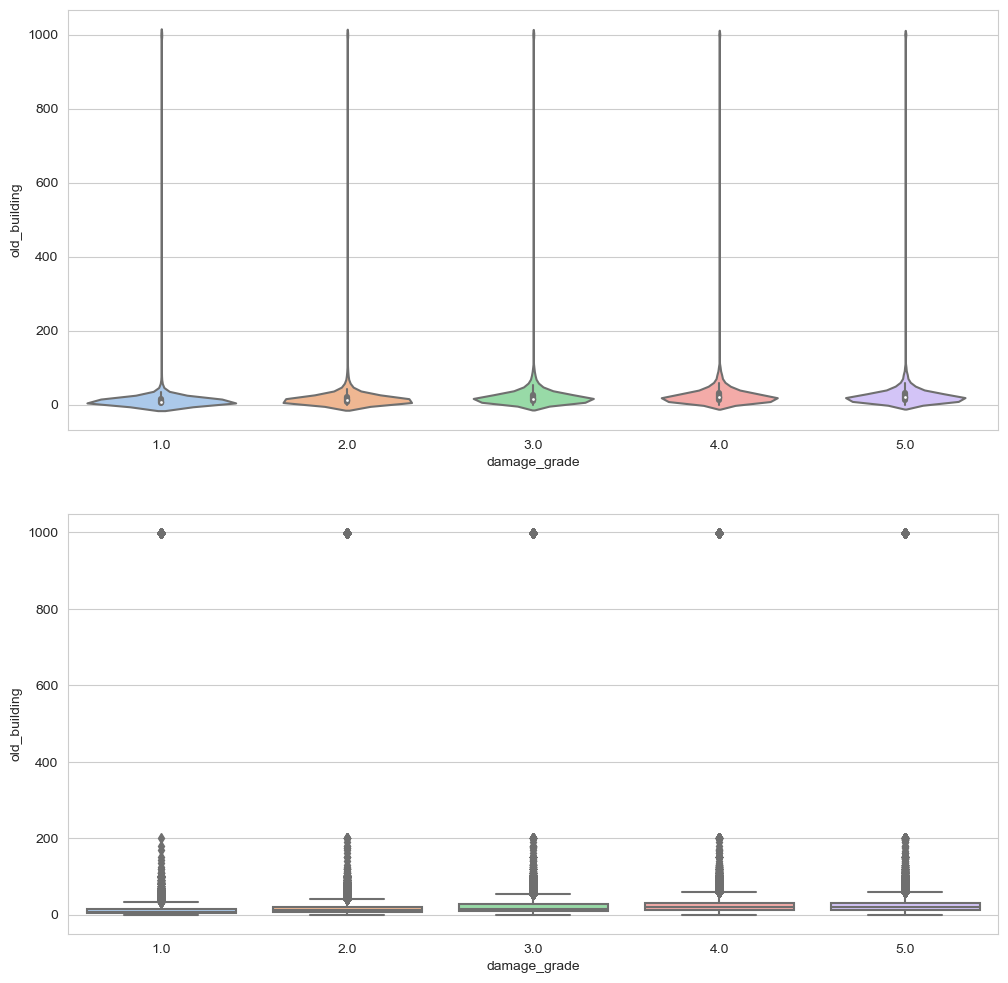

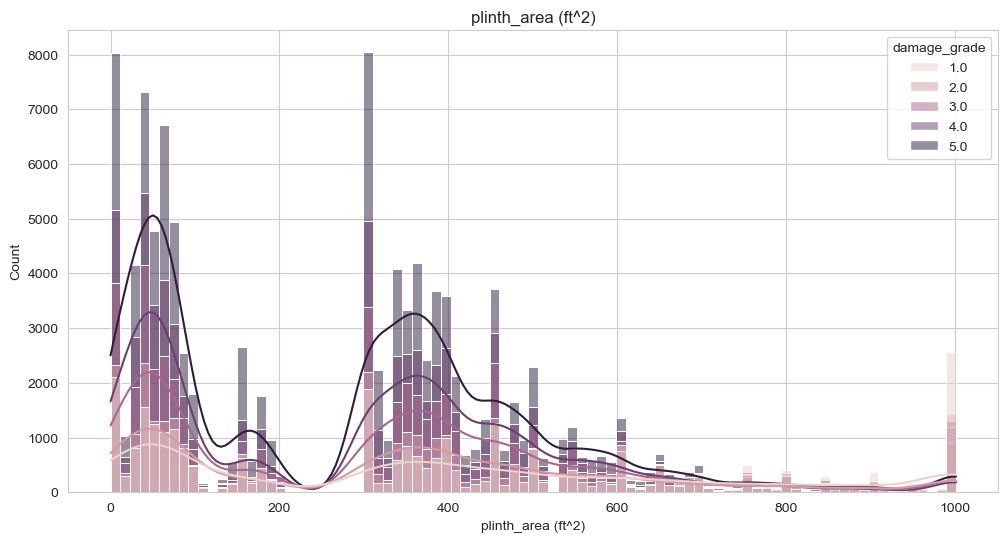

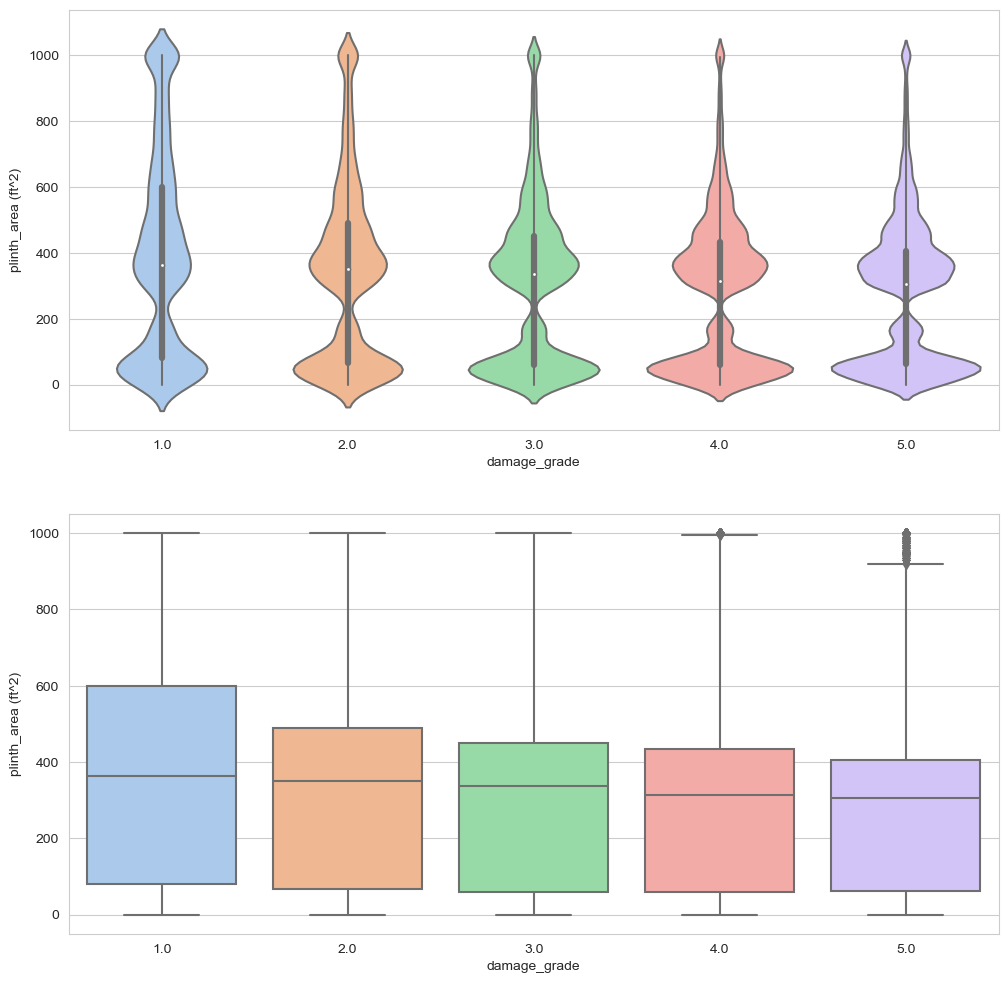

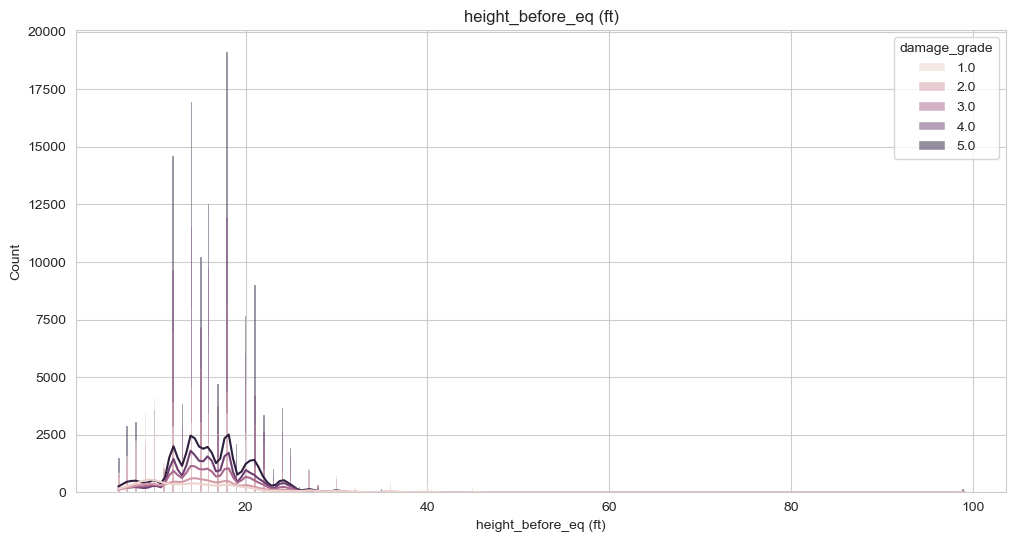

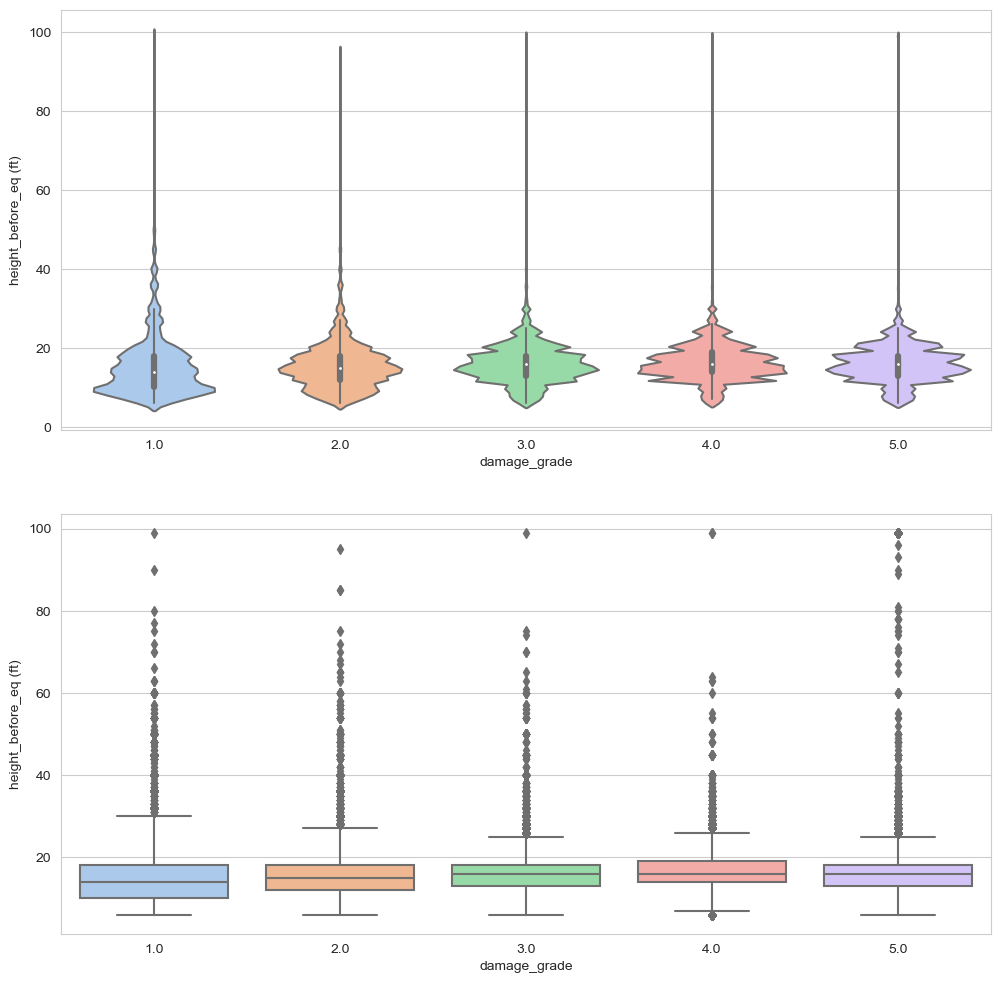

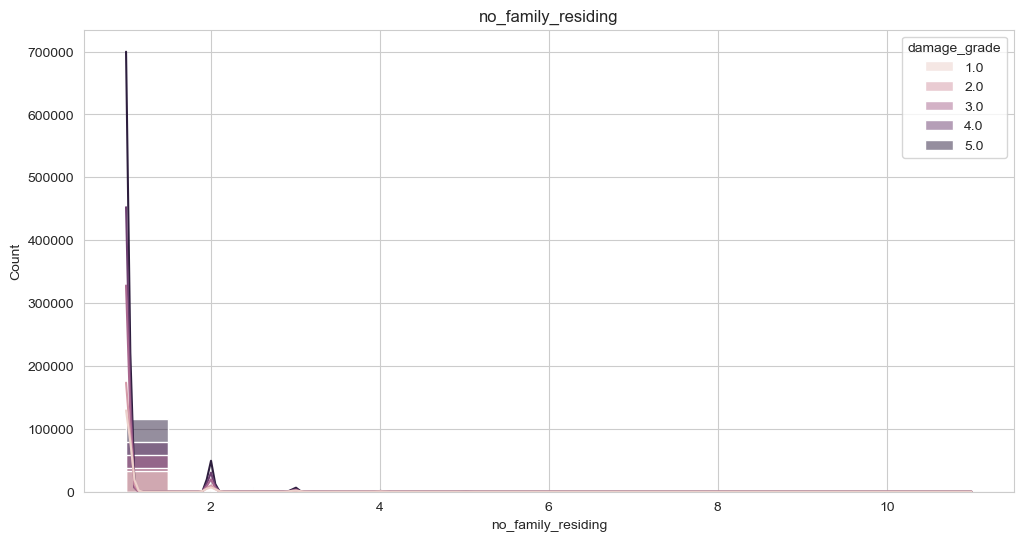

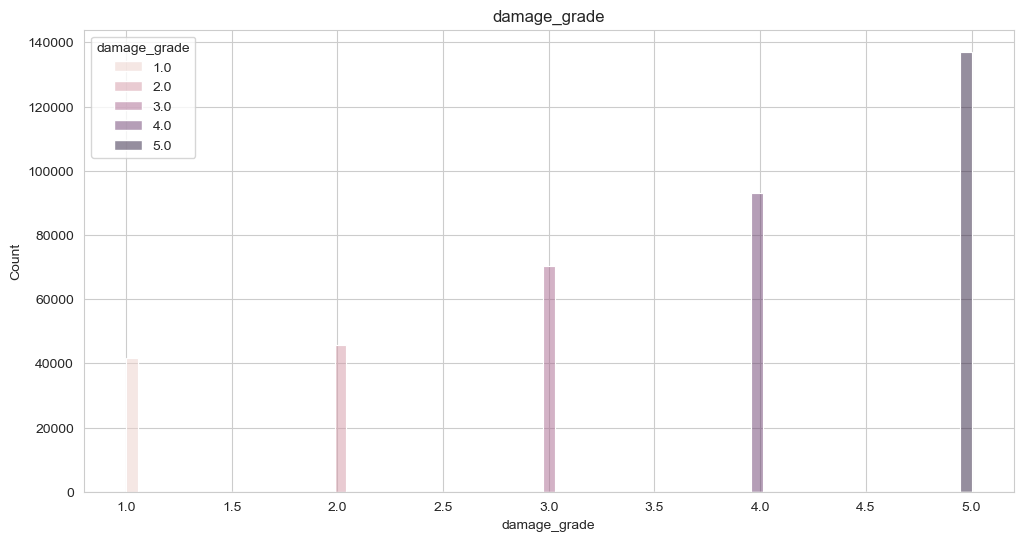

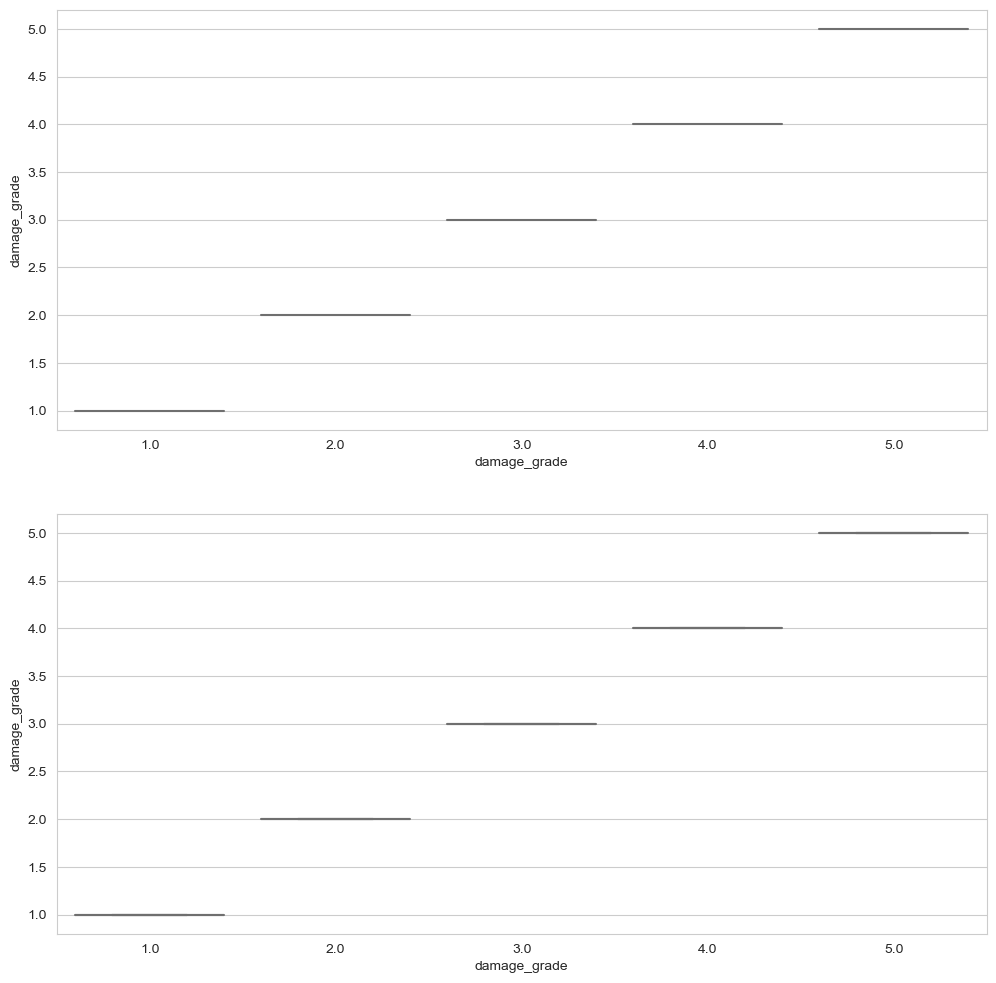

In [57]:
bivariateDisk(numerikData[:-1], 'damage_grade')


#### Crosstab



In [58]:
def crossTabData(df, target):
    for col in df.select_dtypes(include='object'):
        display(pd.crosstab(df[target].astype('int'), df[col], normalize='index').style.
                format(precision=3).background_gradient(cmap="YlGnBu"))


In [59]:
crossTabData(df_cl, 'damage_grade')


#### Group Numeric with Categorical



In [60]:
def numCatViz(df):
    # df = df.iloc[:,:-1]
    numeric_columns = df.select_dtypes(exclude='object').columns
    categorical_columns = df.select_dtypes(include='object').columns
    for col in categorical_columns:
        display(df.groupby(col)[numeric_columns].agg(['count', 'mean', 'std']).style.
                format(precision=3).background_gradient(axis=1, cmap="YlGnBu"))


In [61]:
numCatViz(df_cl)


# Further Cleaning



<Axes: >

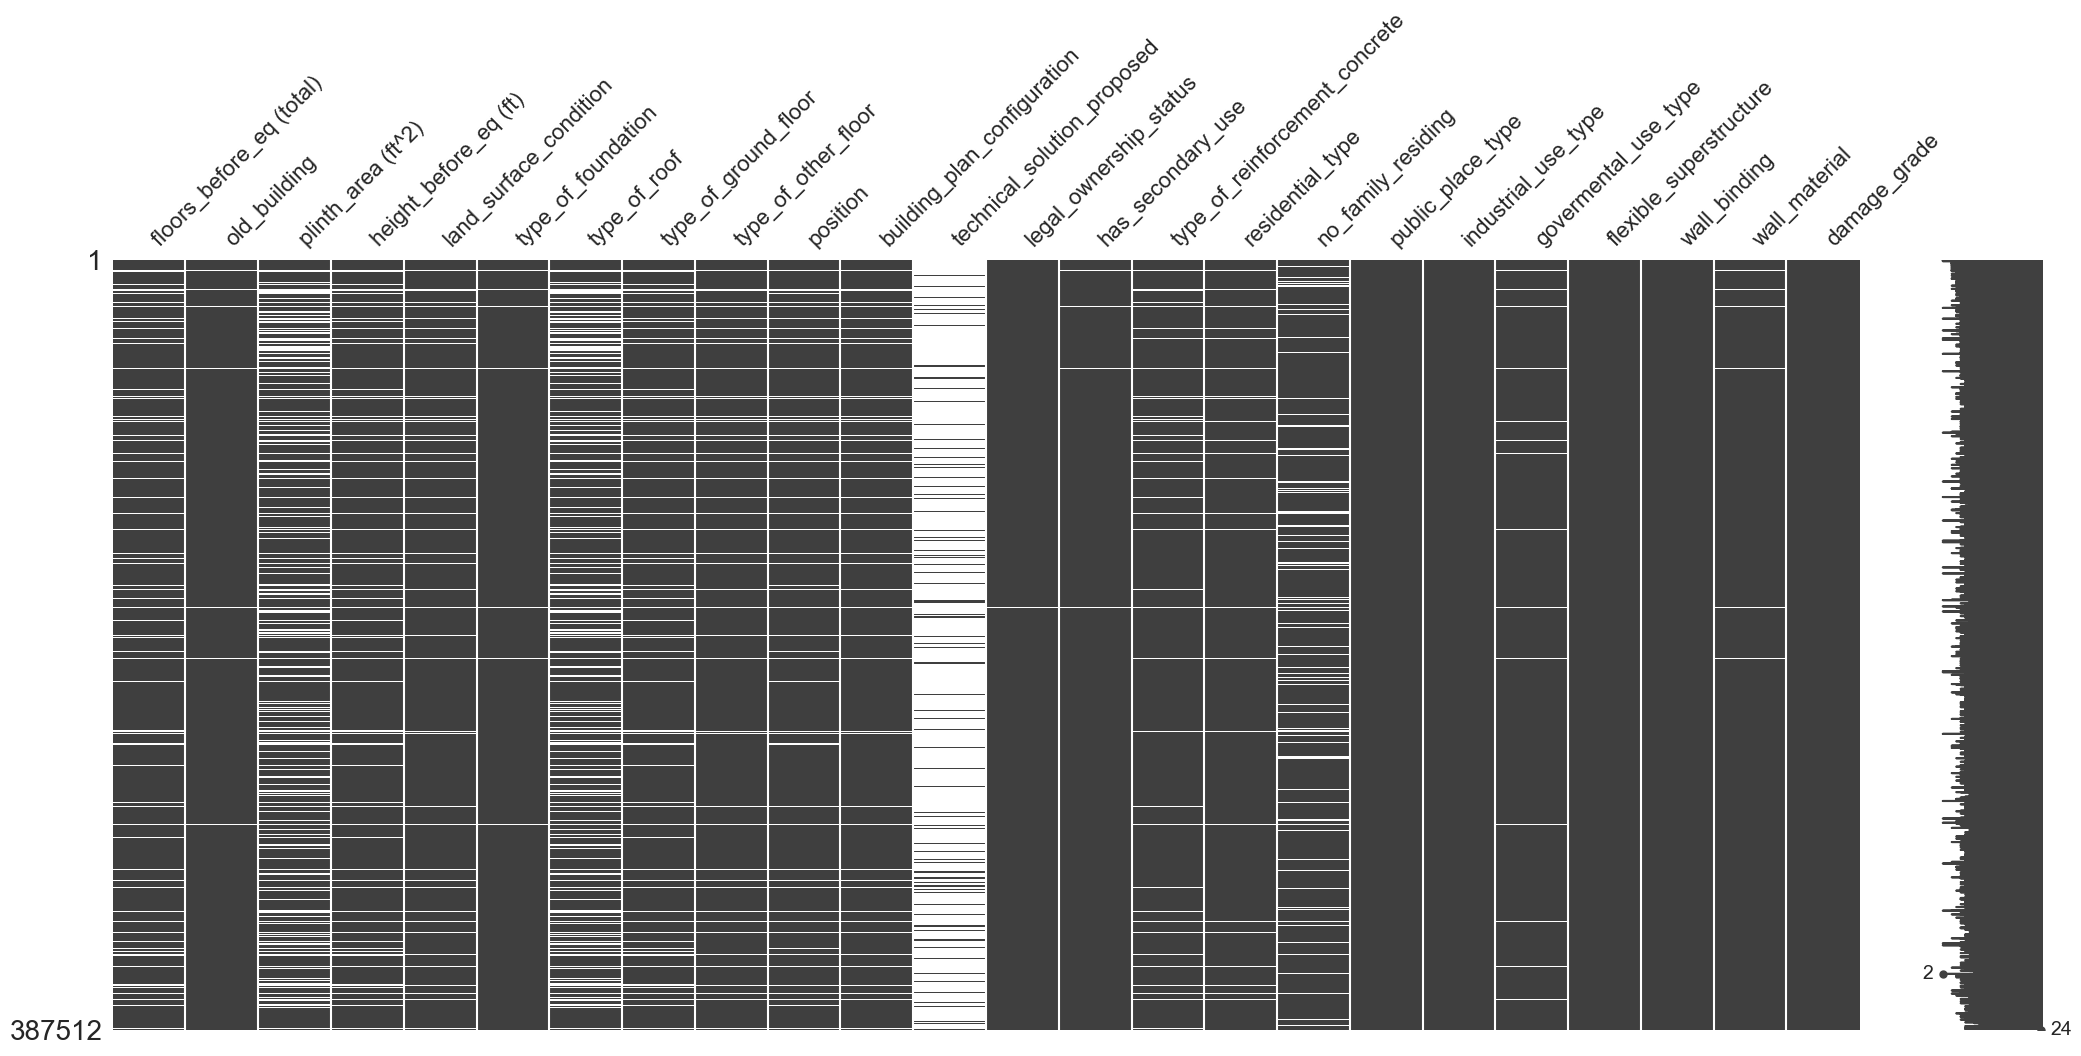

In [62]:
msno.matrix(df_cl)


In [63]:
df_backup = df_cl.copy()


In [64]:
df_200k = df_backup.dropna(thresh=23)


In [65]:
df_cl = df_cl.dropna()


In [66]:
df_cl = df_200k.copy()


## Numerik



In [67]:
def IQR(df, column):
    df = df.copy()
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    Minimum = Q1 - 1.5 * IQR
    Maximum = Q3 + 1.5 * IQR
    filter_lower = df[column] < Minimum
    filter_upper = df[column] > Maximum
    return filter_lower, filter_upper


In [68]:
df_cleaning = df_cl.copy()
df_cleaning['damage_grade'] = df_cleaning['damage_grade'].astype('str')


#### Levene Test Before Dropping Outliers



LeveneResult(statistic=1138.1344057756733, pvalue=0.0)

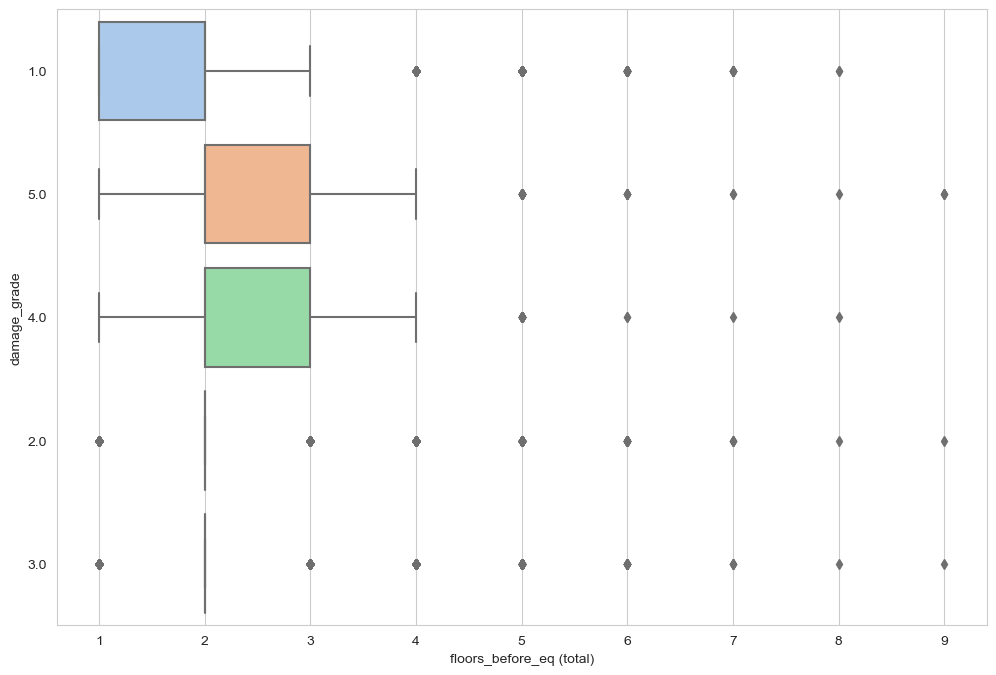

LeveneResult(statistic=40.02030266611197, pvalue=1.4364180907767733e-33)

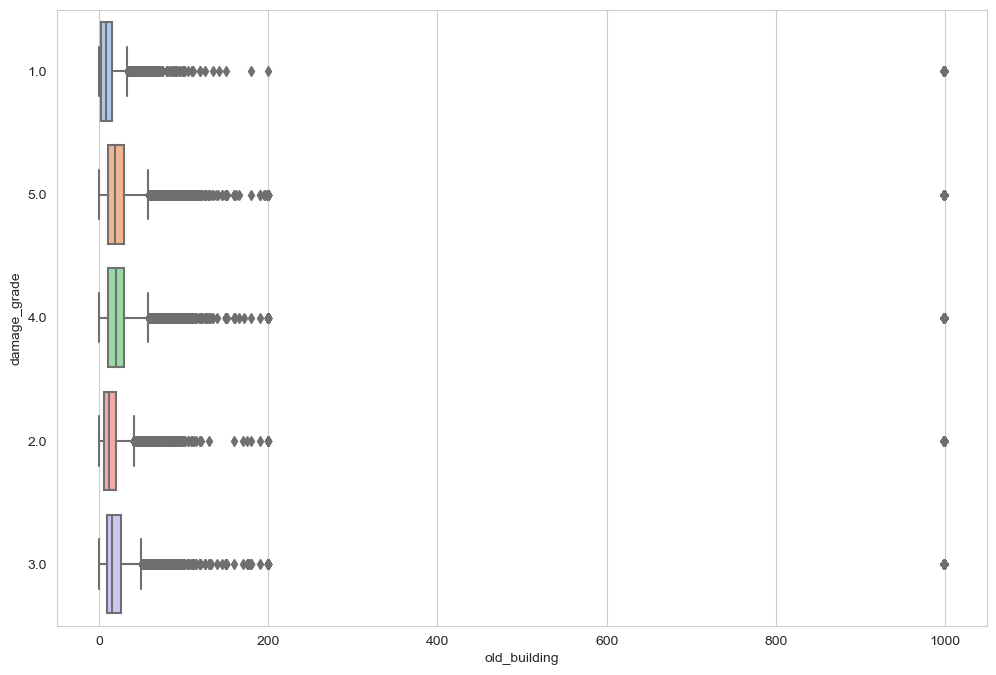

LeveneResult(statistic=1536.9583310371272, pvalue=0.0)

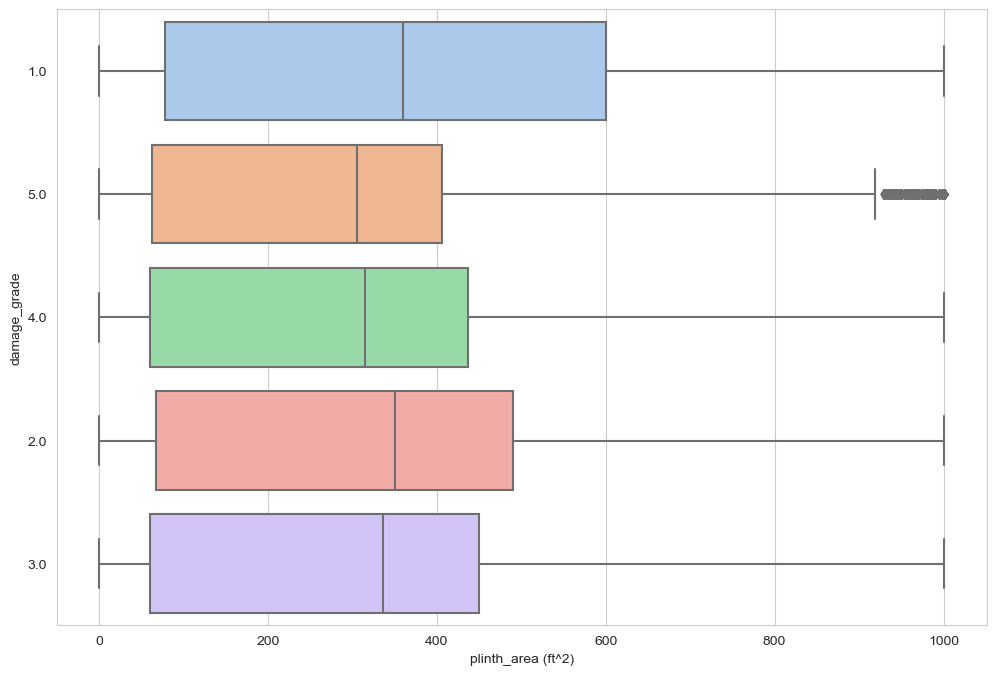

LeveneResult(statistic=1227.227868545508, pvalue=0.0)

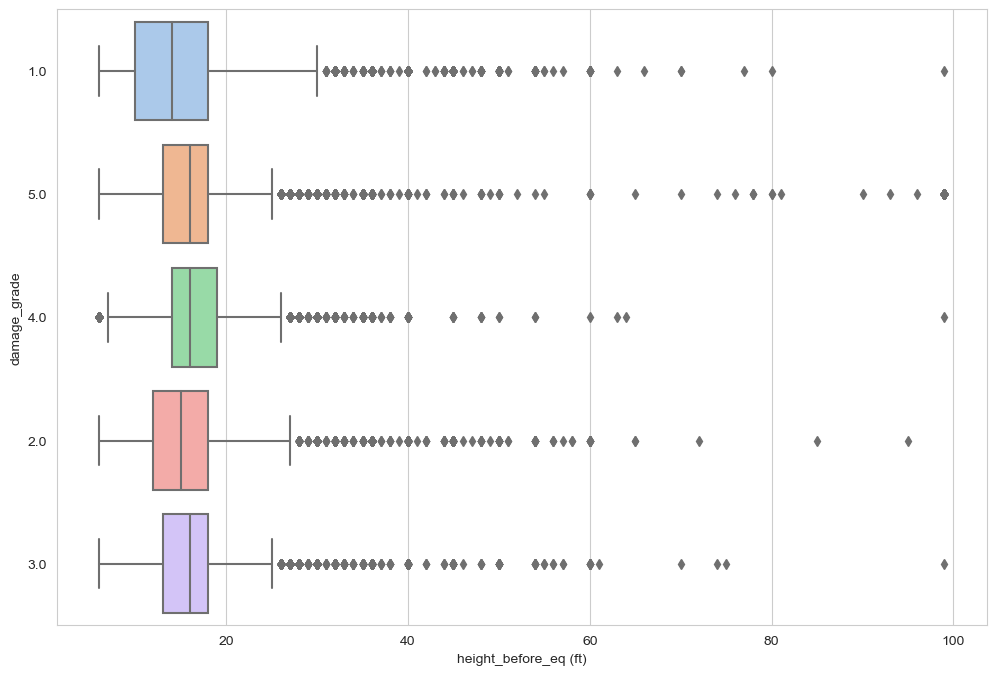

LeveneResult(statistic=13.611424917968348, pvalue=4.25561138111305e-11)

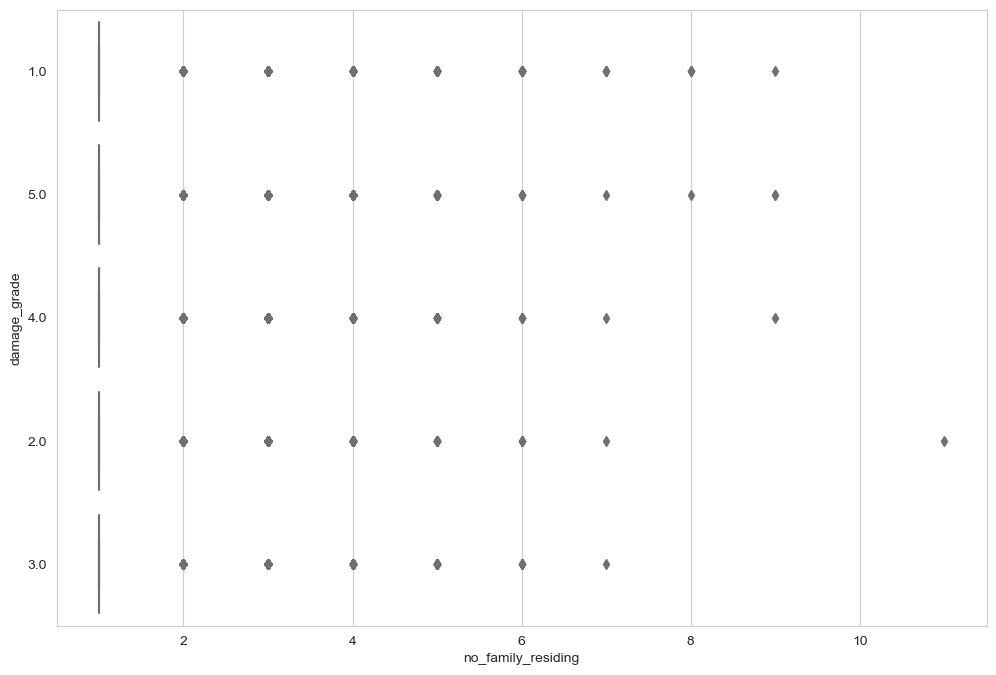

In [69]:
from scipy.stats import levene
for col in df_cleaning.select_dtypes(exclude='object'):
    levene_test = [df_cleaning[df_cleaning['damage_grade'] == i][col].dropna(
    ).values for i in df_cleaning['damage_grade'].unique()]
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_cleaning, x=col, y='damage_grade')
    display(levene(levene_test[0], levene_test[1],
            levene_test[2], levene_test[3], levene_test[4]))
    plt.show()


#### Levene Test On Droped Outliers



LeveneResult(statistic=nan, pvalue=nan)

LeveneResult(statistic=1170.5445864767705, pvalue=0.0)

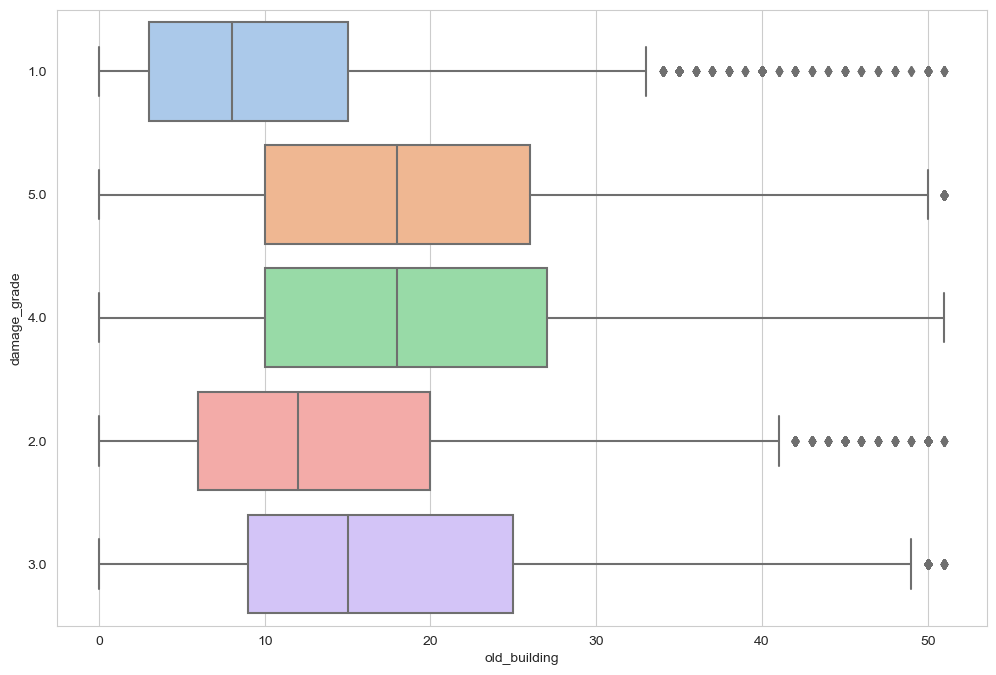

LeveneResult(statistic=1536.9583310371272, pvalue=0.0)

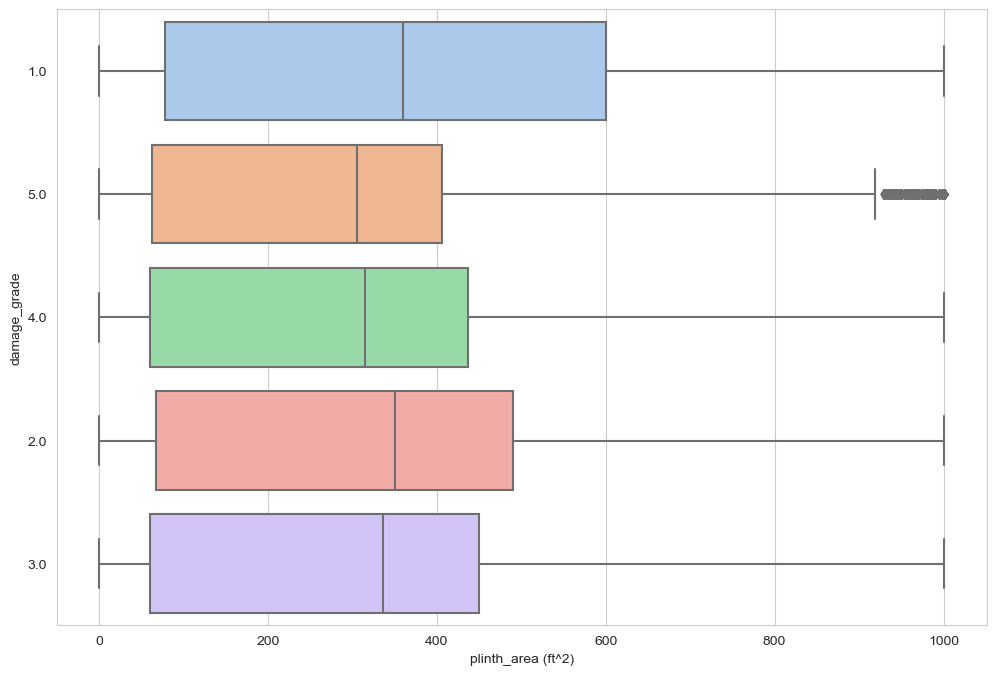

LeveneResult(statistic=611.293971683474, pvalue=0.0)

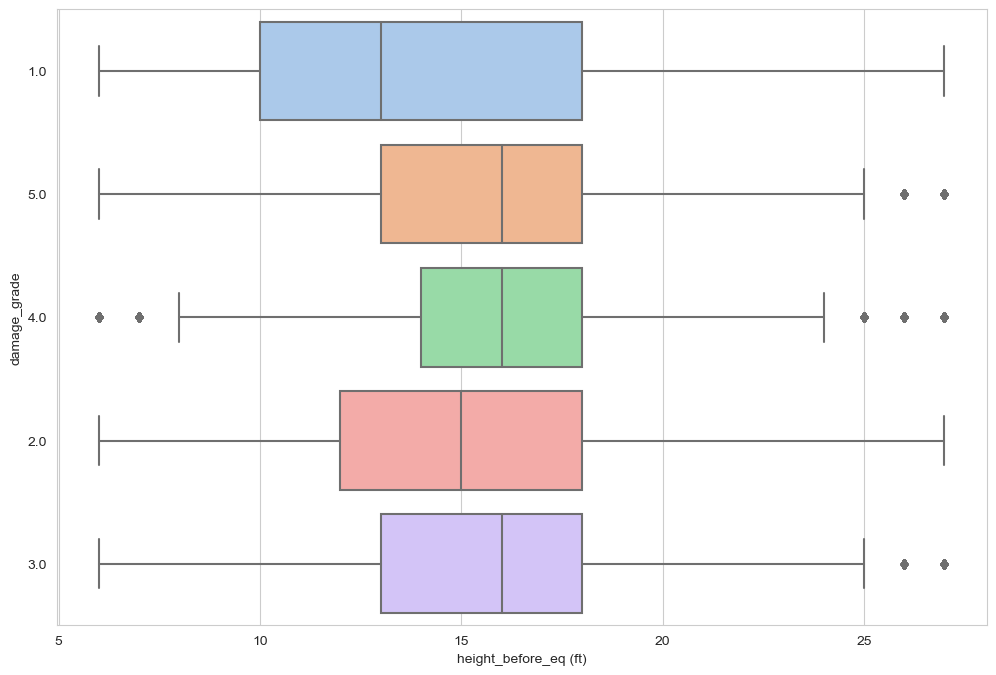

LeveneResult(statistic=nan, pvalue=nan)

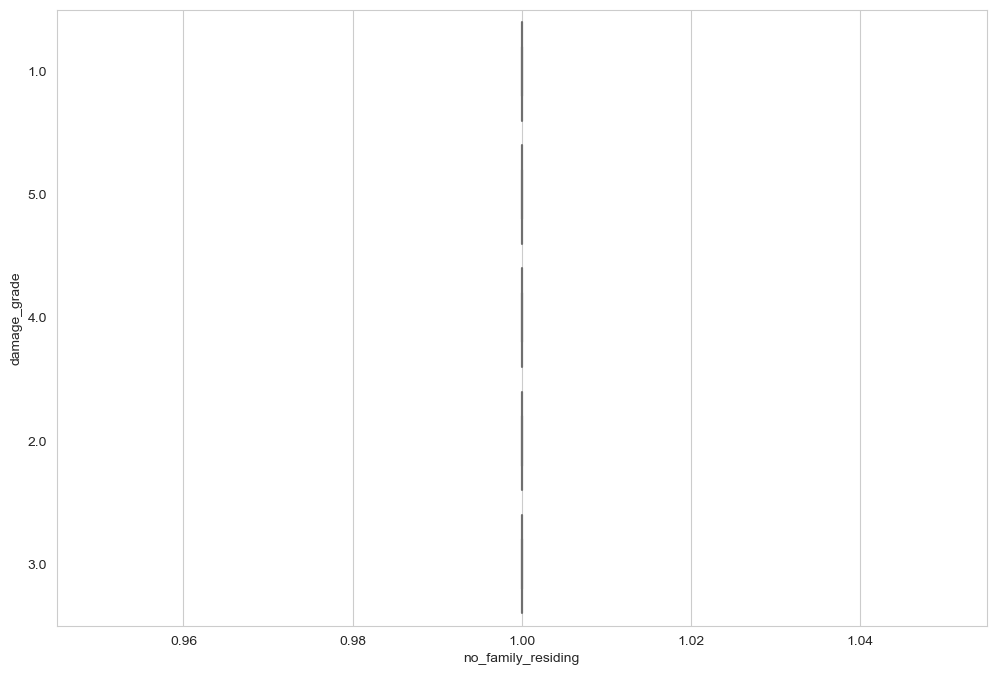

In [70]:
from scipy.stats import levene
for col in df_cleaning.select_dtypes(exclude='object'):
    l, u = IQR(df_cleaning, col)
    df_temp = df_cleaning[~(l | u)].copy()
    plt.figure(figsize=(12, 8))
    levene_test = [df_temp[df_temp['damage_grade'] == i]
                   [col].dropna().values for i in df_temp['damage_grade'].unique()]
    sns.boxplot(data=df_temp, x=col, y='damage_grade')
    display(levene(levene_test[0], levene_test[1],
            levene_test[2], levene_test[3], levene_test[4]))
    plt.show()


Setelah melakukan cleaning, kita melihat bahwa semua fitur sebelum dan setelah drop outlier menunjukan variansi yang signifikan antar label yang dibuktikan dengan levene test. Tetapi pada fitur 'no_family_residing' menunjukan hasil inkonklusif atau tidak membantah hipotesis null sehingga kita dapat drop nilai tersebut pada modeling



In [71]:
df_cleaning.drop('no_family_residing', axis=1, inplace=True)


In [72]:
df_ts = pd.read_csv('./Dataset/test.csv')


# Preprocessing



In [73]:
df_prep = df_cl.copy()

In [ ]:
df_prep['type_of_foundation'] = df_prep['type_of_foundation'].replace(
    ['bamboo/timber', 'mud mortar-stone/brick',
        'reinforced concrete', 'cement-stone/brick'], 'others'
)


In [ ]:
df_prep['type_of_ground_floor'] = df_prep['type_of_ground_floor'].replace(
    ['mud', 'brick/stone', 'reinforced concrete',
        'soil amendment', 'lumber', 'timber', 'wood'], 'other'
)


In [ ]:
df_prep['type_of_other_floor'] = df_prep['type_of_other_floor'].replace(
    ['wood-plank', 'timber-plank', 'lumber-plank'], 'wood'
).replace(['wood-mud/bamboo-mud', 'not applicable', 'rcc/rb/rbc'], 'other')


In [ ]:
df_prep['position'] = df_prep['position'].replace(
    ['Attached-1 side', 'Attached-2 side', 'Attached-3 side'], 'Attached'
)


In [ ]:
df_prep.drop(['legal_ownership_status', 'industrial_use_type',
              'building_plan_configuration', 'public_place_type',
              'govermental_use_type', 'no_family_residing'], axis=1, inplace=True)


In [ ]:
df_prep['type_of_reinforcement_concrete'] = df_prep['type_of_reinforcement_concrete'].replace(
    ['Engineered reinforcement concrete',
        'Non-engineered reinforcement concrete', 'Both'],
    'With reinforcement concrete'
)


In [ ]:
df_prep['residential_type'] = df_prep['residential_type'].replace(
    ['Hotel/Motel', 'Rental Residential', 'Housing', 'Other Residential Type'],
    'Other'
)


In [ ]:
df_prep['wall_material'].unique()


array(['Unknown/not stated', 'Stone Bricks', 'Red Bricks', 'Both'],
      dtype=object)

In [ ]:
df_prep['wall_binding'] = df_prep['wall_binding'].replace(
    ['Unknown/not stated', 'Mortar + Cement',
     'Clay', 'Mud + Mortar,Clay,Cement + Mortar',
     'Mortar + Cement,Clay'], 'Other'
)


In [ ]:
df_prep['wall_material'] = df_prep['wall_material'].replace(
    ['Unknown/not stated', 'Red Bricks', 'Both'], 'Other'
)


In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
numeric_features = list(df_prep.select_dtypes(exclude=['object']).columns)[:-1]
categorical_features = list(df_prep.select_dtypes(include=['object']).columns)
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder(drop='first'))
Preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('categorical_transformer', categorical_transformer, categorical_features)
    ])
pipe = make_pipeline(Preprocessor)


# EDA on preprocessed data



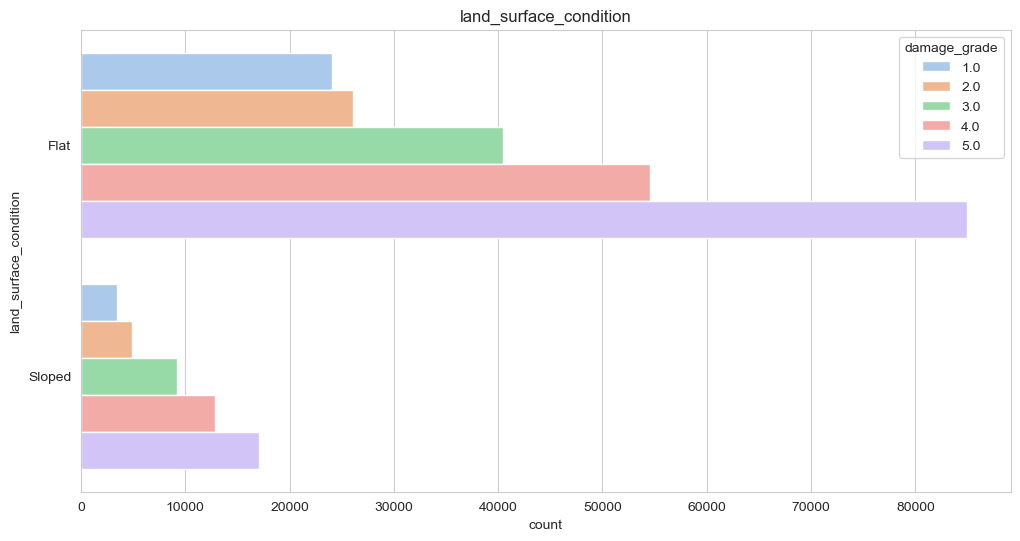

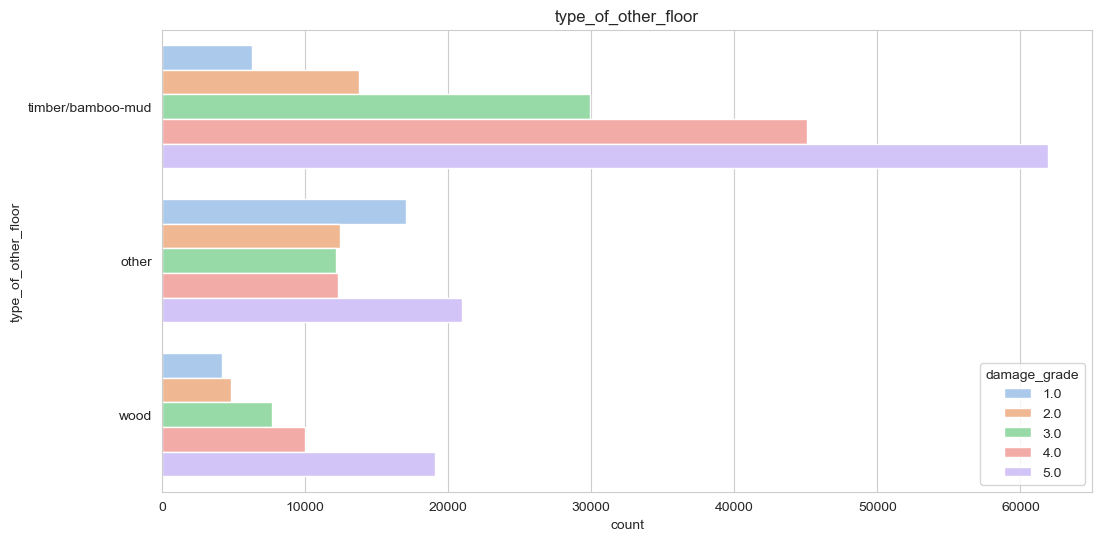

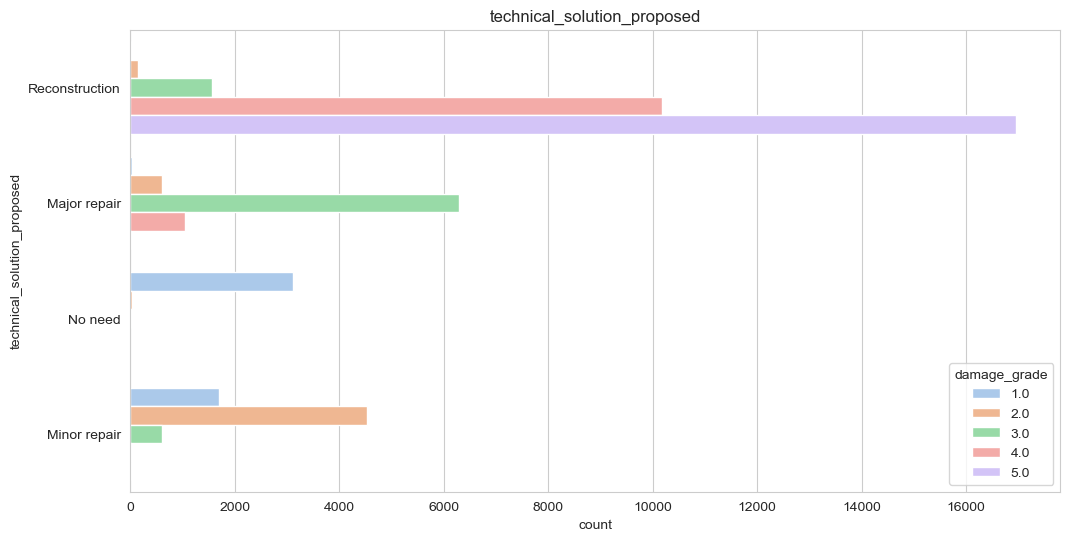

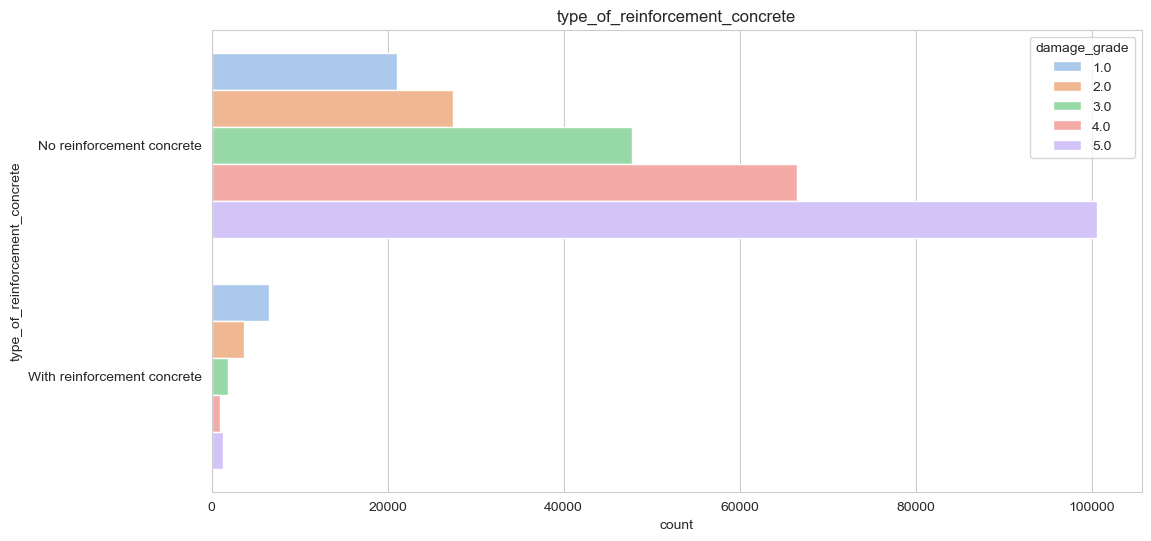

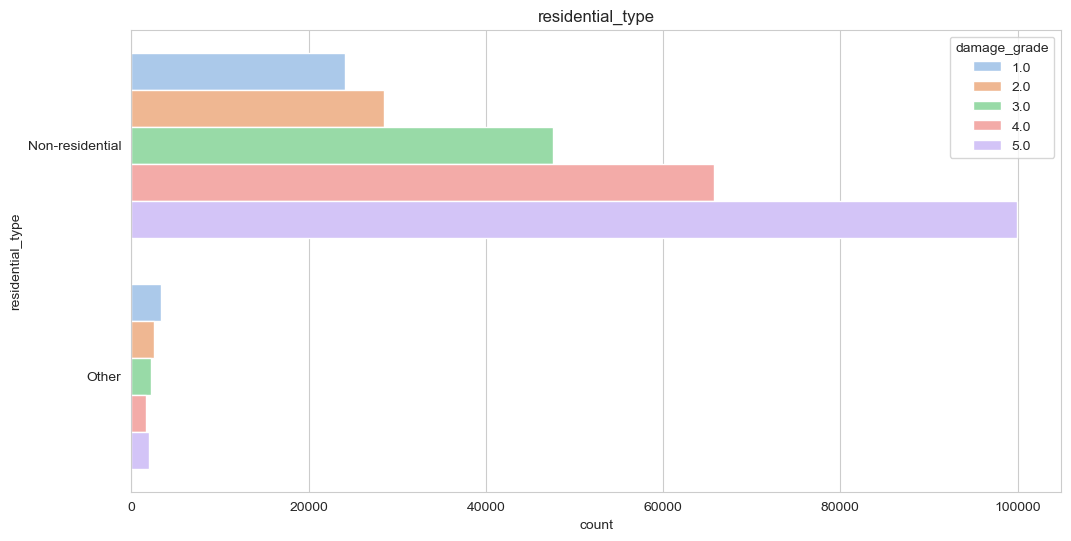

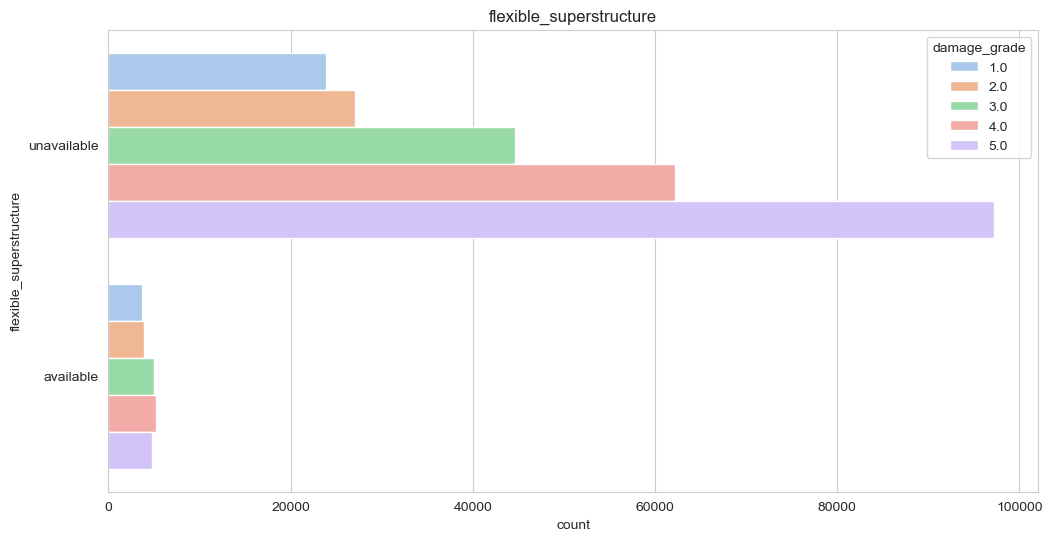

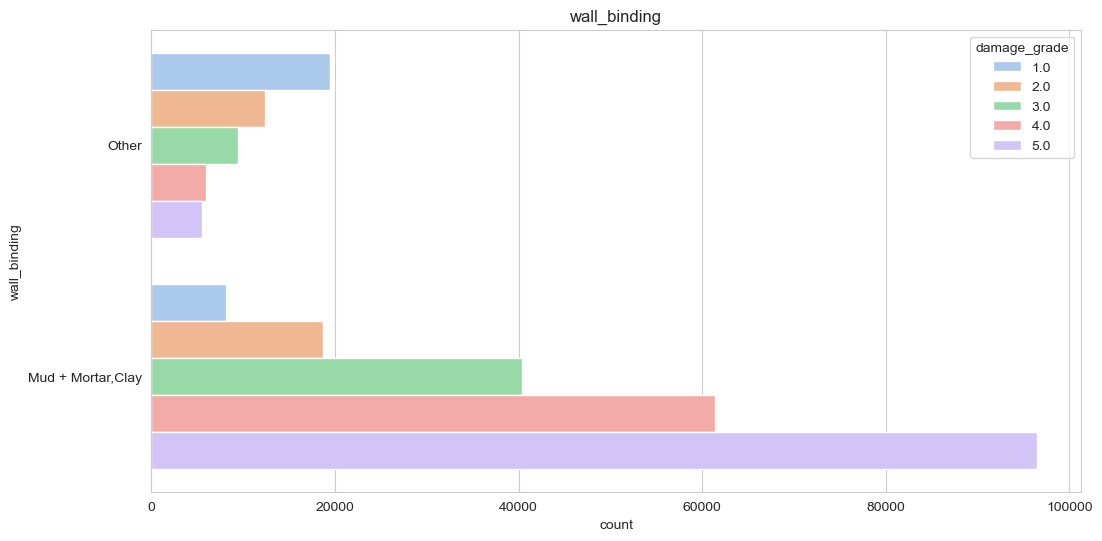

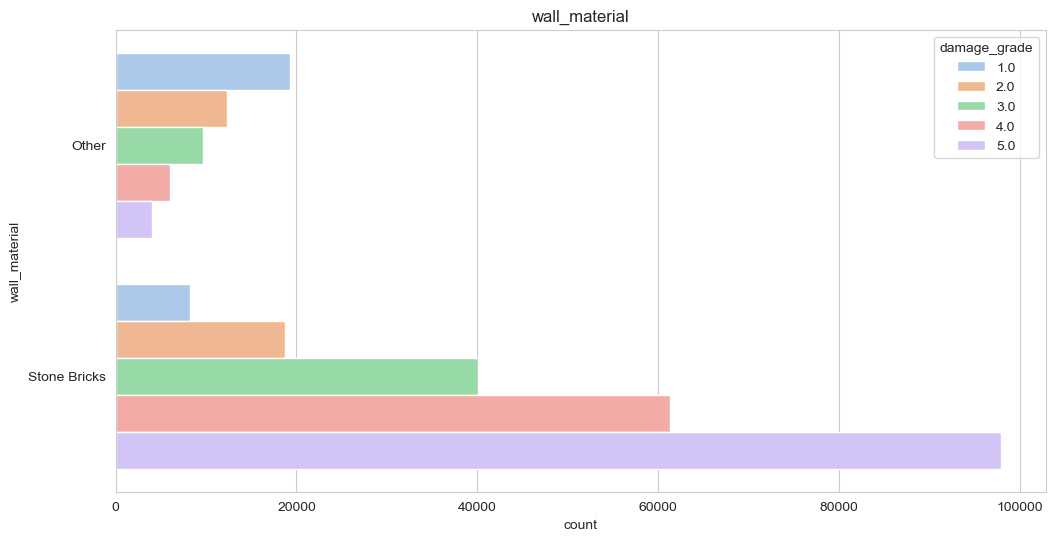

In [100]:
countStack(df_prep, 'damage_grade')


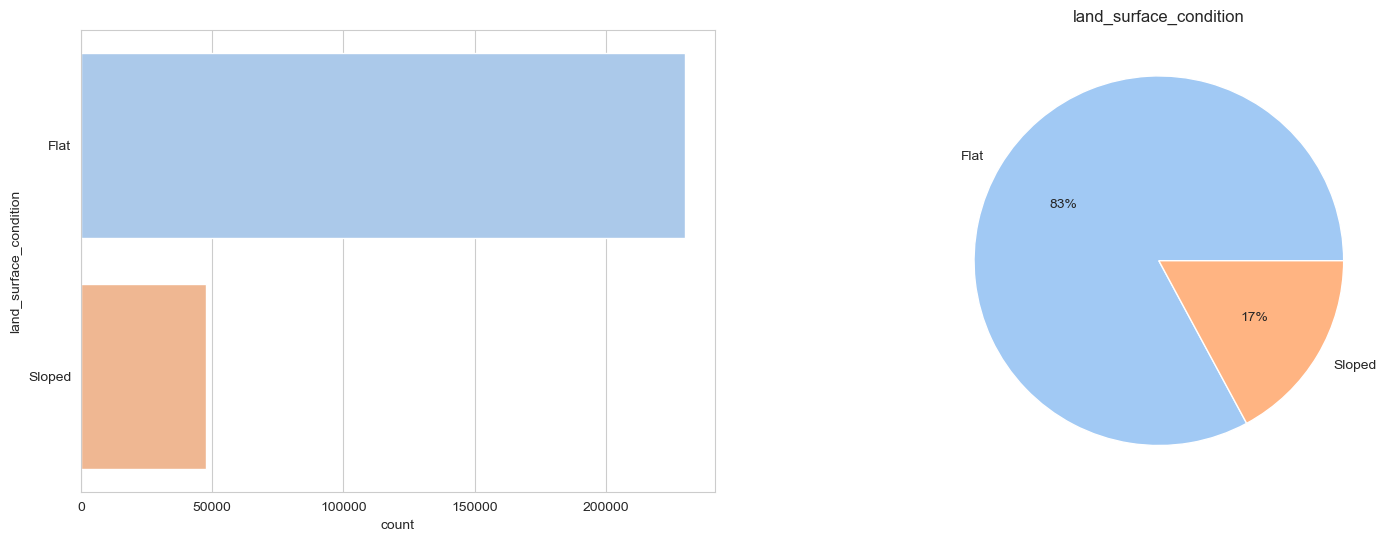

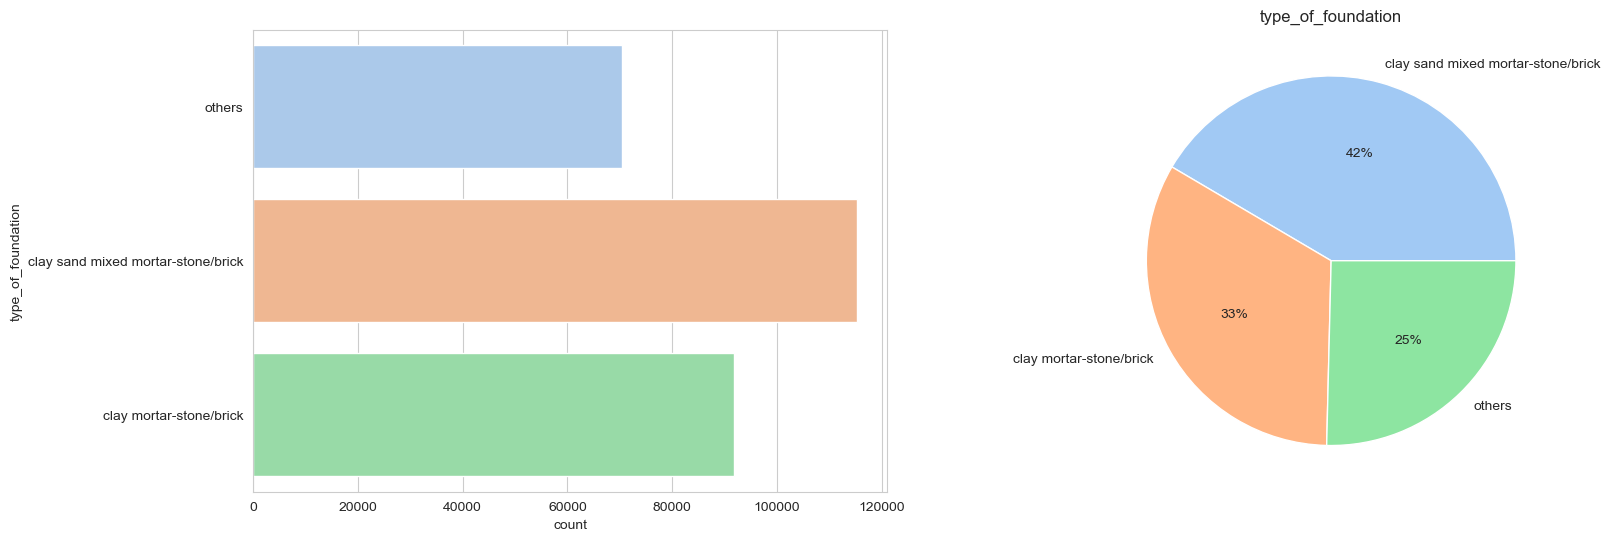

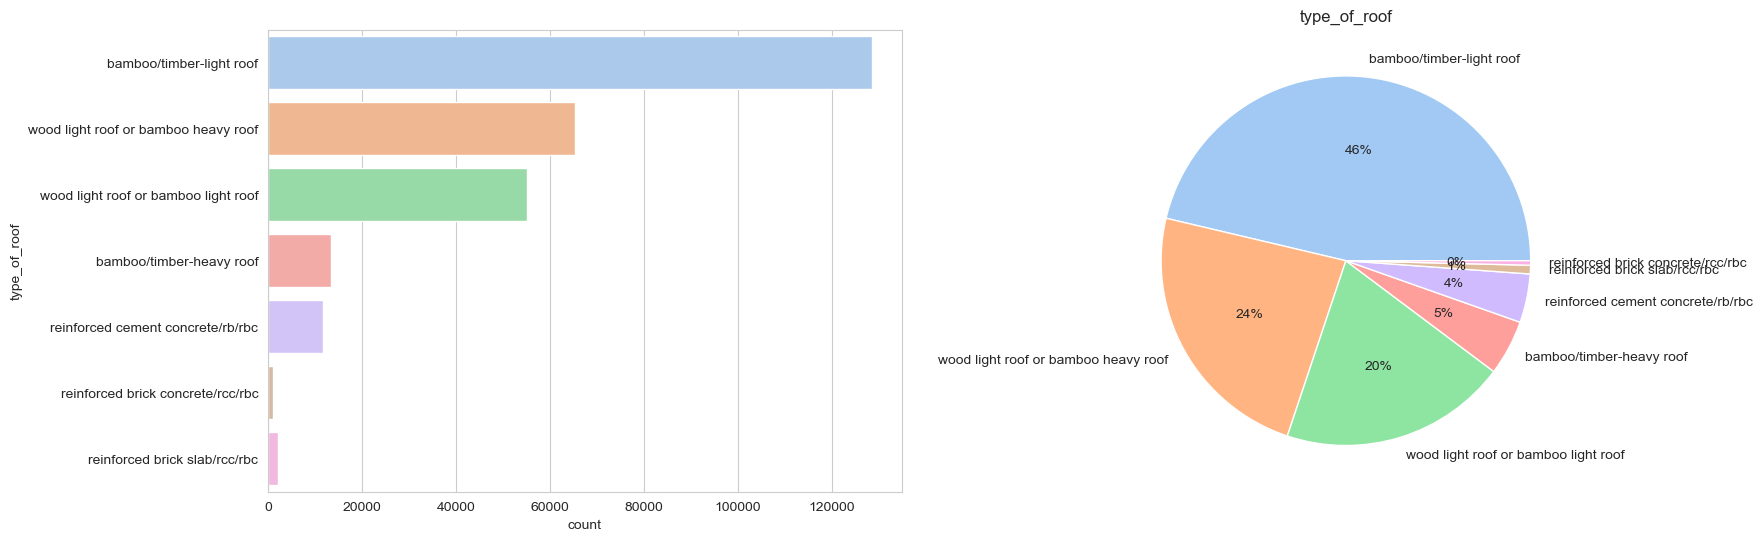

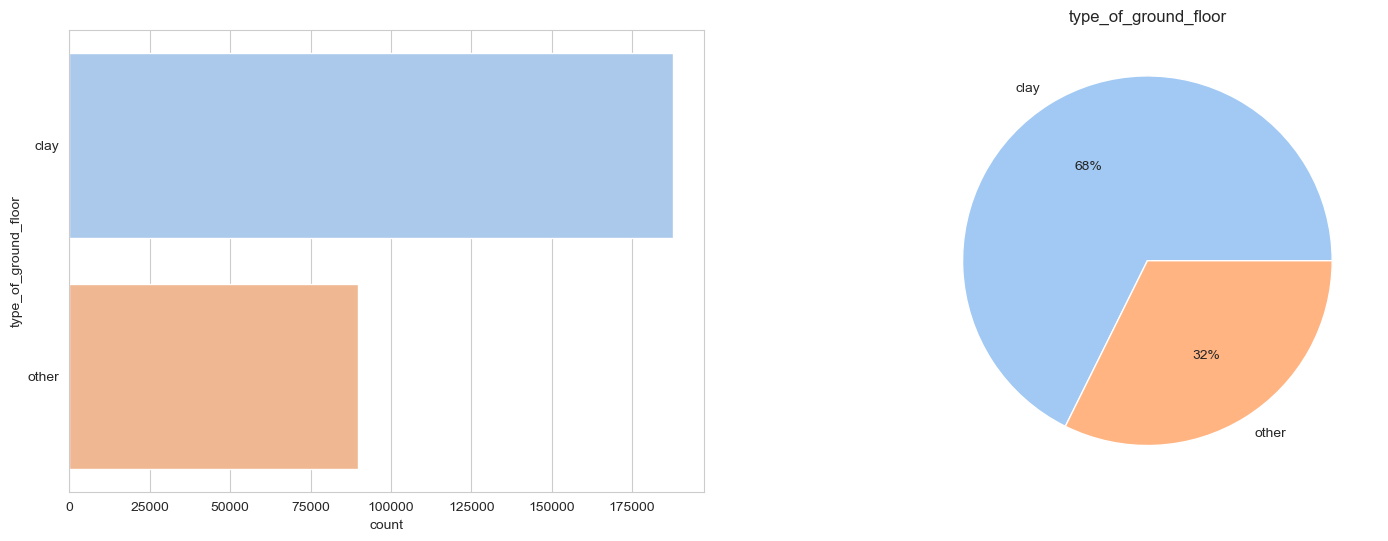

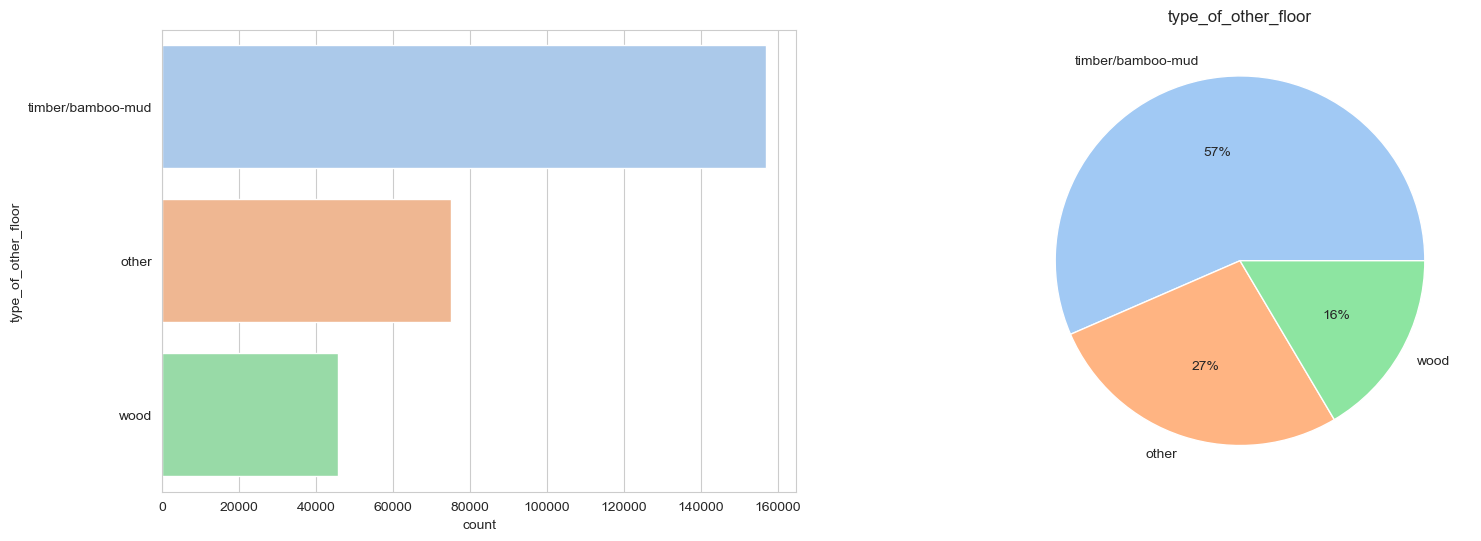

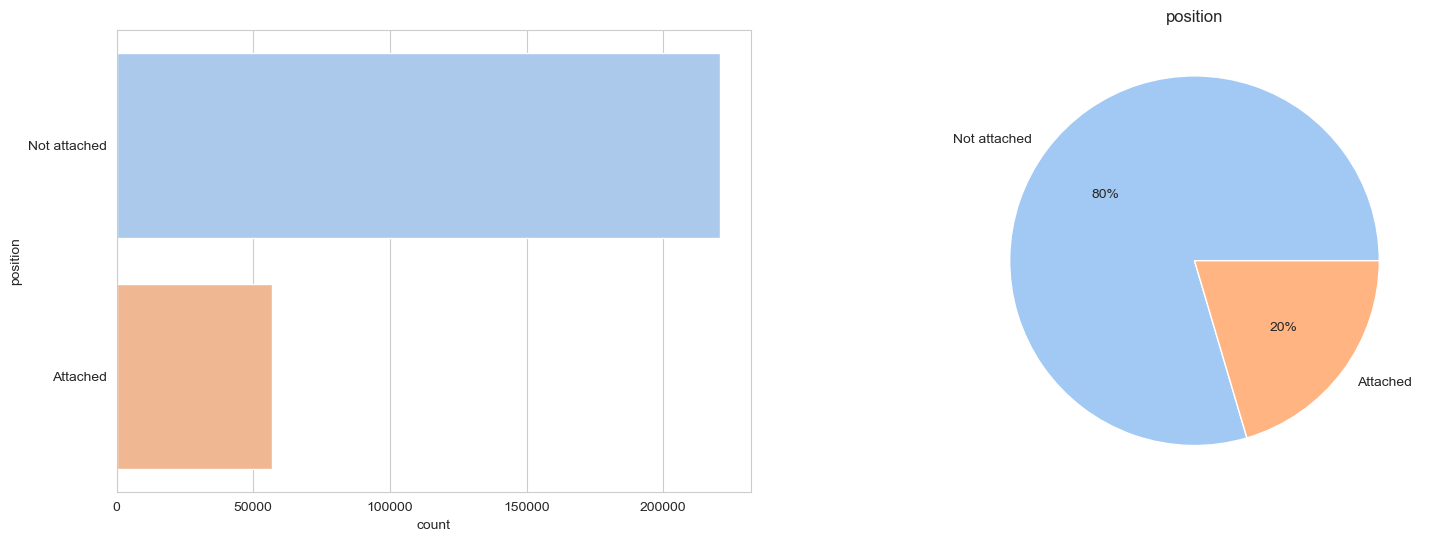

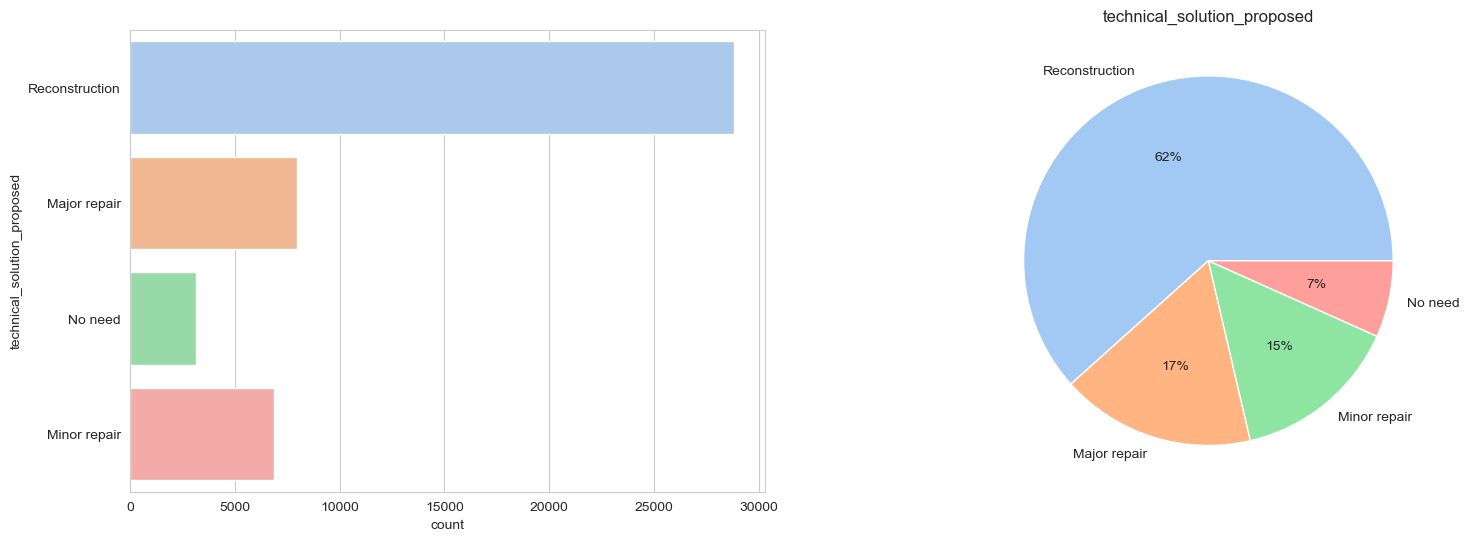

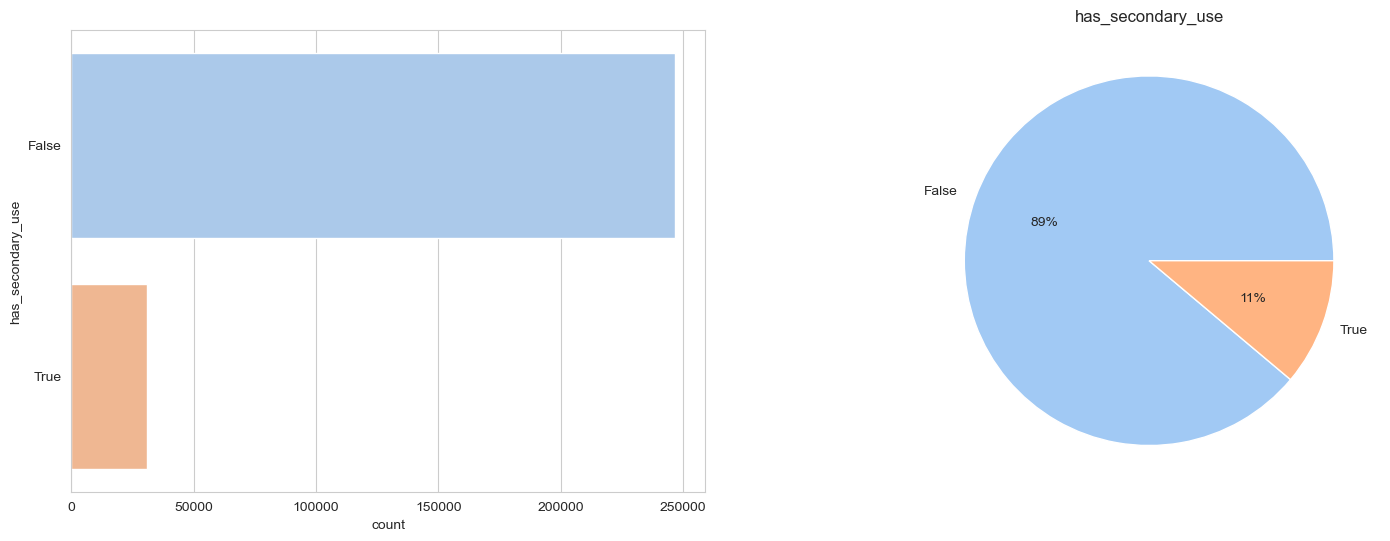

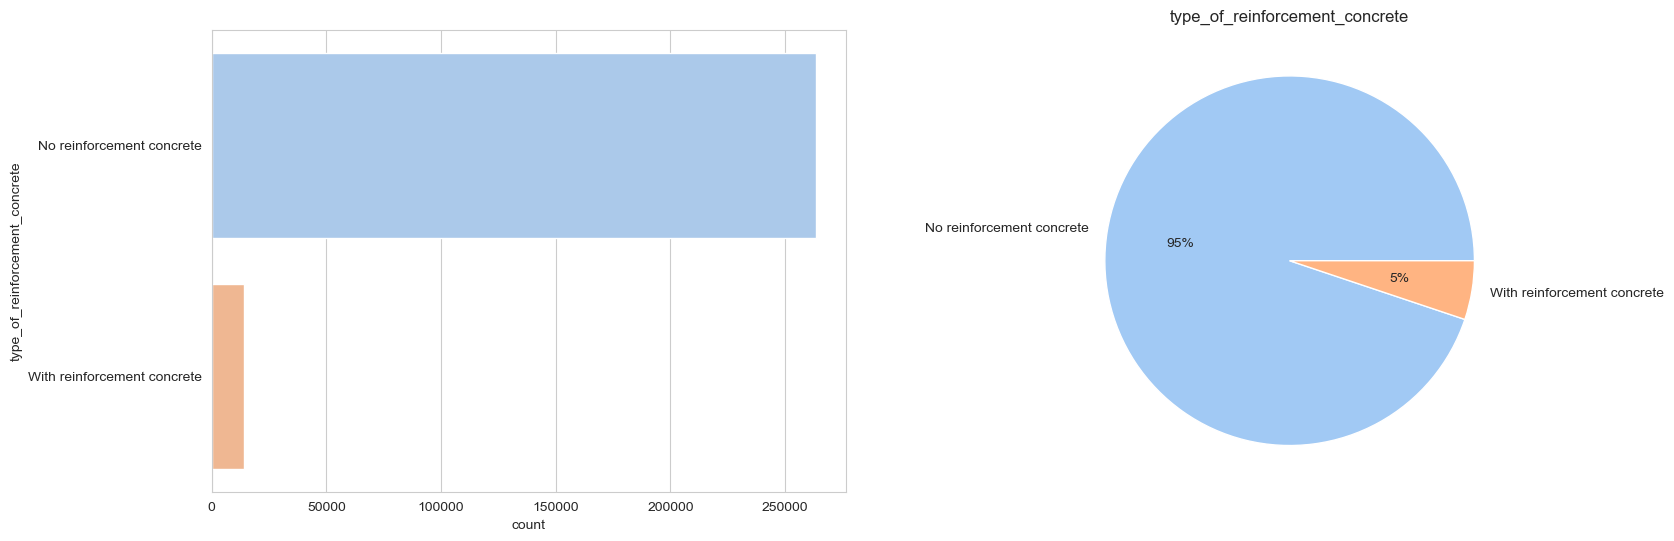

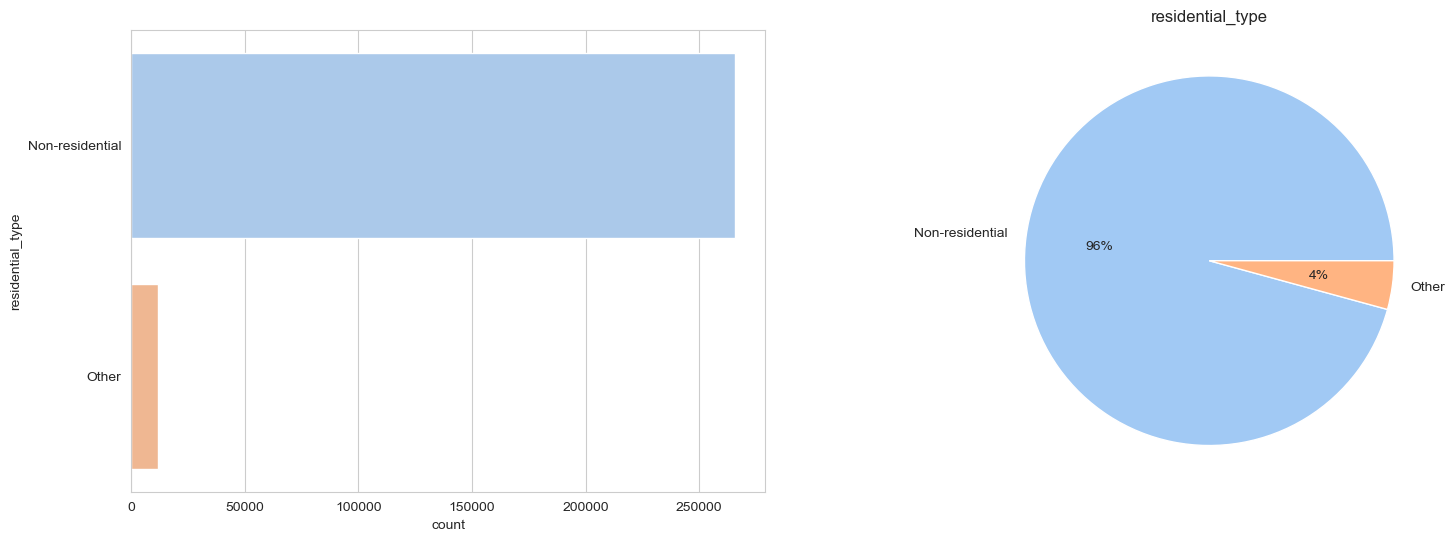

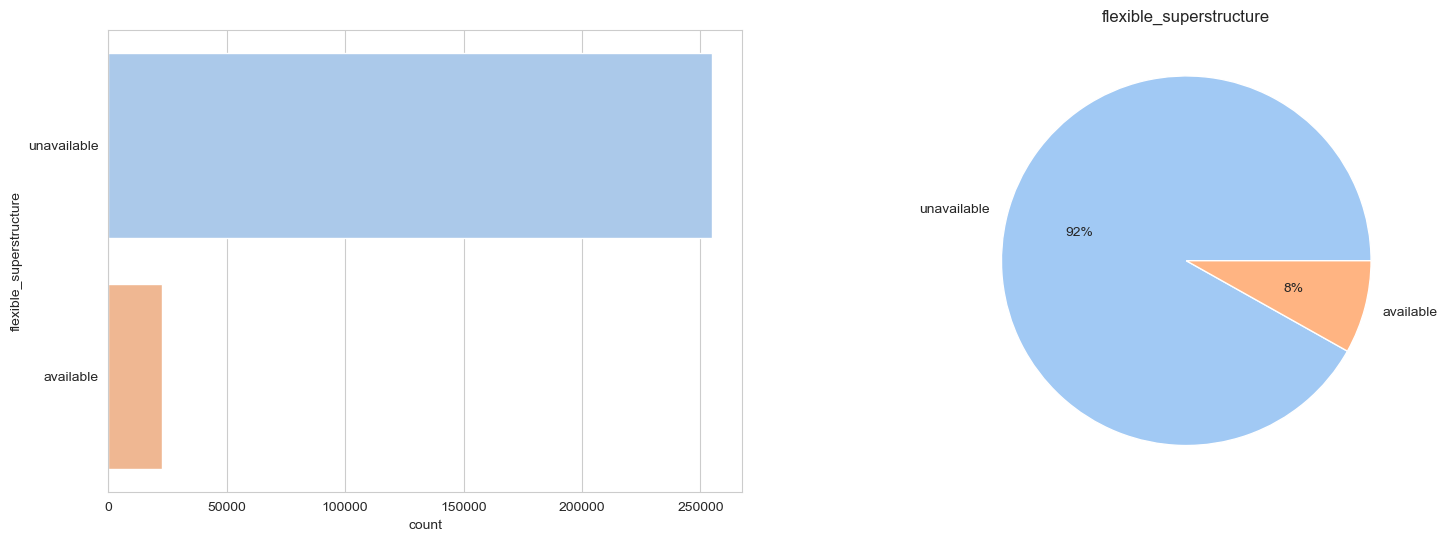

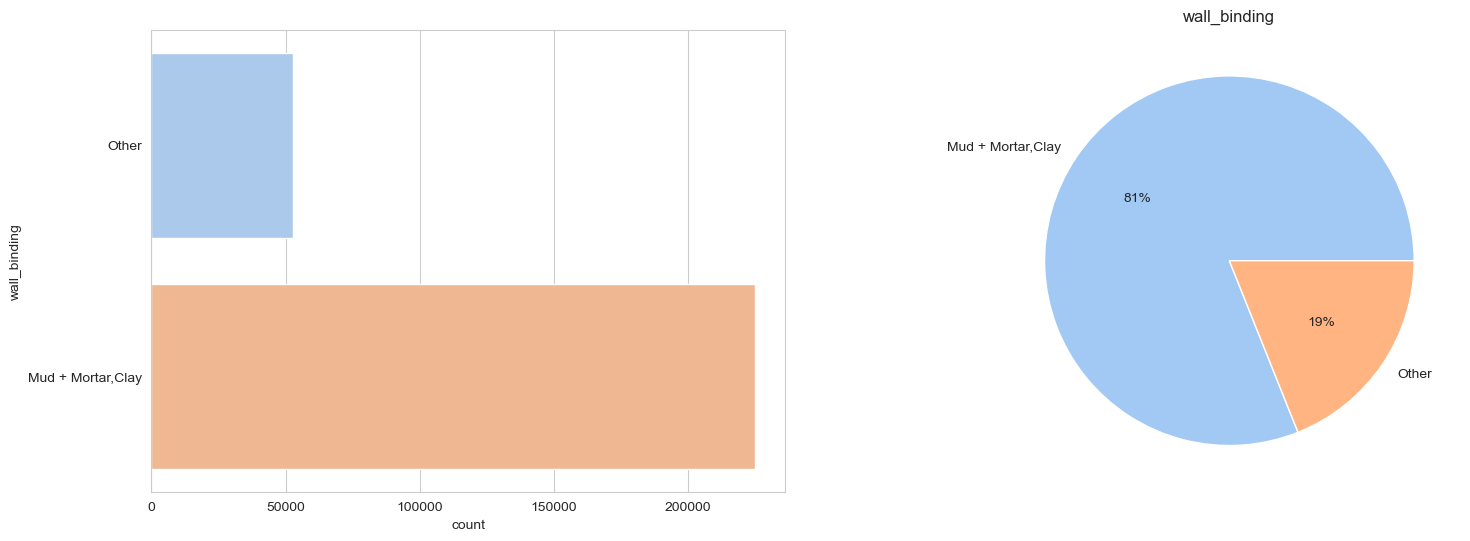

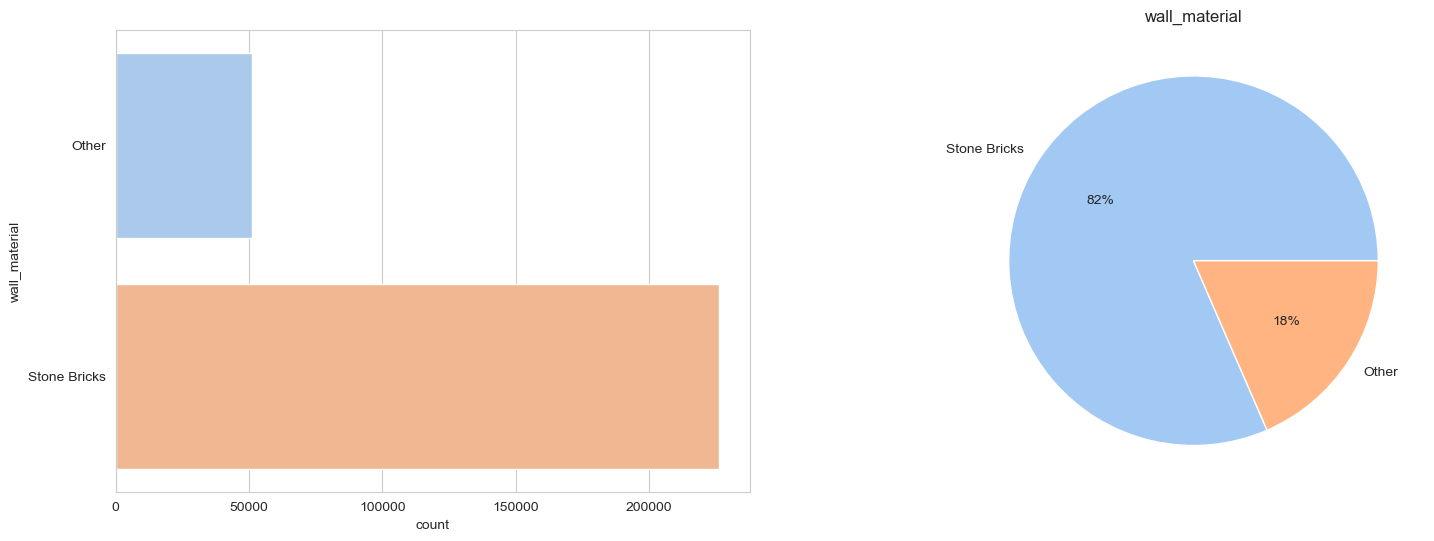

In [101]:
plotBP(df_prep)


<Axes: >

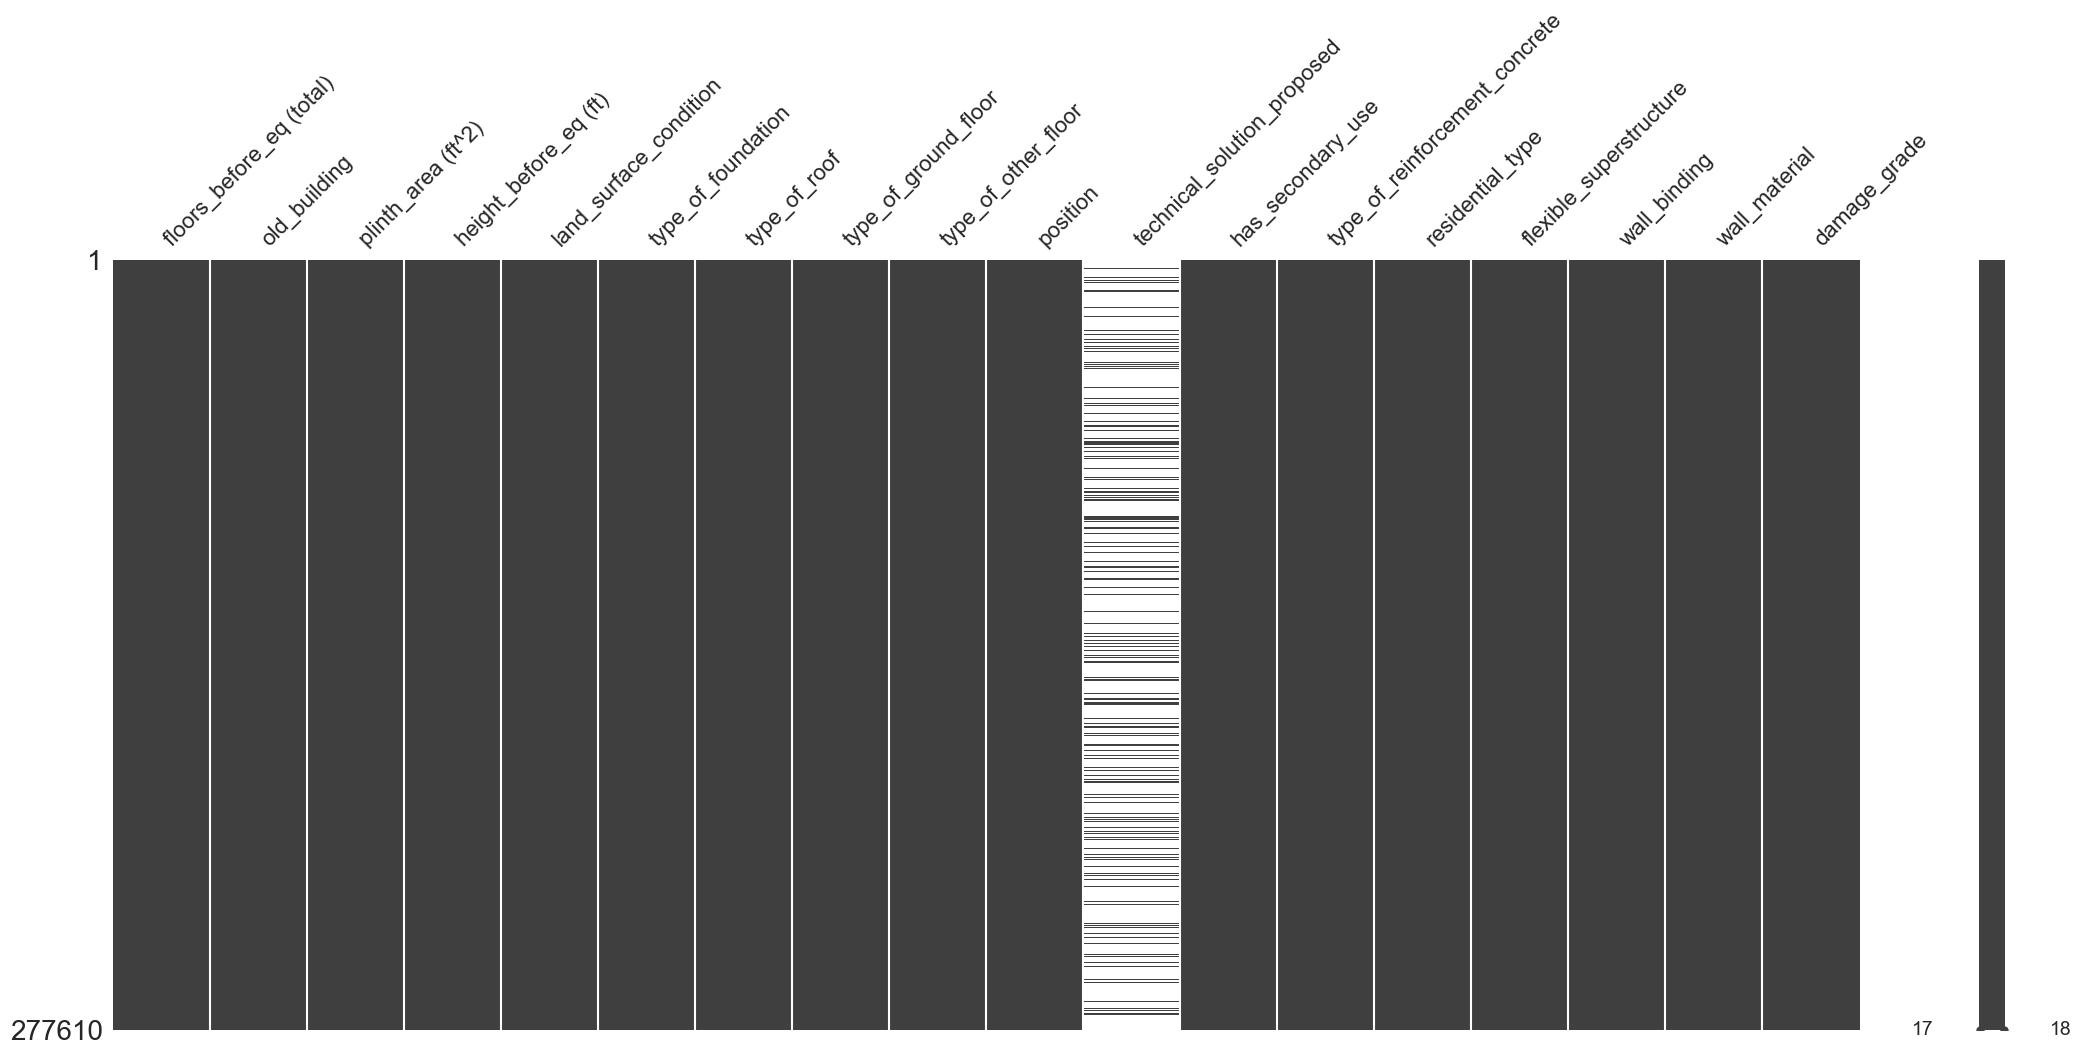

In [102]:
msno.matrix(df_prep)


In [103]:
df_prep['imp'] = np.where(
    df_prep['damage_grade'] == 1.0, 'No need',
    np.where(df_prep['damage_grade'] == 2.0, 'Minor repair',
             np.where(df_prep['damage_grade'] == 3.0, 'Major repair', 'Reconstruction')))


In [104]:
df_prep['technical_solution_proposed'].fillna(df_prep['imp'], inplace=True)


In [105]:
df_prep.drop('imp', axis=1, inplace=True)


In [106]:
df_prep_enc = toOrdinal(df_prep)
df_prep_enc['damage_grade'] = df_prep['damage_grade'].reset_index(drop=True)


<Axes: >

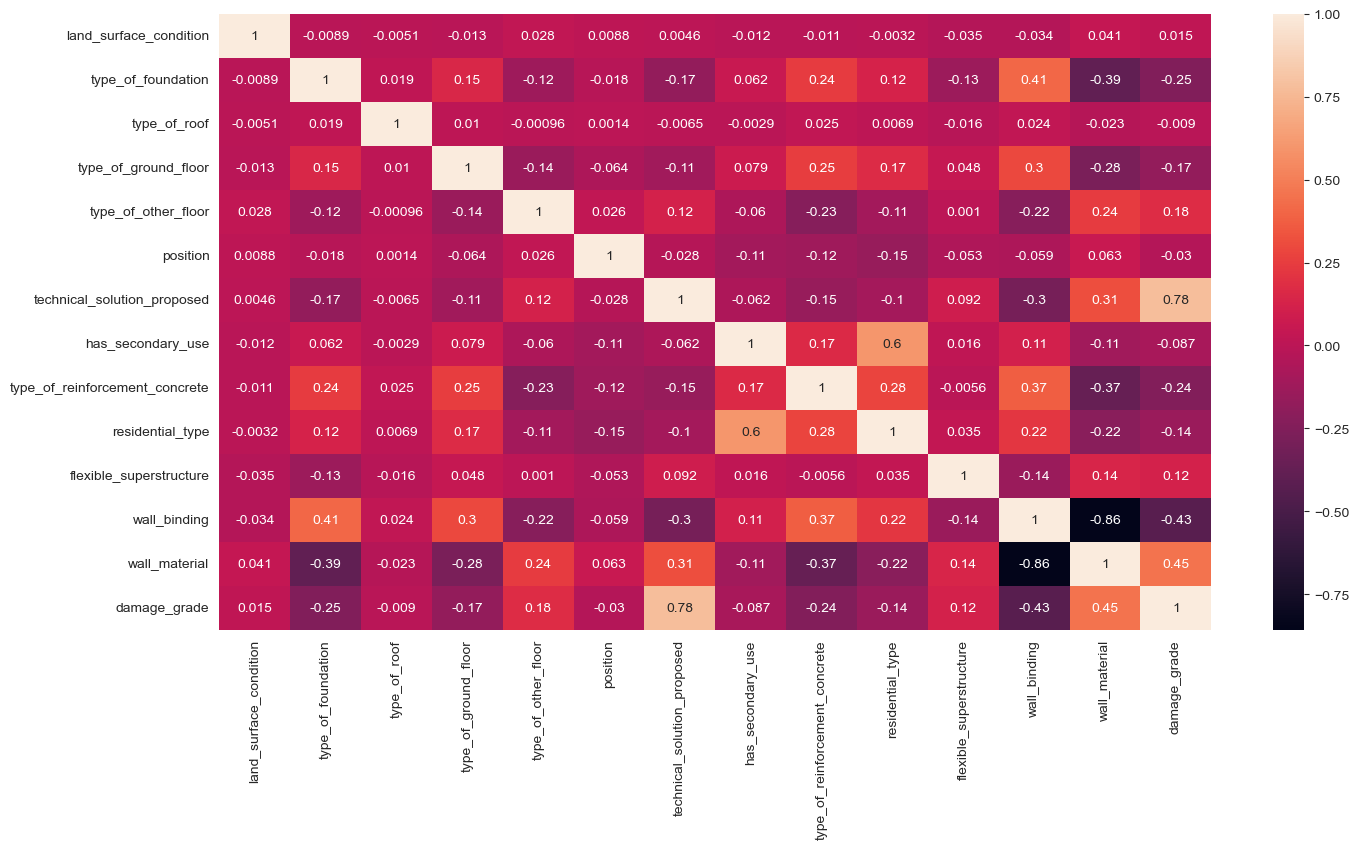

In [107]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_prep_enc.corr(method='spearman'), annot=True)


<Axes: >

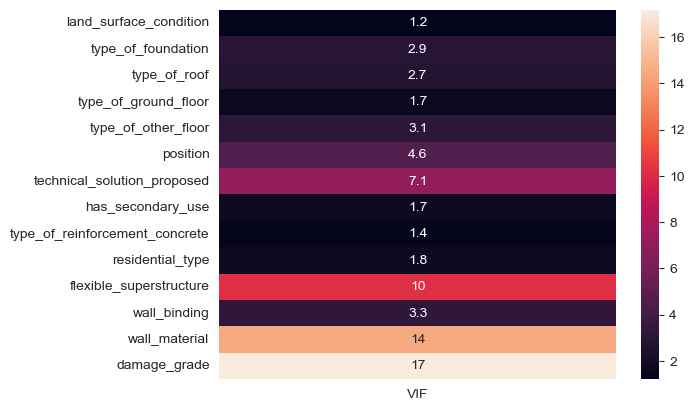

In [108]:
VIF = vifValues(df_prep_enc)
sns.heatmap(VIF, annot=True)


<Axes: >

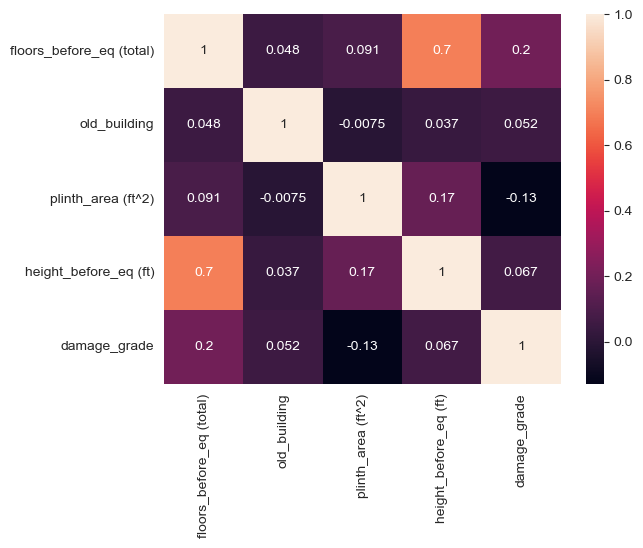

In [109]:
sns.heatmap(df_prep.select_dtypes(exclude='object').corr(), annot=True)


In [110]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
numeric_features = list(df_prep.select_dtypes(exclude=['object']).columns)[:-1]
categorical_features = list(df_prep.select_dtypes(include=['object']).columns)
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder(drop='first'))
Preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features)
        ,('categorical_transformer', categorical_transformer, categorical_features)
    ],
    remainder='passthrough',
    verbose=True,
    n_jobs=14)
pipe = make_pipeline(Preprocessor)


In [112]:
df_tr = df_prep.copy().iloc[:, :-1].reset_index(drop=True)
ls = [df_tr, df_vec.reset_index(drop=True)]
data_tr = pd.concat(ls, axis=1)

In [113]:
from sklearn.model_selection import train_test_split, GridSearchCV
features = data_tr.iloc[:, :-1]
target = data_tr.iloc[:, -1]

# split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)


In [114]:
from imblearn.over_sampling import ADASYN, SMOTE, KMeansSMOTE, SVMSMOTE, BorderlineSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours


In [115]:
import lightgbm as lgb

In [116]:
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.pipeline import make_pipeline as make_pipeline_imb
sampler = Pipeline_imb([
    ('prep', Preprocessor), # OHE dan StandardScaling
    ('sampler', RandomUnderSampler()]) # Sampling Method


In [ ]:
X_rus, y_rus = sampler.fit_resample(X_train, y_train)

In [122]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

svc = LinearSVC(C=7.25, class_weight='balanced')
svc.fit(X_rus, y_rus)
y_pred = svc_tune.predict(X_test)

f1_score(y_pred, y_test, average='macro')


In [124]:
from xgboost import XGBClassifier

x = XGBClassifier(random_state=42)
x.fit(X_rus, y_rus)
y_pred = x.predict(X_test)

f1_score(y_pred, y_test, average='macro')

In [ ]:
from catboost import CatBoostClassifier

c = CatBoostClassifier(random_state=42)
c.fit(X_rus, y_rus)

y_pred = c.predict(X_test)

print(f1_score(y_test, y_pred, average='macro'))

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

l = LGBMClassifier(random_state=42)
l.fit(X_rus, y_rus)

y_pred = l.predict(X_test)

print(f1_score(y_test, y_pred, average='macro'))

In [ ]:
def lgbm_objective(trial):

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 5,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    l = LGBMClassifier(**params, random_state=69420)
    l.fit(X_train, y_rus)

    y_pred = l.predict(X_test)

    return f1_score(y_test, y_pred, average="macro")


l_study = optuna.create_study(direction='maximize')
l_study.optimize(lgbm_objective, n_trials=1000, n_jobs=6, timeout=60*15, show_progress_bar=True)

In [ ]:
l = LGBMClassifier(**l_study.best_params, random_state=69420)
l.fit(X_rus, y_rus)

In [ ]:
l_selected_features = pd.DataFrame(
    l.feature_importances_, index=np.arange(0, 111), columns=['importance'])
l_selected_features.sort_values(by='importance', ascending=False, inplace=True)

sweet_spot_l = {}
for i in range(1, 112):
    X_train_selected = X_train.toarray()[:, l_selected_features[:i].index]
    X_test_selected = X_test.toarray()[:, l_selected_features[:i].index]

    l_s = LGBMClassifier(**params, random_state=69420, verbose=-1)
    l_s.fit(X_train_selected, y_rus)

    y_pred = l_s.predict(X_test_selected)
    skor = f1_score(y_test, y_pred, average='macro')
    print(f"{i} fitur teratas : {skor}")
    sweet_spot_l[i] = skor

In [ ]:
sweet_spot_l.head(10)

f1_score
81  0.816644
75  0.816553
76  0.816371
73  0.816128
83  0.816127
64  0.816123
77  0.815945
65  0.815898
48  0.815818
61  0.815803

In [ ]:
l = LGBMClassifier(**params, random_state=69420)
l.fit(X_train.toarray()[:, l_selected_features[:81].index], y_rus)

y_pred = l.predict(X_test.toarray()[:, l_selected_features[:81].index])

print(f1_score(y_test, y_pred, average='macro'))

[LightGBM] [Warning] feature_fraction is set=0.5375403412968238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5375403412968238
[LightGBM] [Warning] lambda_l1 is set=0.09918938374098207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09918938374098207
[LightGBM] [Warning] bagging_fraction is set=0.9903473914047031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903473914047031
[LightGBM] [Warning] lambda_l2 is set=0.12147618595222721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12147618595222721
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.816643911642682


In [ ]:
from collections import Counter

In [ ]:
submit_df = Preprocessor.transform(test)
submit_df = submit_df.toarray()[:, l_selected_features[:81].index]
y_pred_sub = l.predict(submit_df)

Counter(y_pred_sub).most_common()

[(4.0, 80566), (3.0, 68778), (2.0, 41213), (1.0, 35121), (0.0, 16404)]

In [ ]:
submission = pd.read_csv("../../dataset/raw/sample_submission.csv")
submission["damage_grade"] = y_pred_sub + 1
submission["damage_grade"] = submission["damage_grade"].astype(int)
submission.head()

id  damage_grade
0   0             4
1   1             5
2   2             5
3   3             4
4   4             2

In [ ]:
submission.to_csv("../../dataset/submission_lgbm_feat_select_tuned_ALLAHUAKBAR.csv", index=False)